In [1]:
import numpy as np

import cognitive_GLVQ as cglvq
import GLVQ as glvq
import optimizer as opt

import matplotlib.pyplot as plt

import random
import copy

In [2]:
random.seed(14)


In [3]:
label_names = {
    0: "Well",
    1: "A kappa",
    2: "A lambda",
    3: "M kappa",
    4: "M lambda",
    5: "G kappa",
    6: "G lambda",
}


In [4]:
num_prototypes = 2
colors = ["#5171fF", "#fF7151", "#519951"]
img_folder = "images/figs/"
data_name = "sp_f"


In [5]:
def save_figs(model, experiment, model_name, lr):
    fig1 = model.lr_graph(f"{model_name} Learning Rate")
    fig2 = model.acc_graph(f"{model_name} Accuracy")
    fig3 = model.f1_graph(f"{model_name} F1 Score")
    figs = [fig1, fig2, fig3]
    fig_type = ["lr", "acc", "f1"]
    for i, fig in enumerate(figs):
        fig.savefig(
            f"{img_folder}/{experiment}/{data_name}/{model_name}_{lr}_{fig_type[i]}.png",
            dpi=300,
        )

## data preparation

In [6]:
feature_dir = "dataset/feature/inputs_wo_ud_w_sp_f.npy"
label_dir = "dataset/label/labels_wo_ud.npy"


In [7]:
feature = np.load(feature_dir)
label = np.load(label_dir)
label = label.astype(int)


In [8]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))
sample_number


{0: 1007, 1: 48, 2: 31, 3: 71, 4: 25, 5: 210, 6: 94}

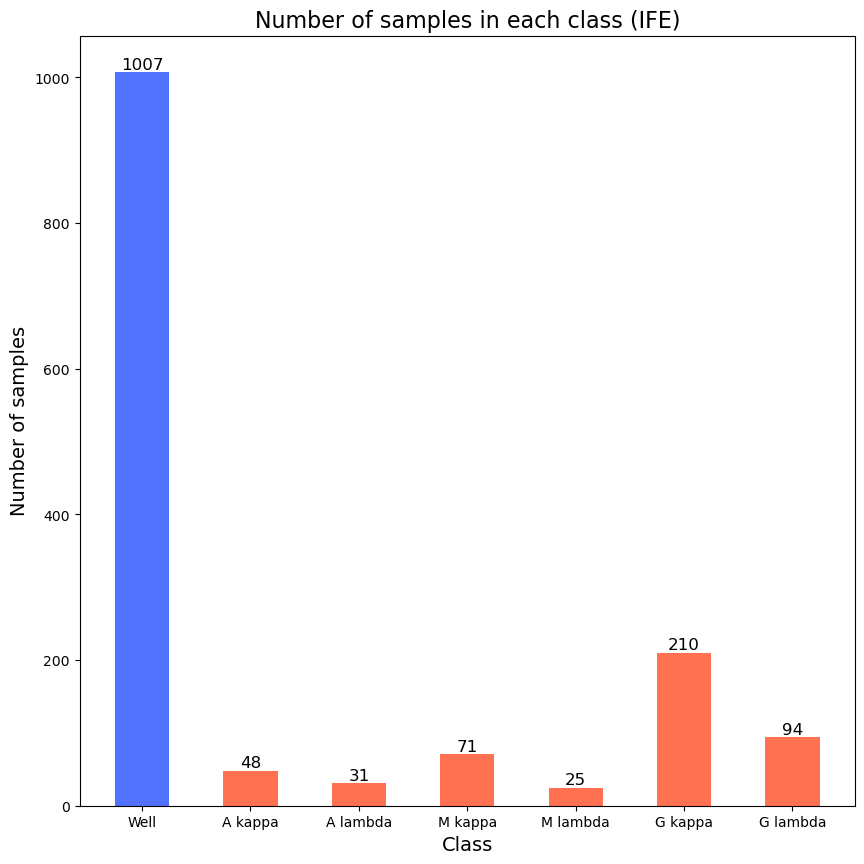

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    if i == 0:
        color = colors[i]
    else:
        color = colors[1]
    ax.bar(label_names[k], v, width=0.5, color=color)
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Number of samples in each class (IFE)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + "sample/" + "IFE" + "_1", dpi=300)

### Prototype selection

In [10]:
# Prototype selection
prototype_index = []

index_normal = np.where(label == 0)
index_normal = list(index_normal[0])
prototype_normal_index = random.sample(index_normal, num_prototypes * 6)
prototype_index += prototype_normal_index
for class_name in sample_number:
    if class_name != 0:
        index_abnormal = np.where(label == class_name)
        index_abnormal = list(index_abnormal[0])
        prototype_abnormal_index = random.sample(index_abnormal, num_prototypes)
        prototype_index += prototype_abnormal_index
# Change labels to binary classes
label = np.where(label == 0, label, 1)
# Add prototypes to dataset
prototype_index.sort(reverse=True)
prototypes = [(feature[i], label[i]) for i in prototype_index]
## Remove prototypes from dataset
feature = np.delete(feature, prototype_index, axis=0)
label = np.delete(label, prototype_index, axis=0)

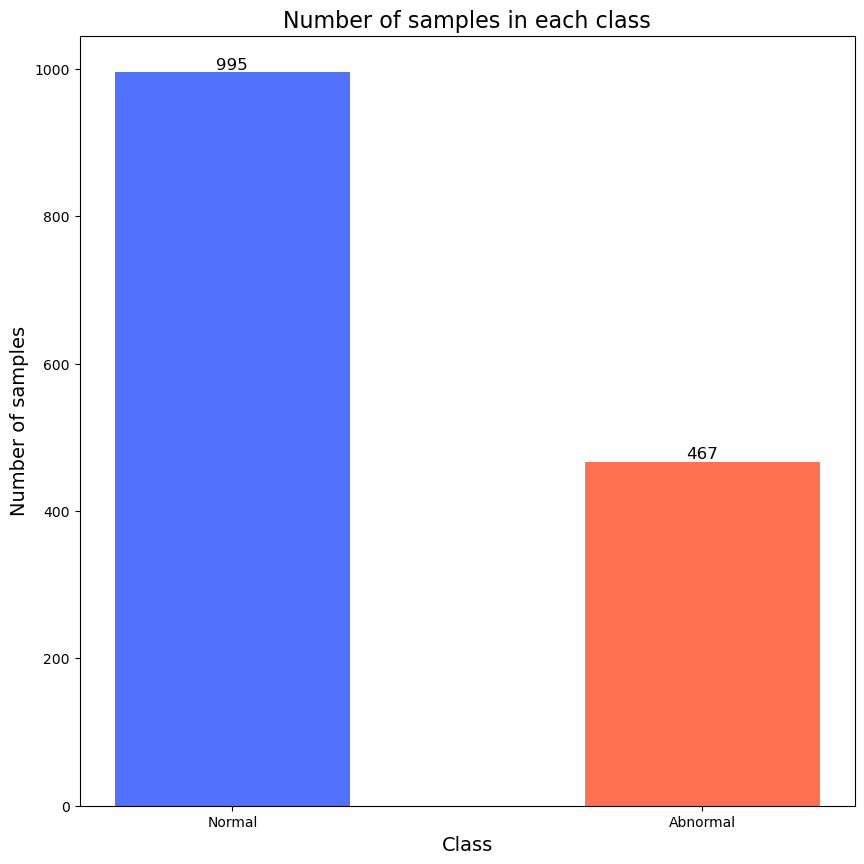

In [11]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    if k == 0:
        label_name = "Normal"
    else:
        label_name = "Abnormal"
    ax.bar(label_name, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Number of samples in each class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + "sample/" + "IFE" + "_2", dpi=300)

#### Accuracy

In [12]:
experiment = "experiment_1"


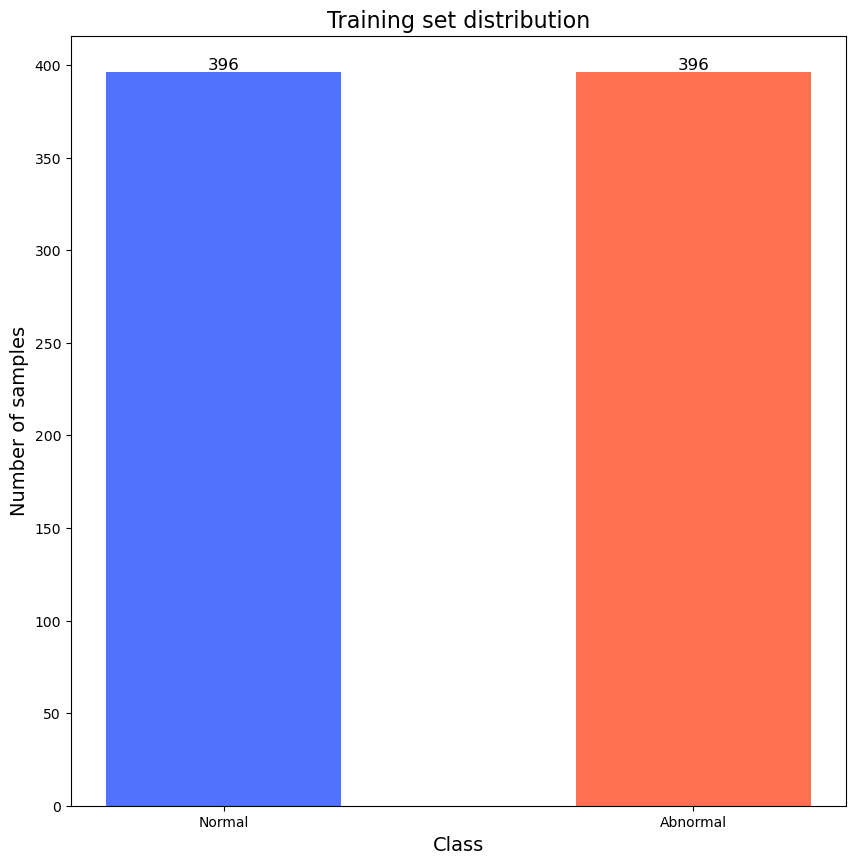

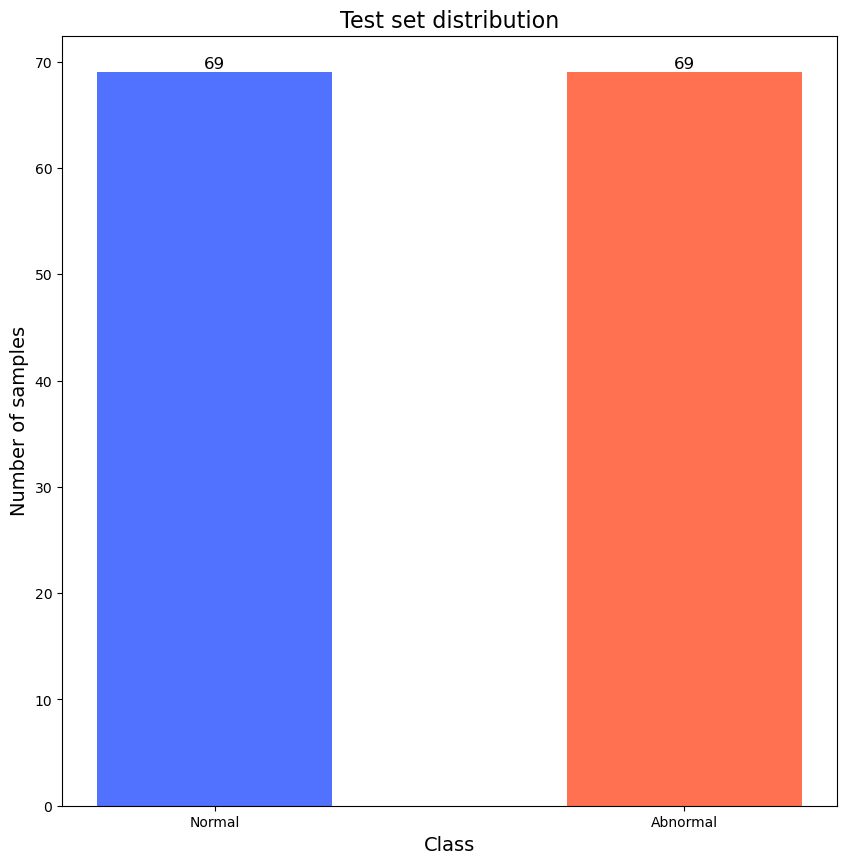

In [13]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
test_percentage = 0.15
test_size = int(test_percentage * data_per_class)
train_size = data_per_class - test_size
feature_acc = copy.deepcopy(feature)
label_acc = copy.deepcopy(label)

## Select test set
test_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size)
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_acc = [(feature_acc[i], label_acc[i]) for i in test_index]
random.shuffle(test_set_acc)
unique, counts = np.unique(label_acc[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_acc = np.delete(feature_acc, test_index, axis=0)
label_acc = np.delete(label_acc, test_index, axis=0)

## Select train set
train_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size)
    train_index += index_i_sample
train_index.sort(reverse=True)
unique, counts = np.unique(label_acc[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))
train_set_acc = [(feature_acc[i], label_acc[i]) for i in train_index]
random.shuffle(train_set_acc)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    if k == 0:
        label_name = "Normal"
    else:
        label_name = "Abnormal"
    ax.bar(label_name, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Training set distribution", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/train_dist.png", dpi=300)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    if k == 0:
        label_name = "Normal"
    else:
        label_name = "Abnormal"
    ax.bar(label_name, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Test set distribution", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/test_dist.png", dpi=300)

#### Train the Models

In [14]:
num_epochs = 100


##### GLVQ

##### 1-step lr =0.1

In [15]:
learning_rate = 0.1
glvq_acc = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc, sample_number=train_dist)

Epoch: 1, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 11, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 21, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 31, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 41, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 51, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 61, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 71, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 81, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 91, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %


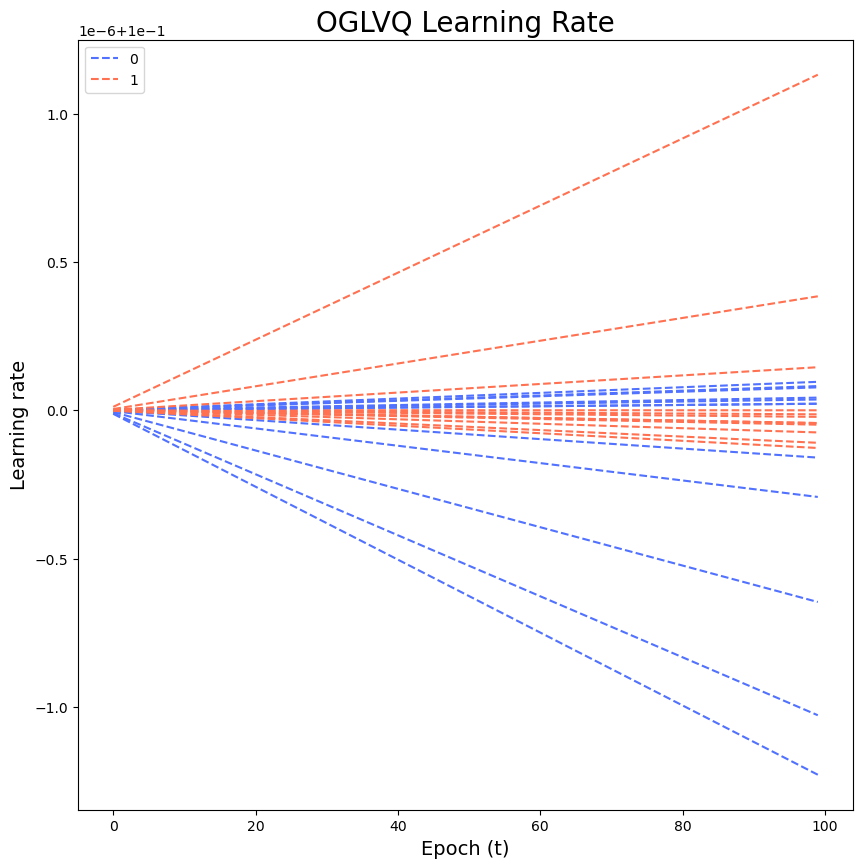

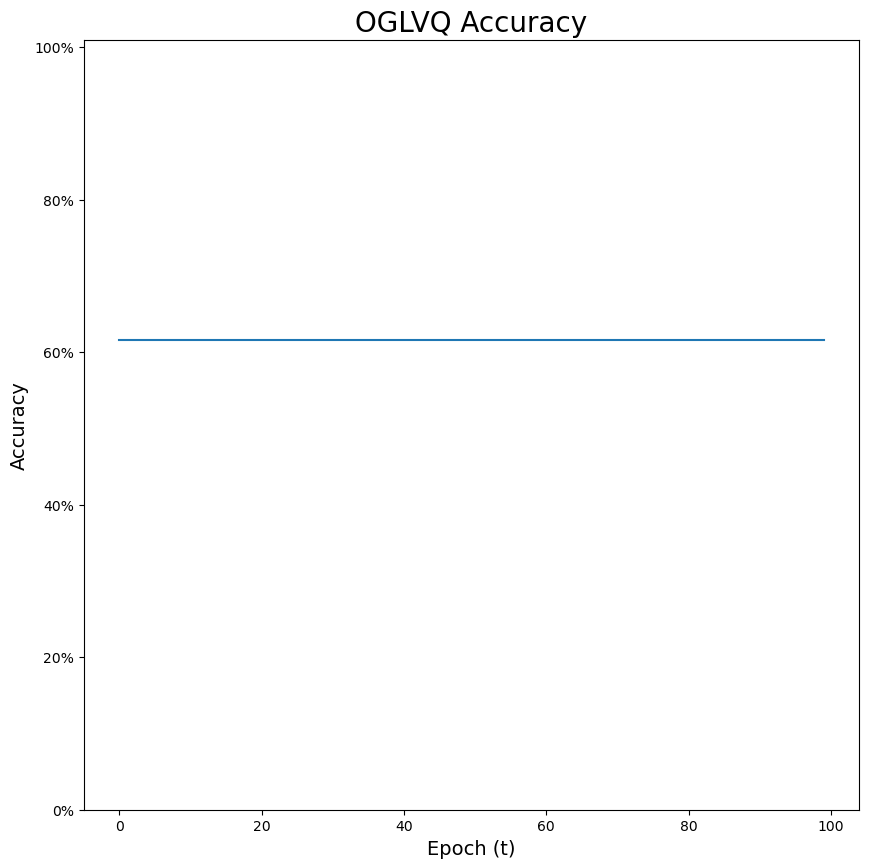

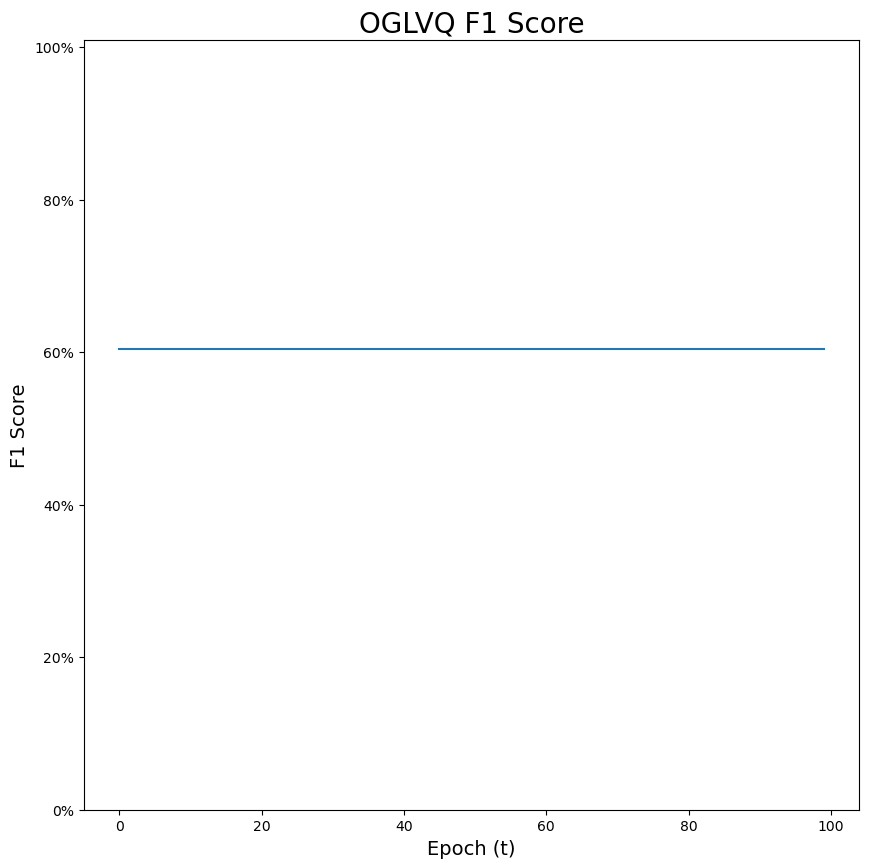

In [16]:
save_figs(glvq_acc, experiment, "OGLVQ", learning_rate)


##### 2-step lr = 0.03

In [17]:
learning_rate = 0.03
glvq_acc = glvq.GLVQ(
    prototypes,
    learning_rate,
)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc, sample_number=train_dist)

Epoch: 1, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 11, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 21, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 31, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 41, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 51, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 61, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 71, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 81, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 91, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %


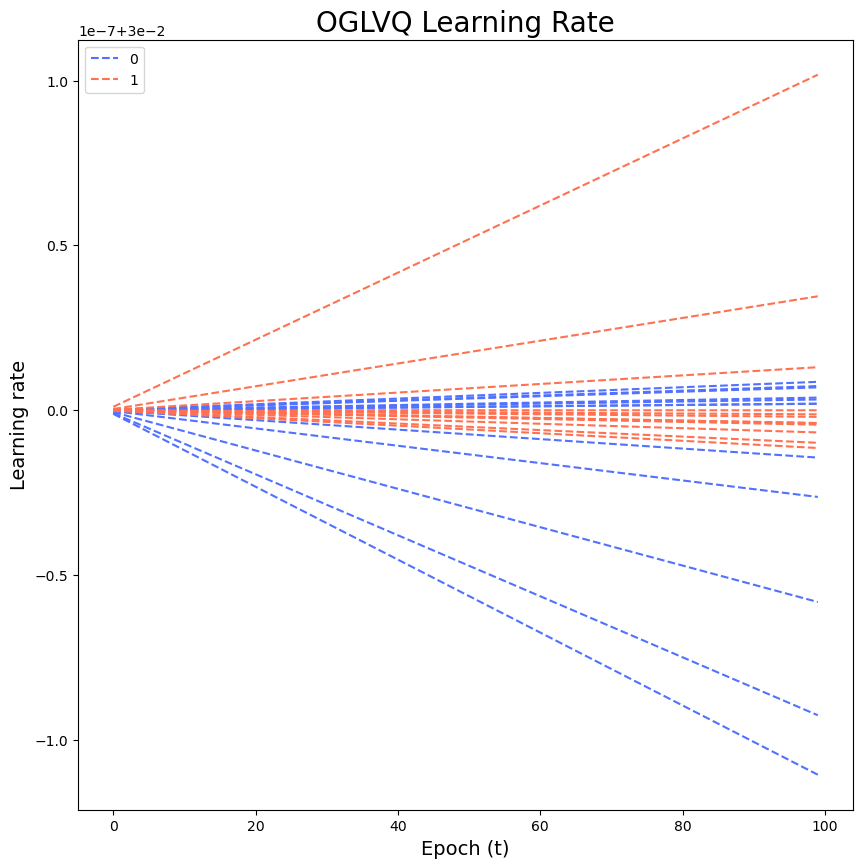

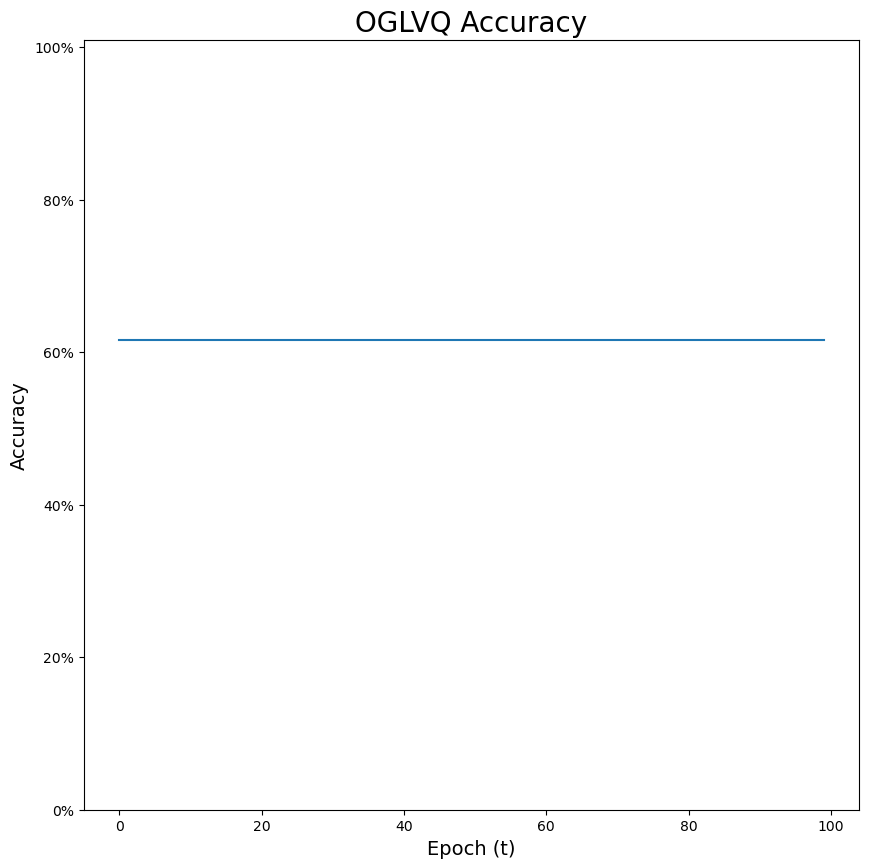

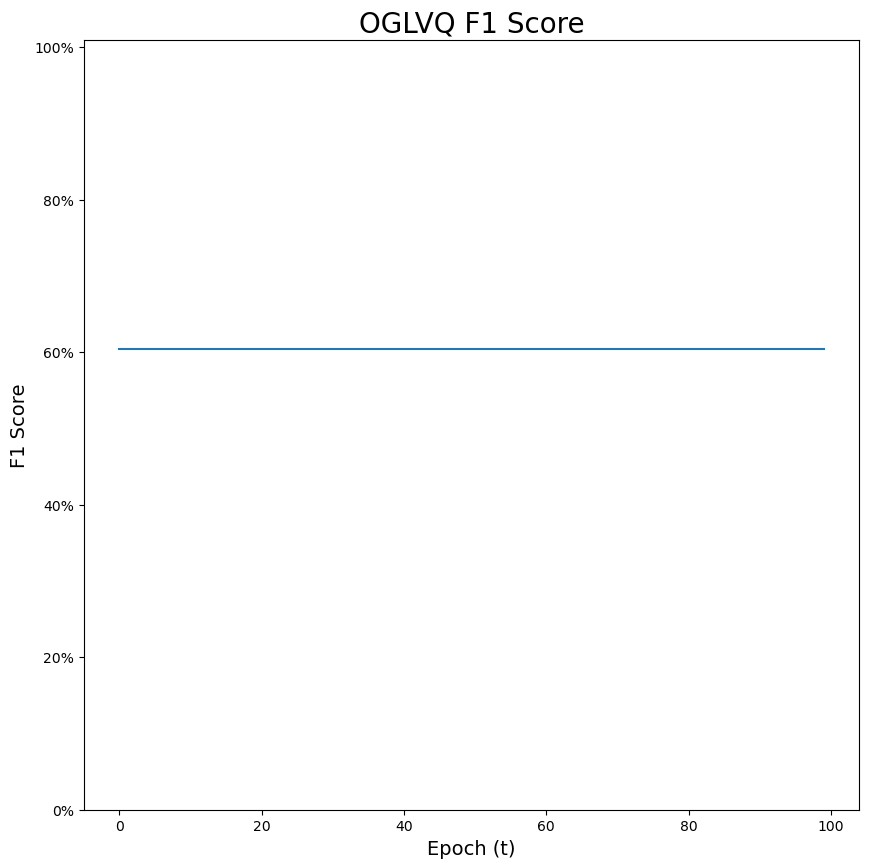

In [18]:
save_figs(glvq_acc, experiment, "OGLVQ", learning_rate)


##### 3-step lr = 0.01

In [19]:
learning_rate = 0.01
glvq_acc = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_acc.train(num_epochs, train_set_acc, test_set_acc, sample_number=train_dist)

Epoch: 1, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 11, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 21, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 31, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 41, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 51, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 61, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 71, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 81, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %
Epoch: 91, Loss: 380.6566, Accuracy: 61.59 %, F_1.0_score: 60.50 %


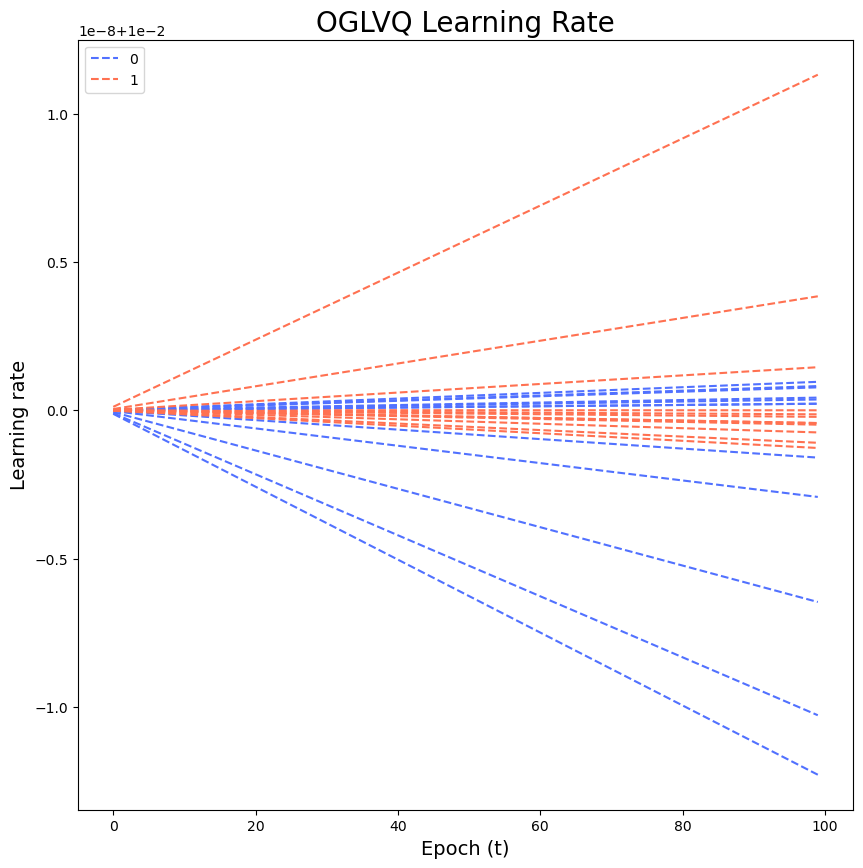

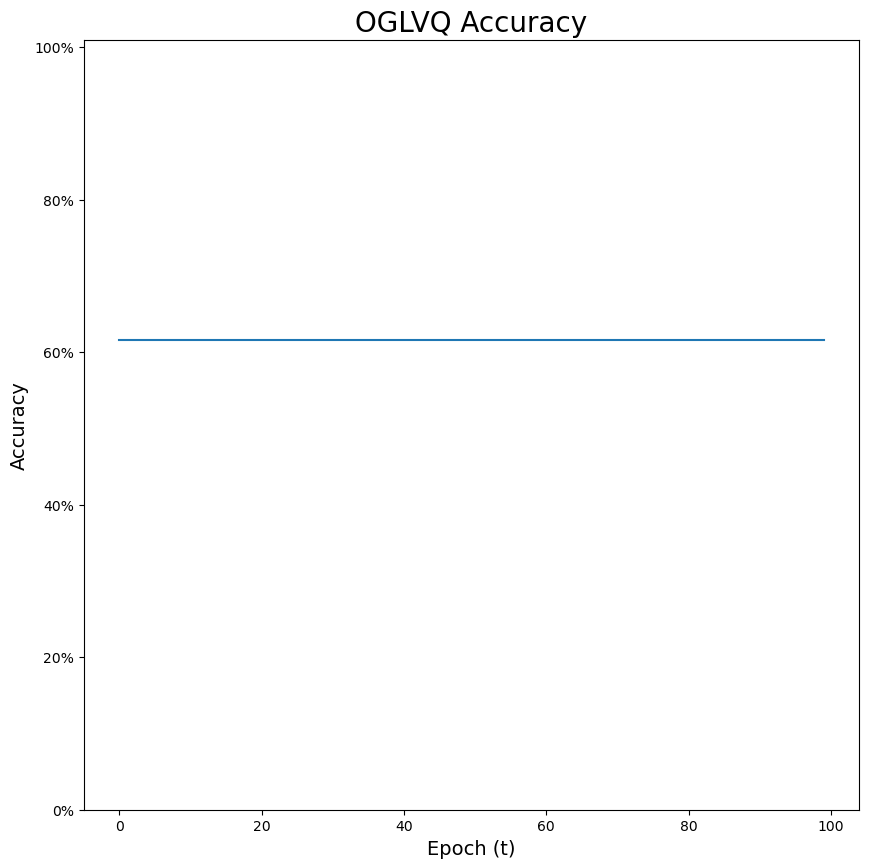

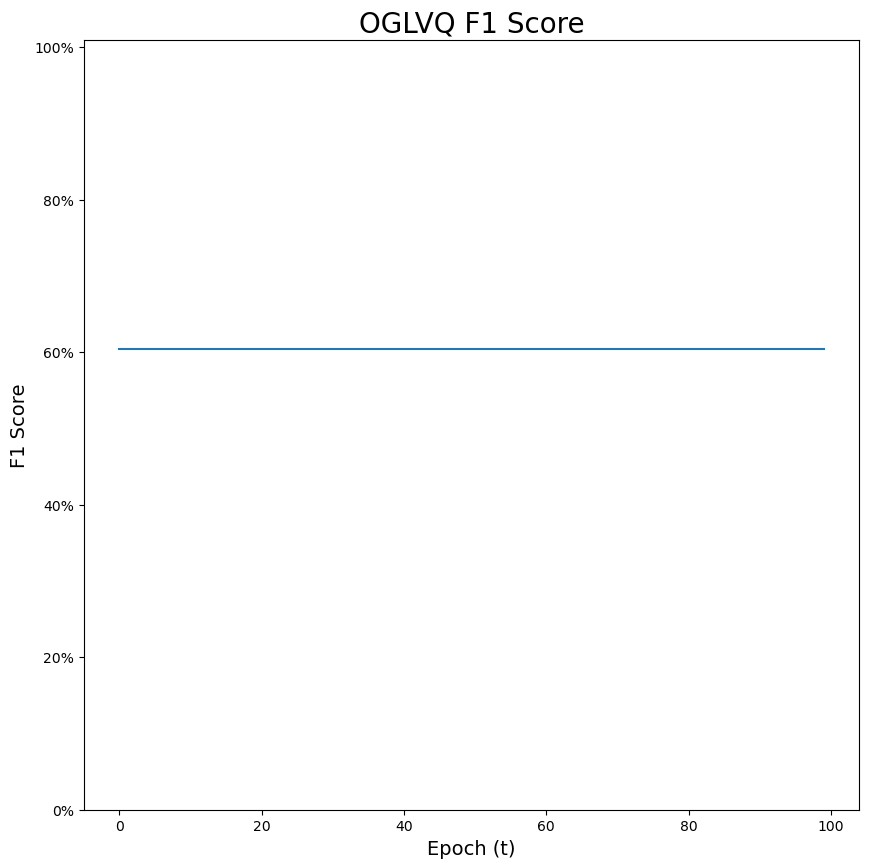

In [20]:
save_figs(glvq_acc, experiment, "OGLVQ", learning_rate)


##### CP

##### 1-step lr = 0.1

In [21]:
learning_rate = 0.1
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


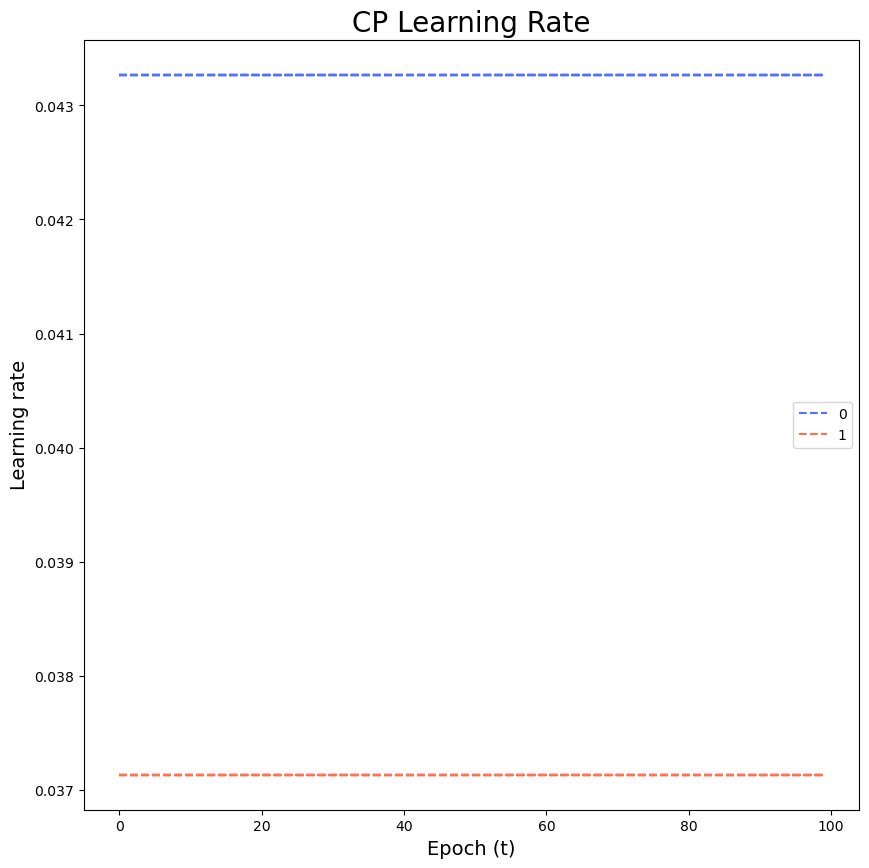

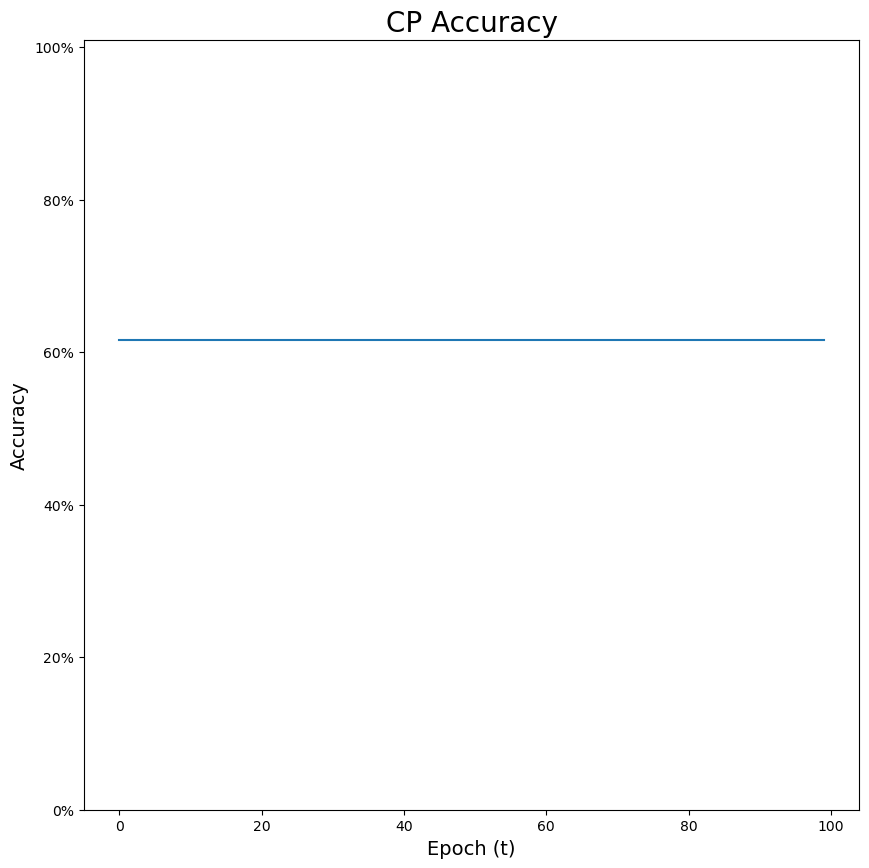

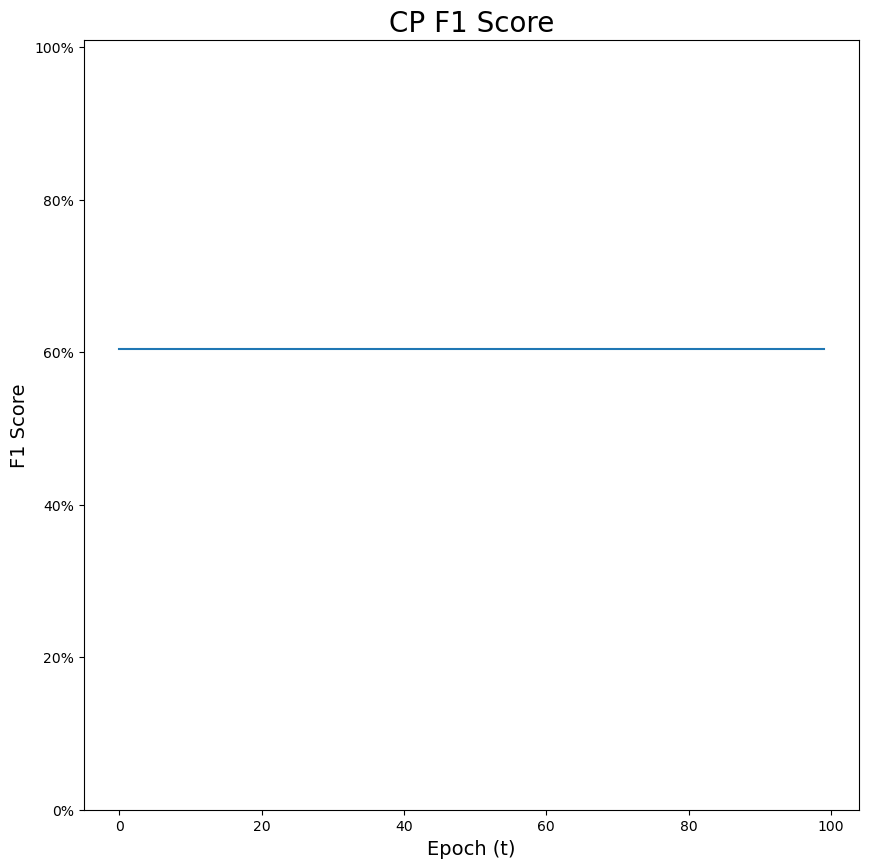

In [22]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)


##### 2-step lr = 0.03

In [23]:
learning_rate = 0.03
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


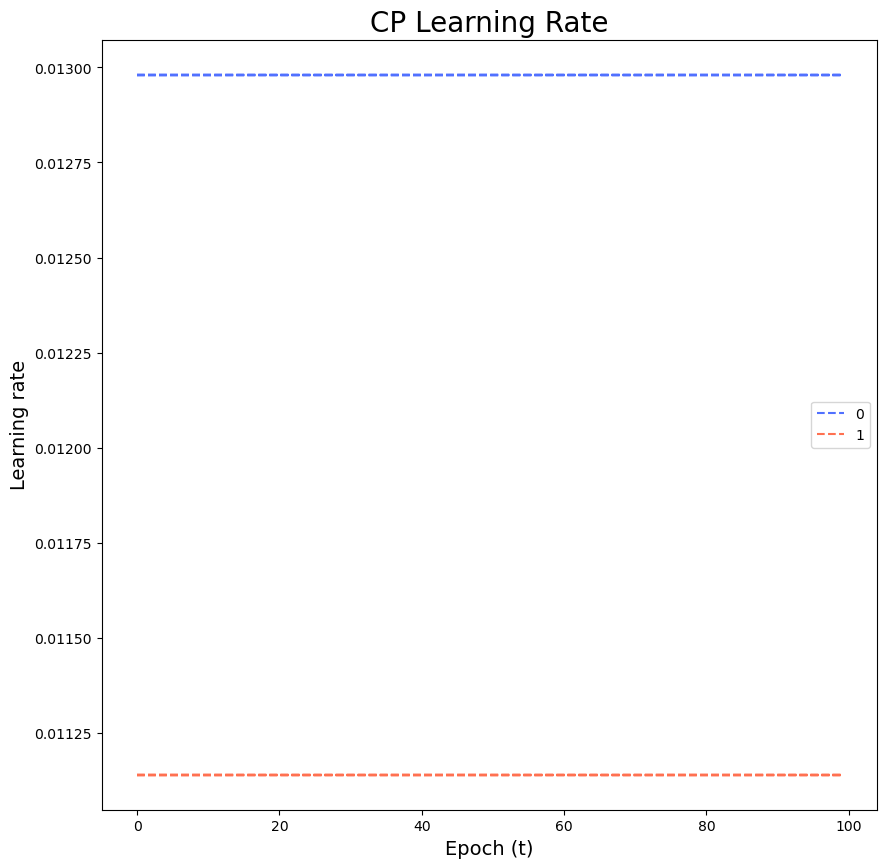

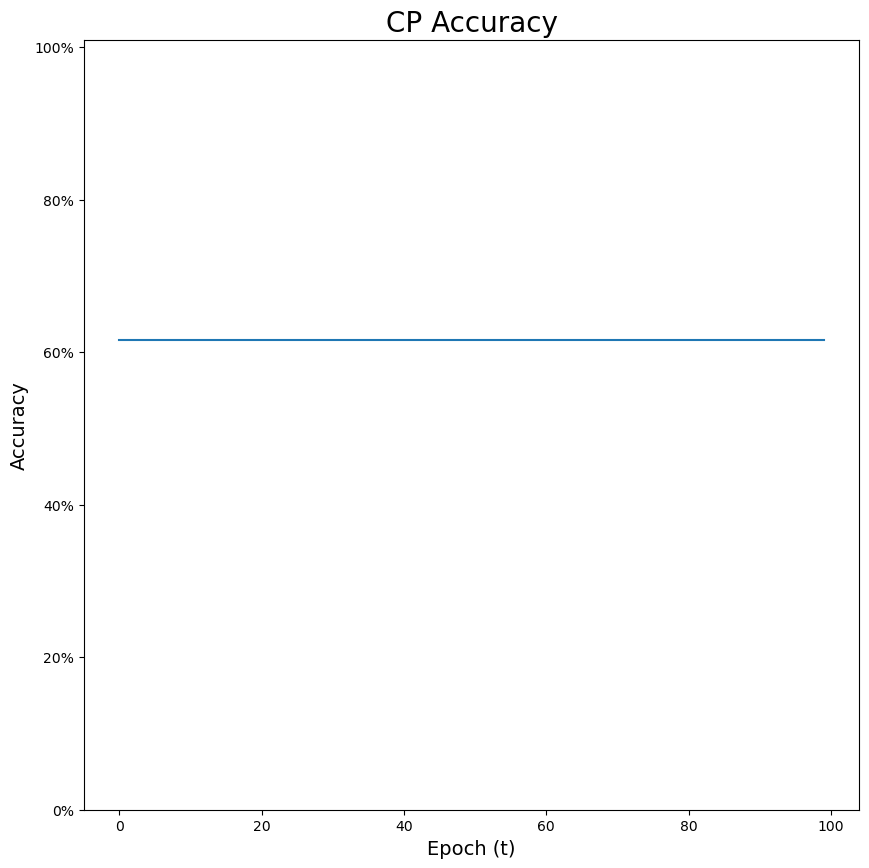

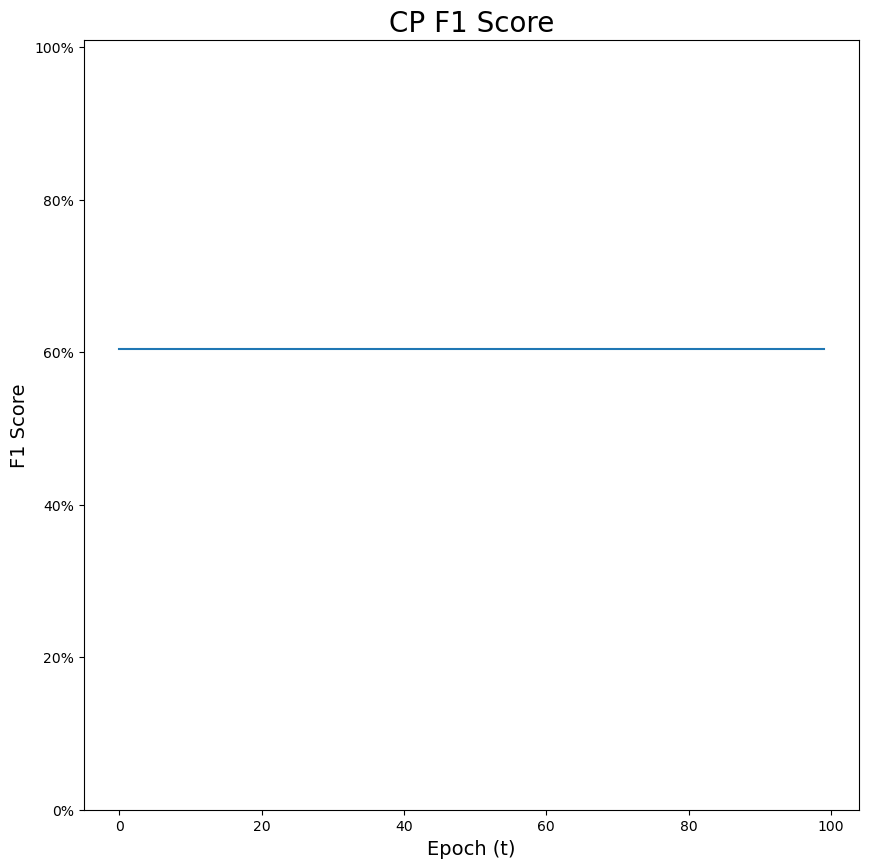

In [24]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)


##### 3-step lr = 0.01

In [25]:
learning_rate = 0.01
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


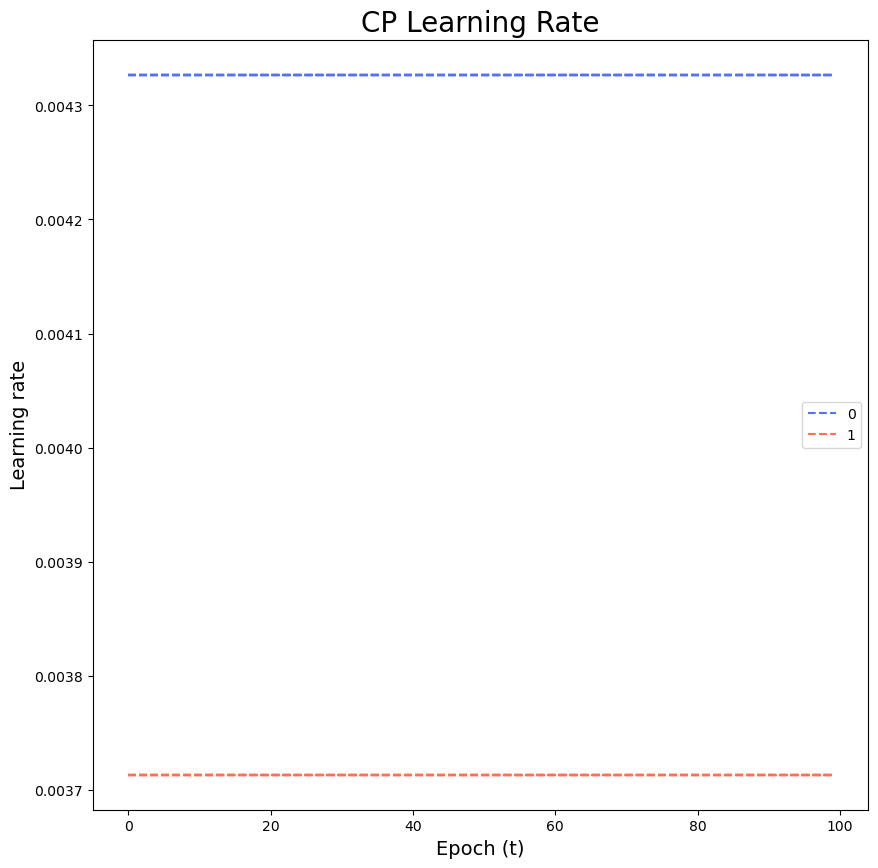

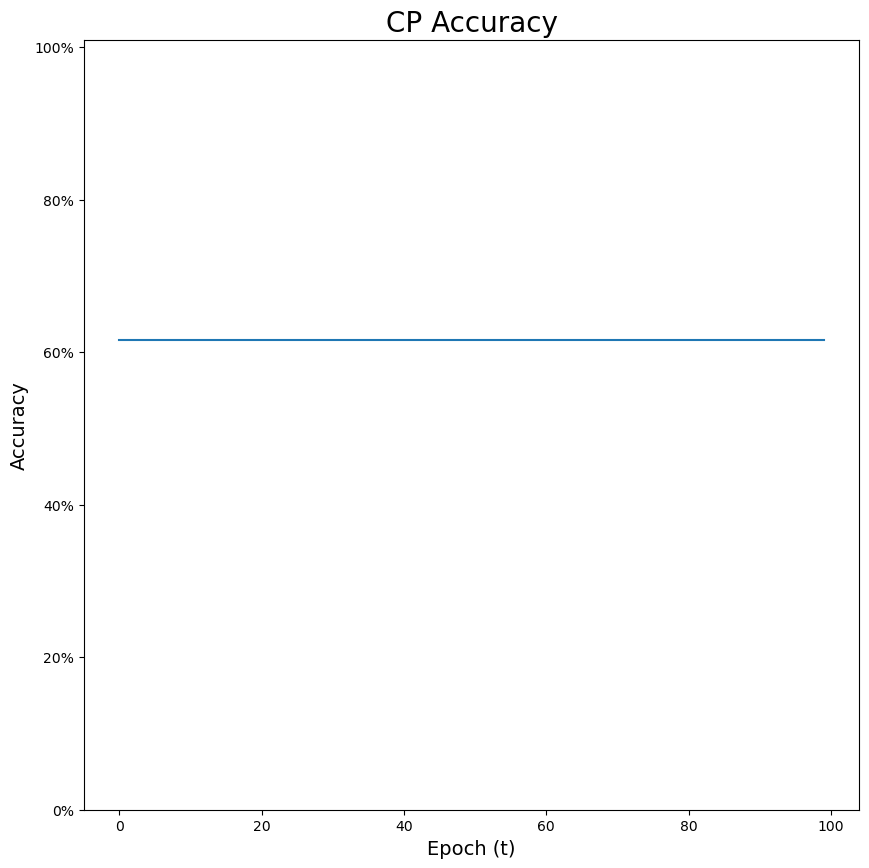

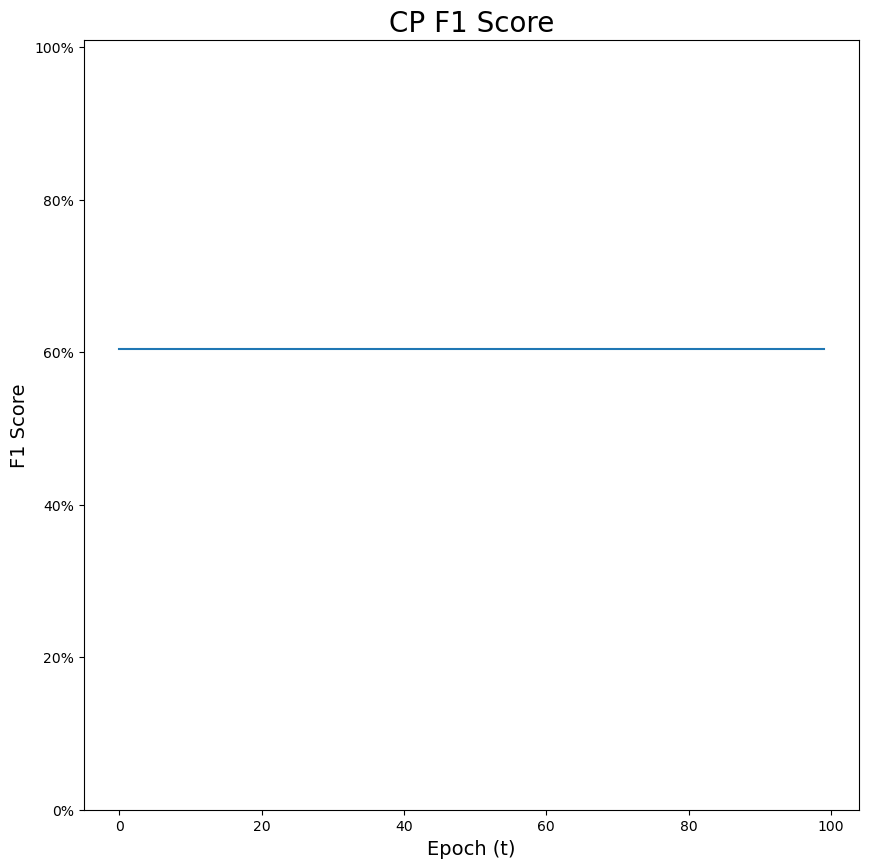

In [26]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)


##### DFH

##### 1-step lr = 0.1

In [27]:
learning_rate = 0.1
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


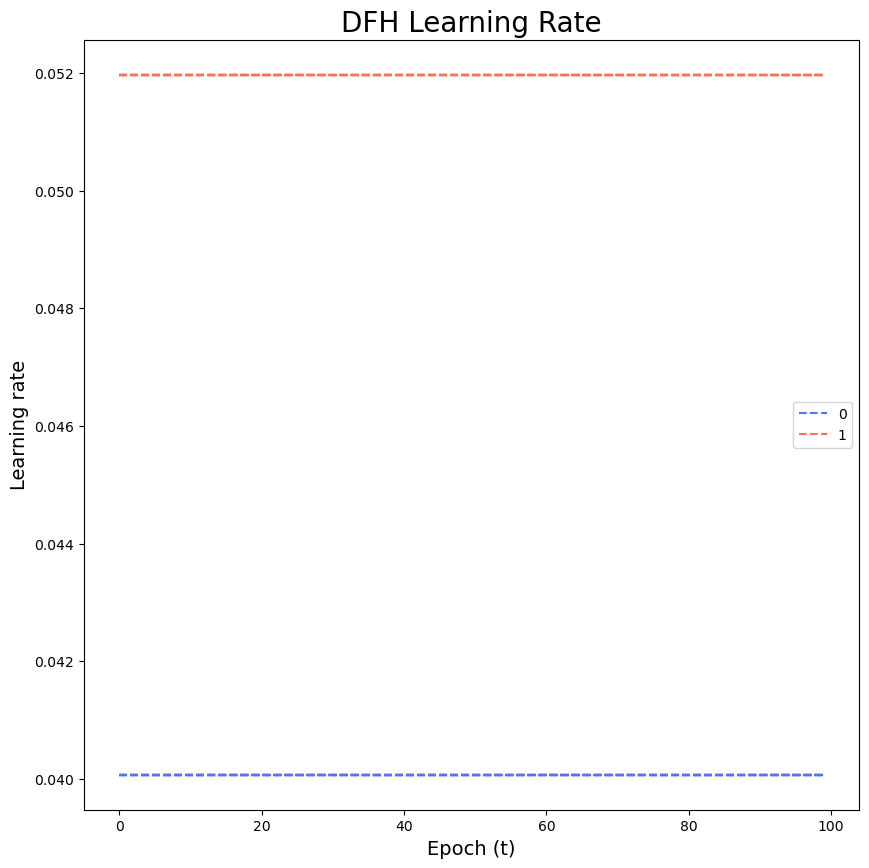

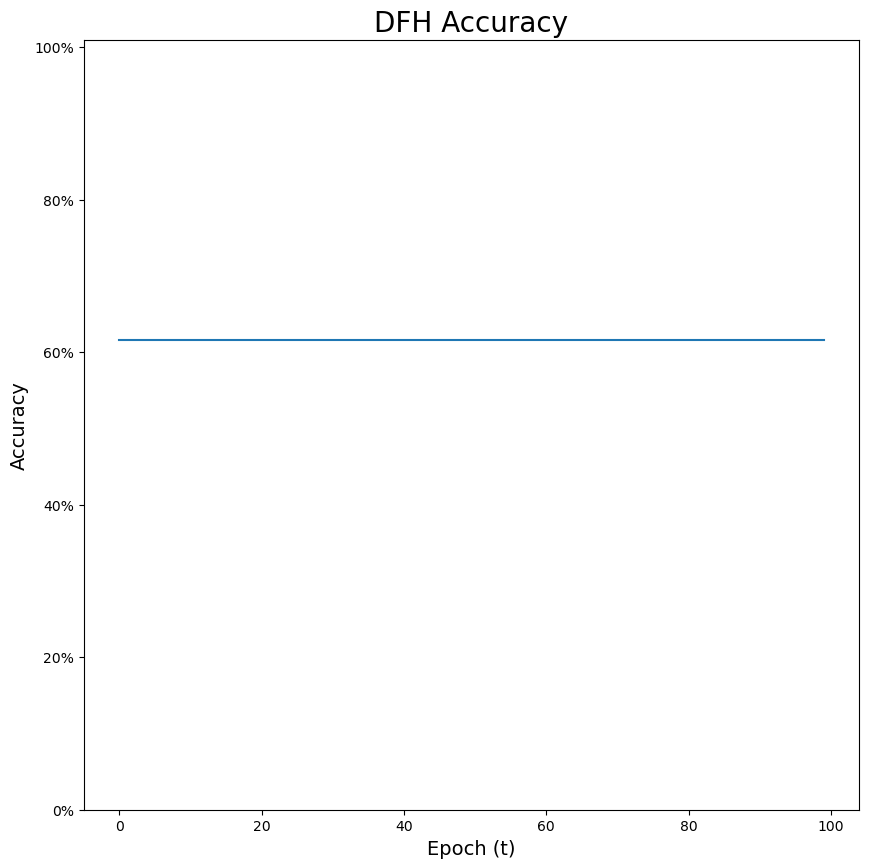

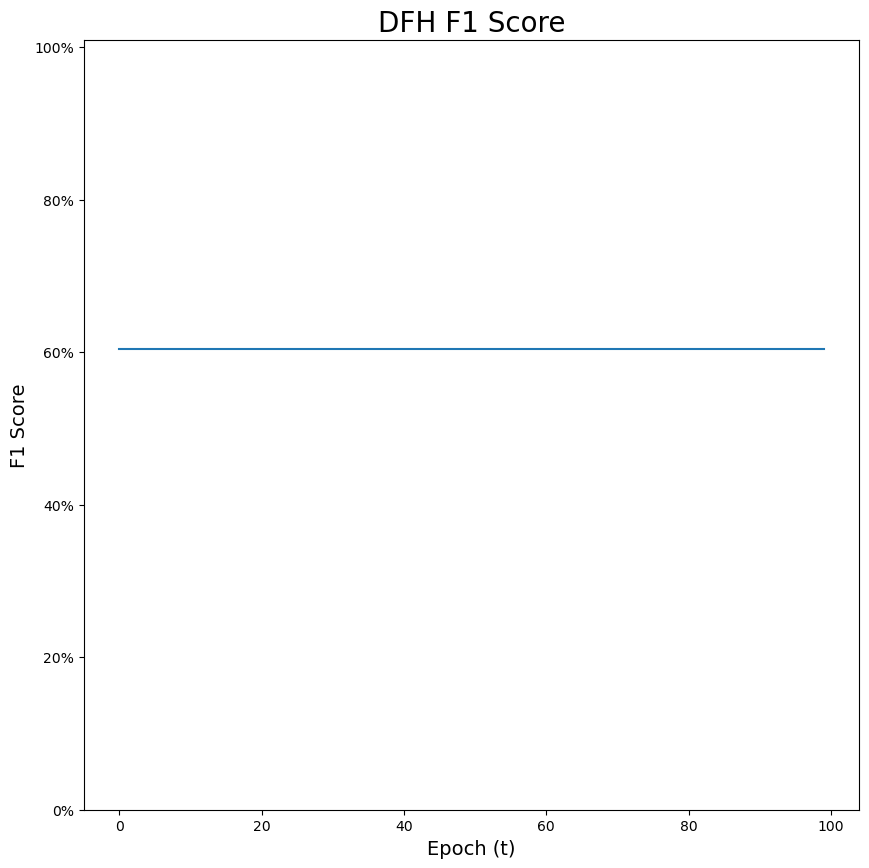

In [28]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)


##### 2-step lr = 0.03

In [29]:
learning_rate = 0.03
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


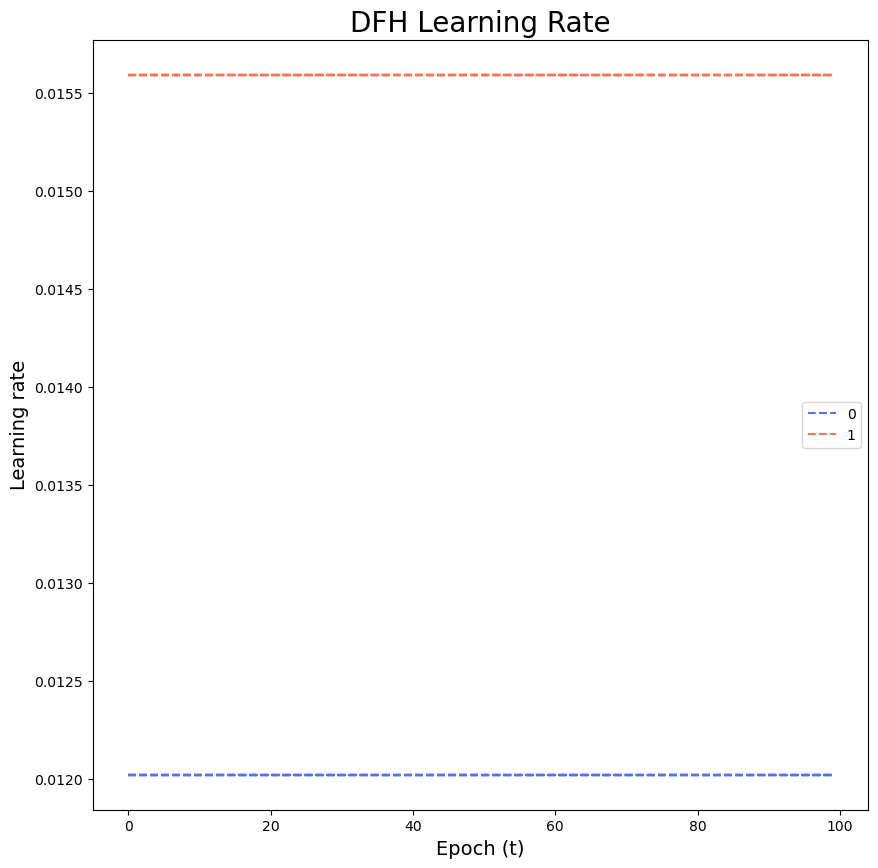

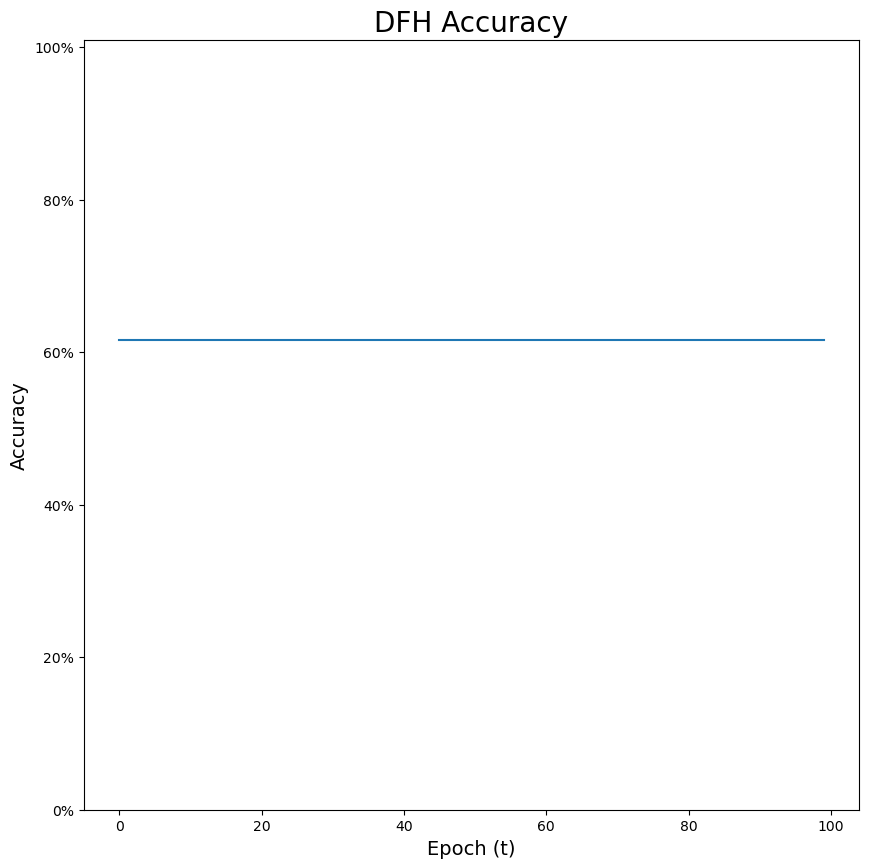

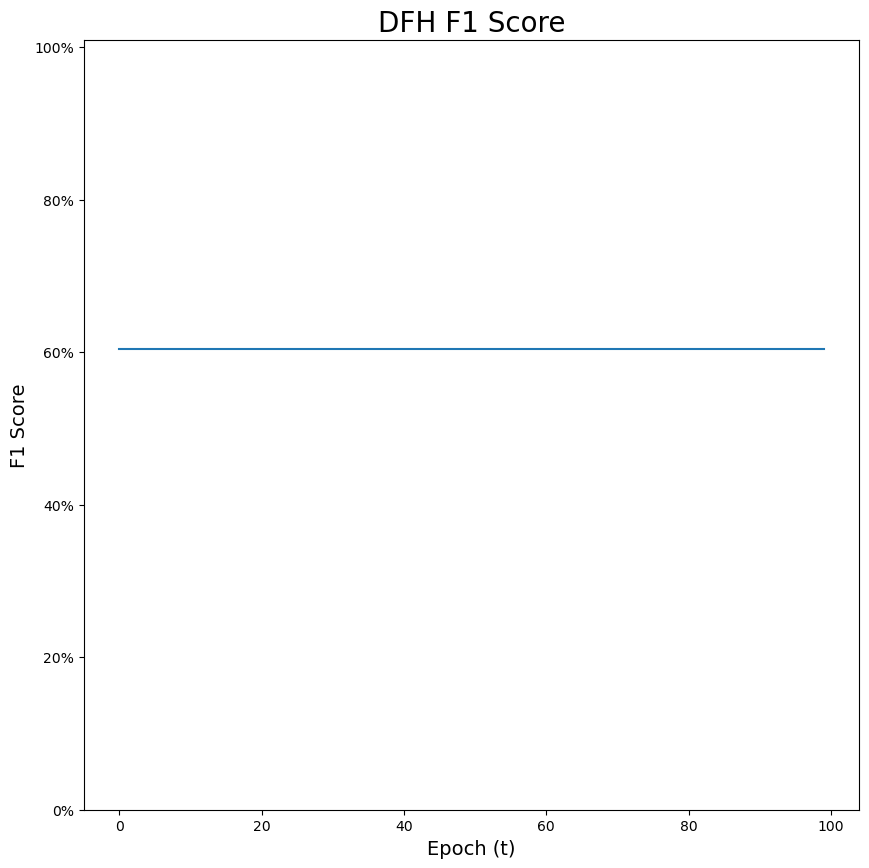

In [30]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)


##### 3-step lr = 0.01

In [31]:
learning_rate = 0.01
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


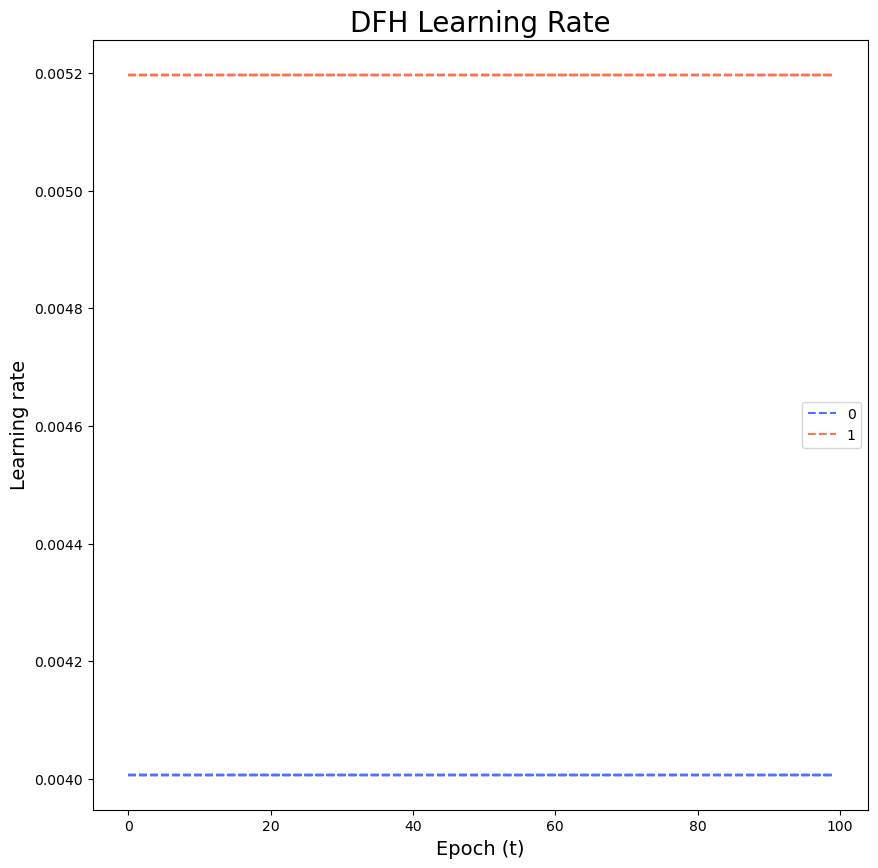

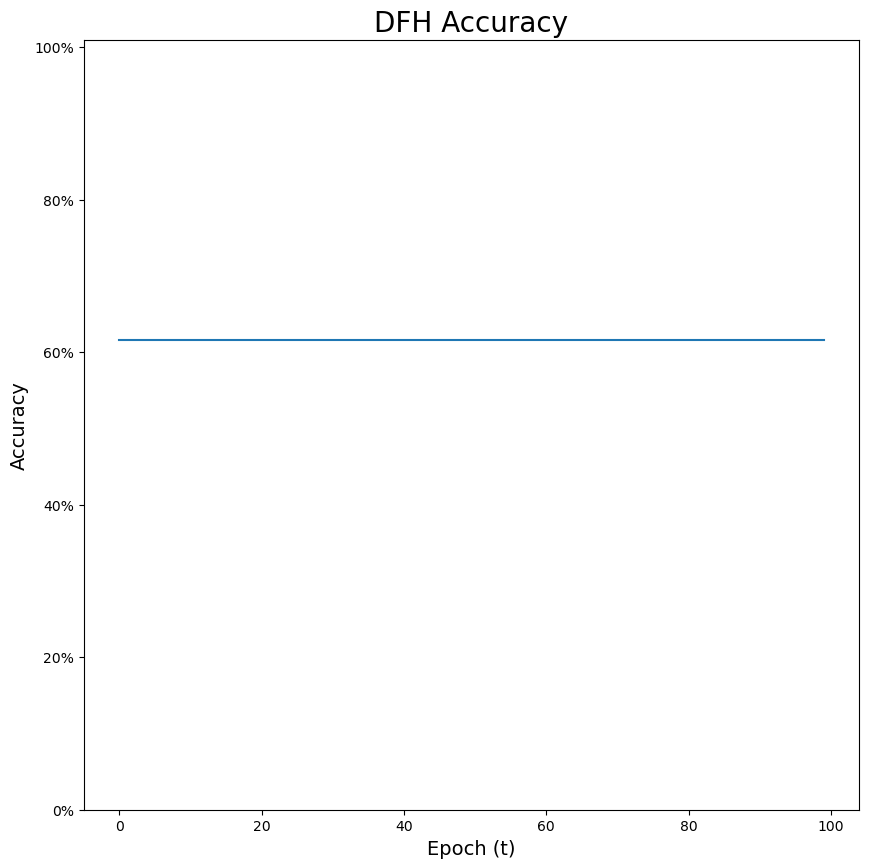

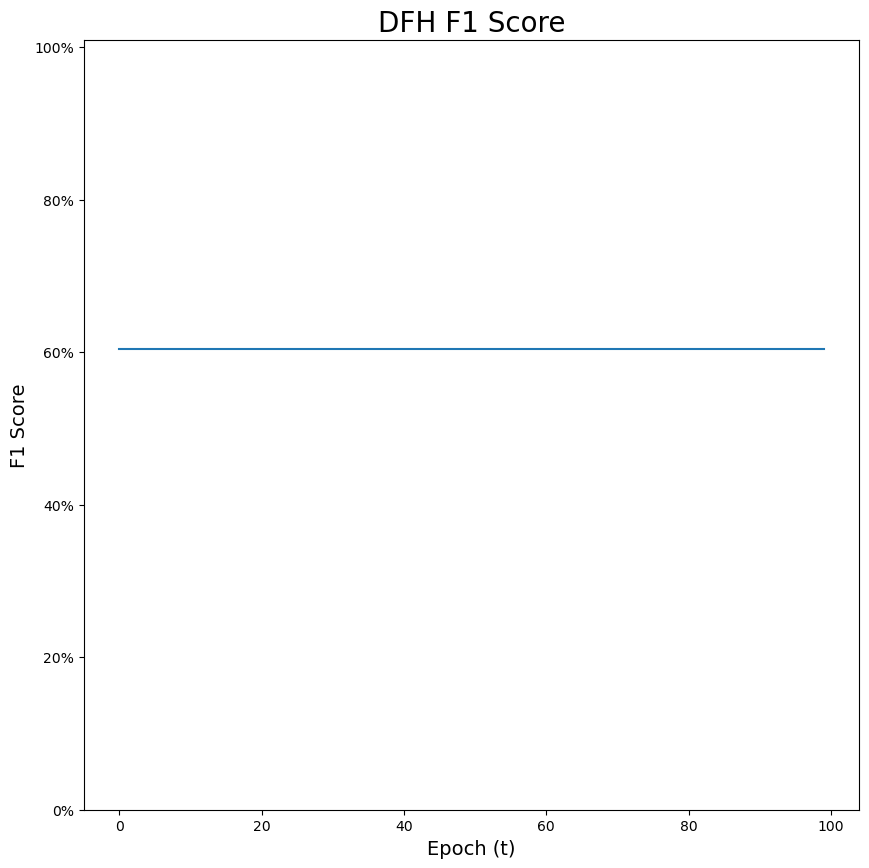

In [32]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)


##### MS

##### 1-step lr = 0.1

In [33]:
learning_rate = 0.1
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


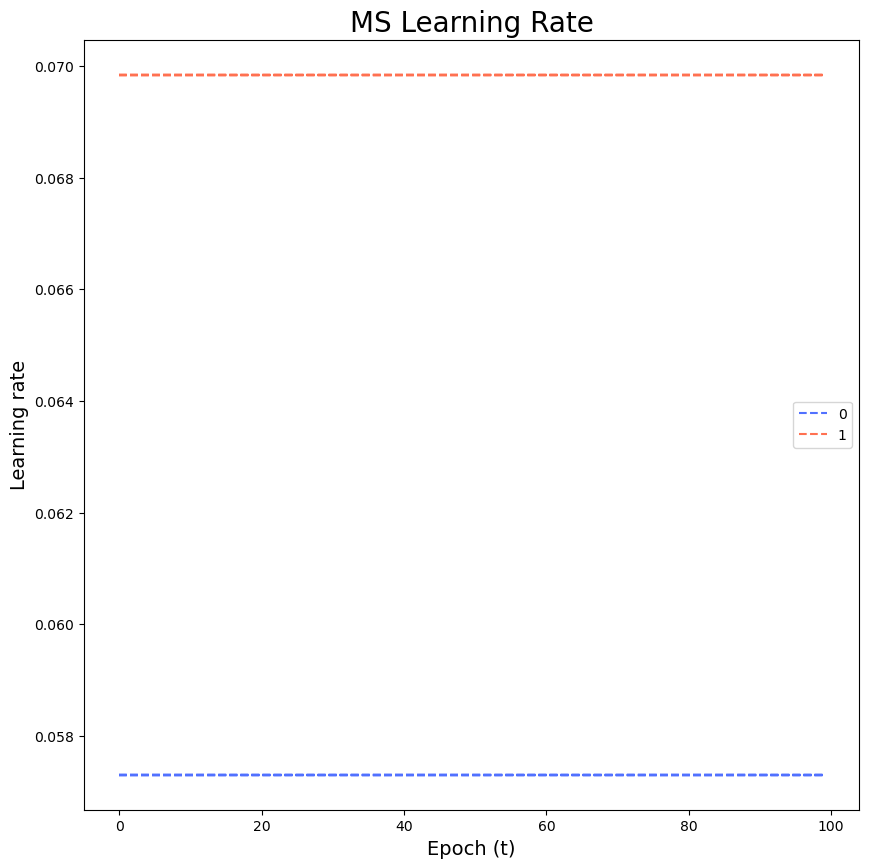

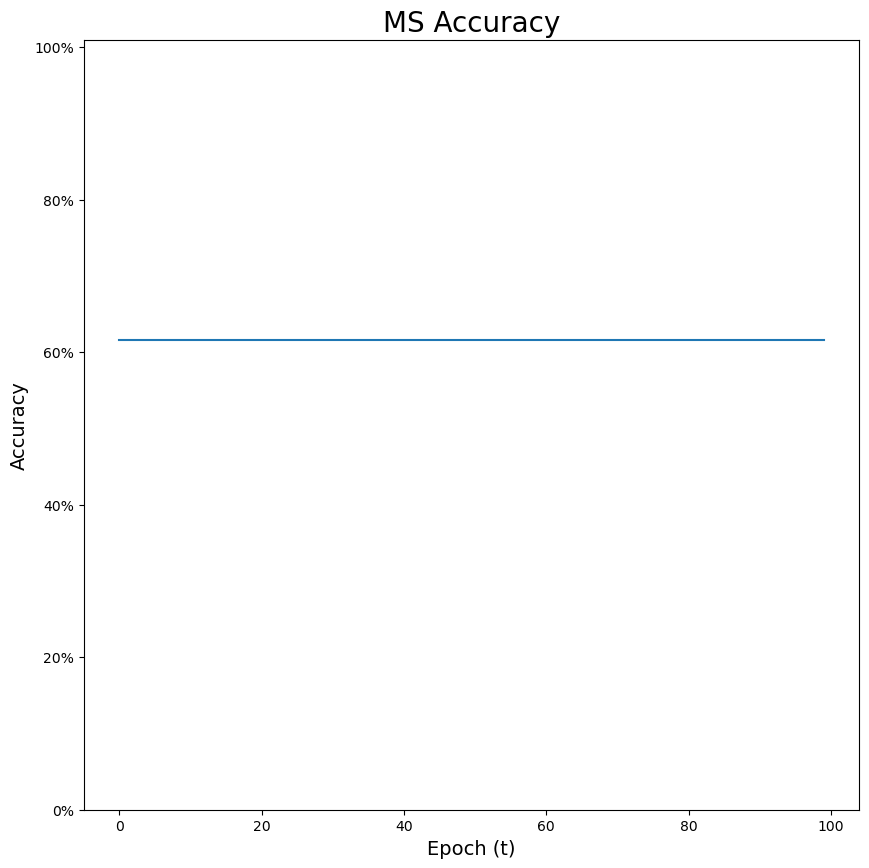

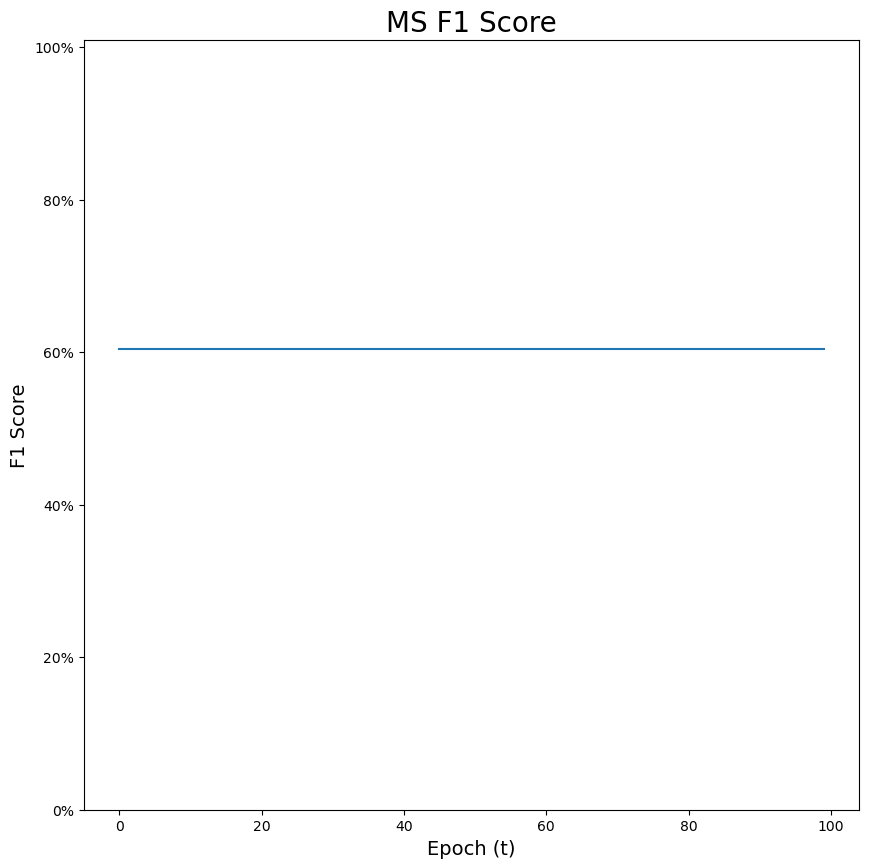

In [34]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)


##### 2-step lr = 0.03

In [35]:
learning_rate = 0.03
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


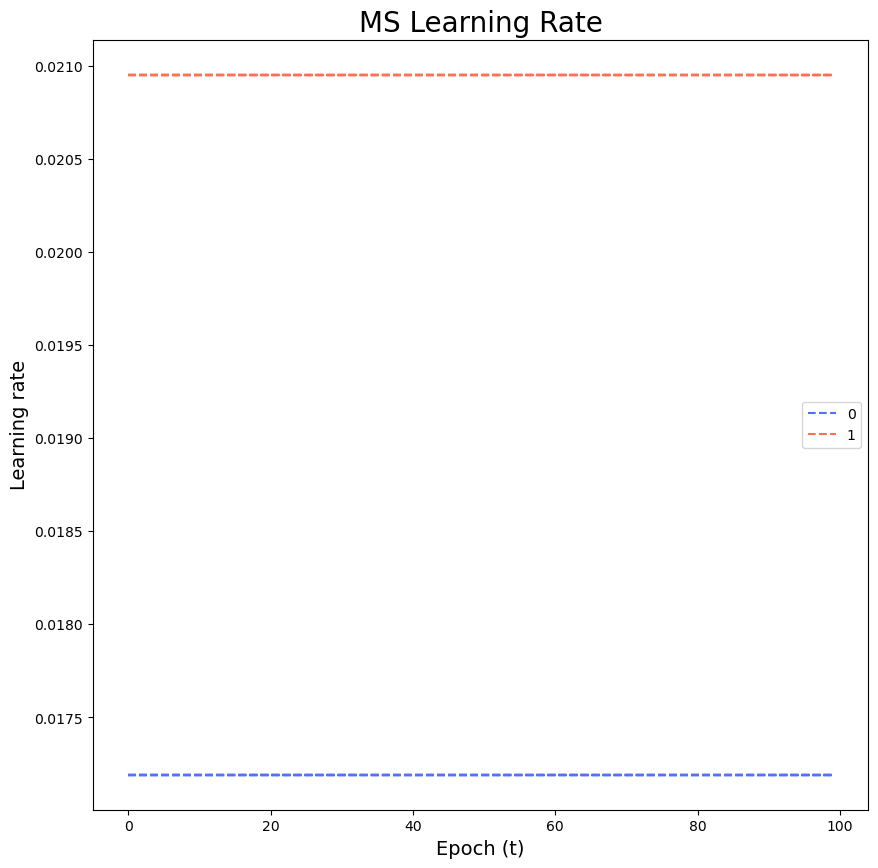

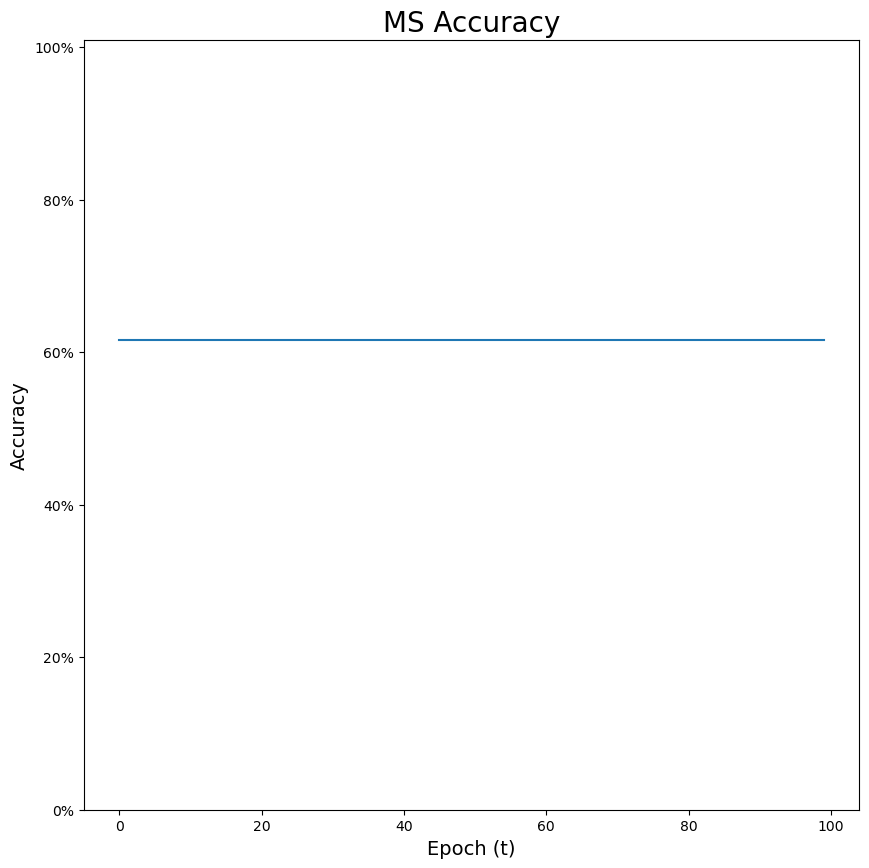

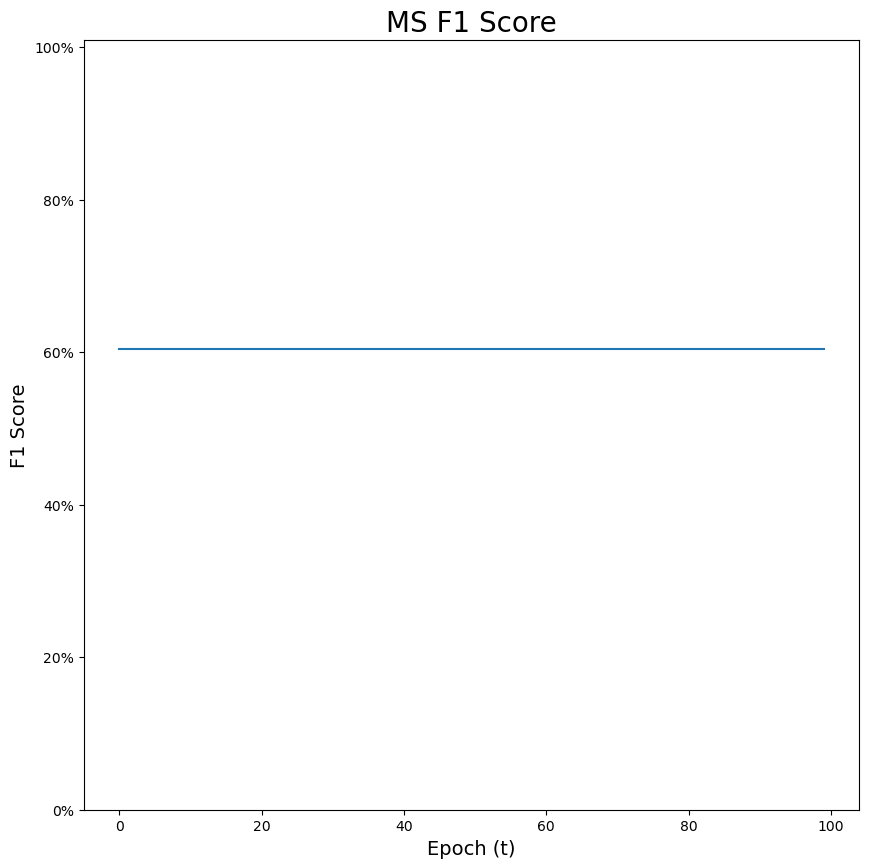

In [36]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)


##### 3-step lr = 0.01

In [37]:
learning_rate = 0.01
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


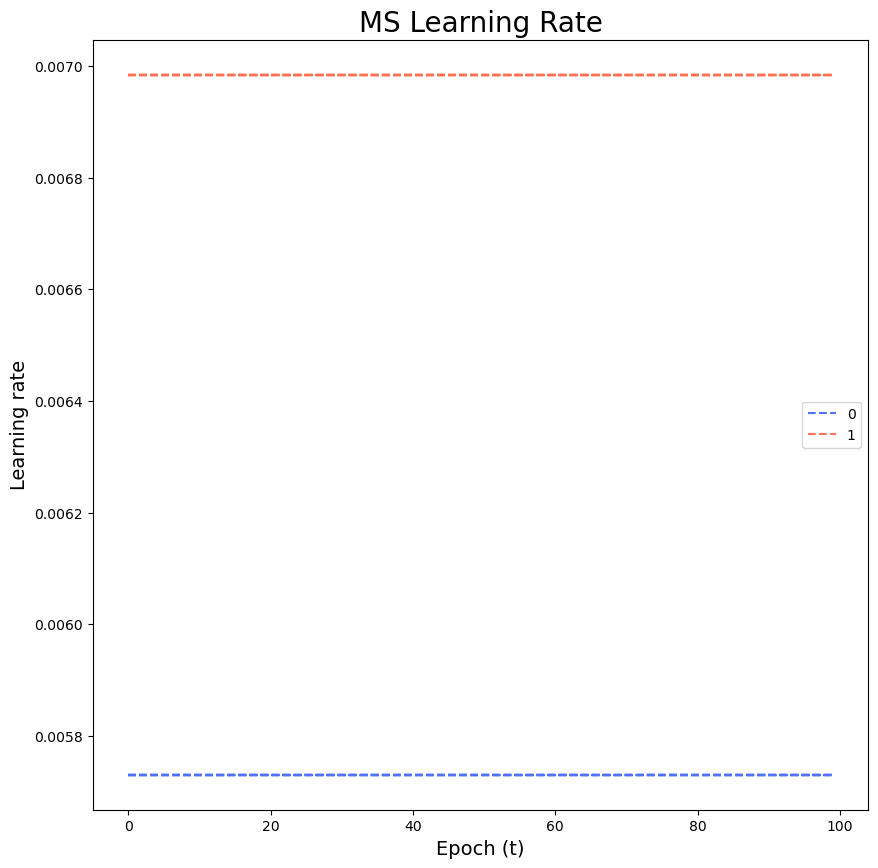

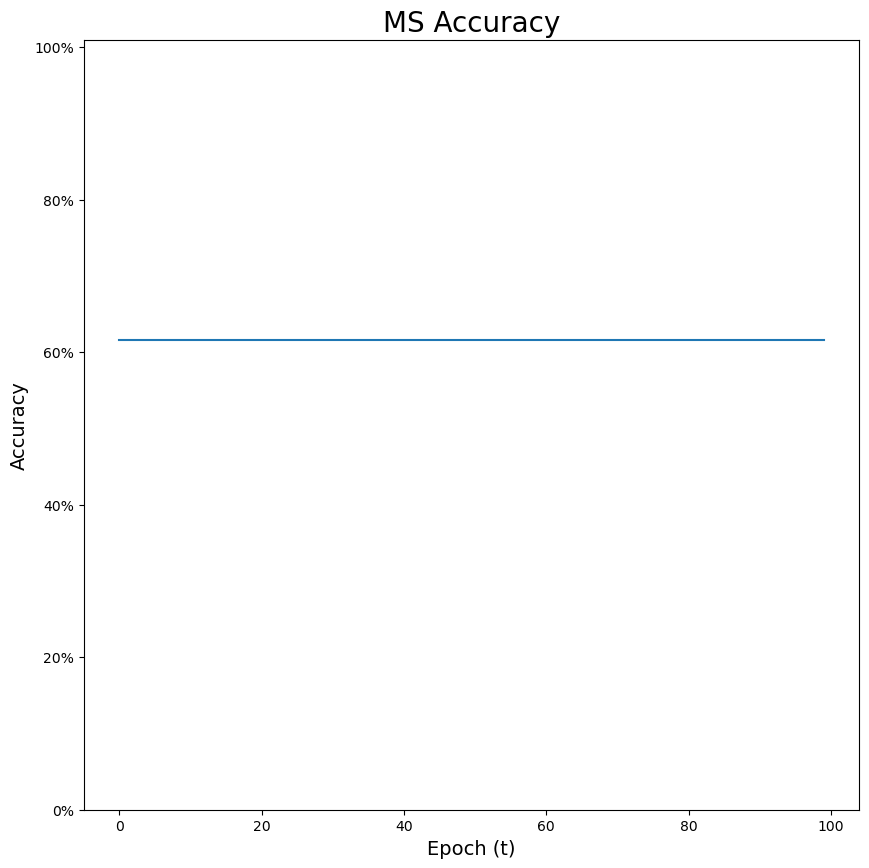

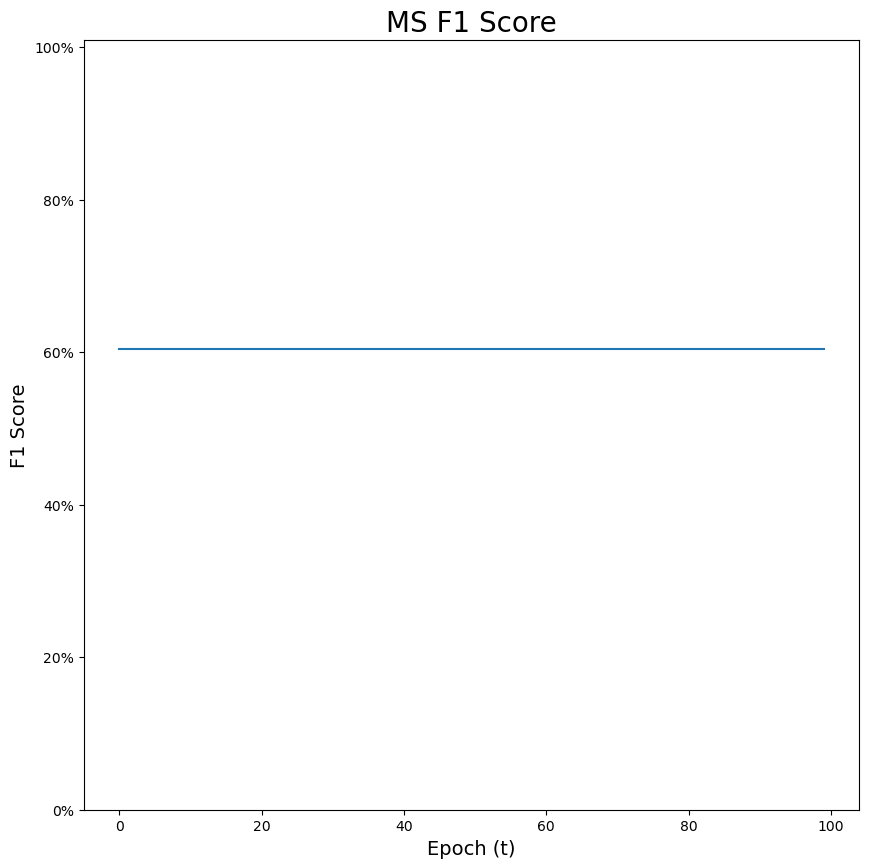

In [38]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)


##### LS

##### 1-step lr = 0.1

In [39]:
learning_rate = 0.1
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


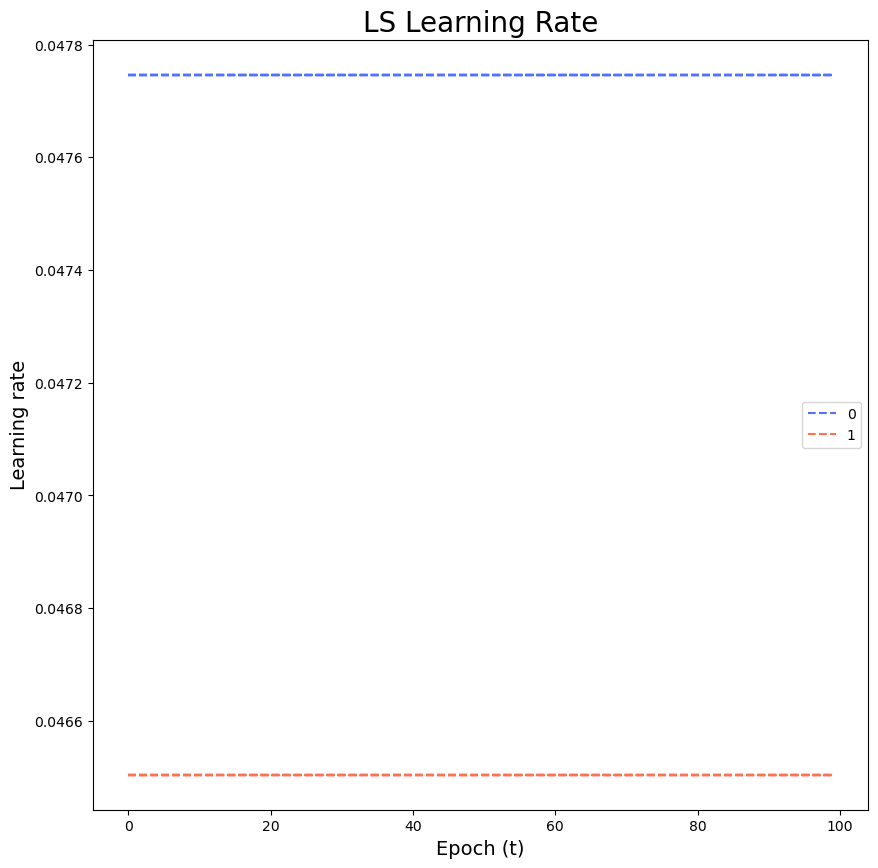

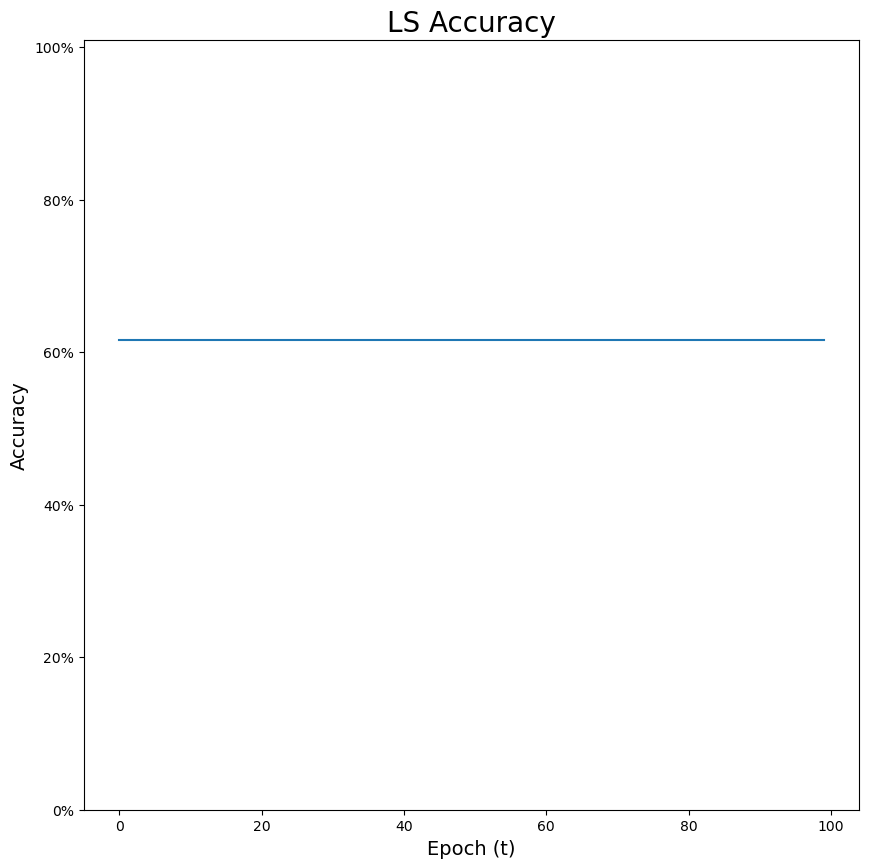

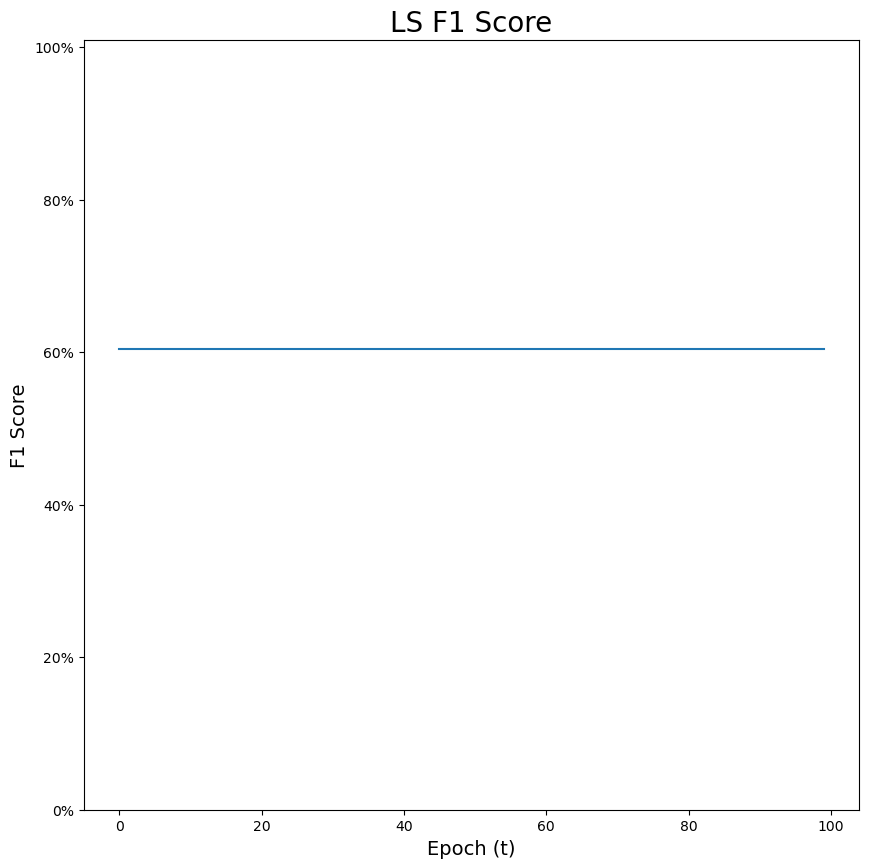

In [40]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)


##### 2-step lr = 0.03

In [41]:
learning_rate = 0.03
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


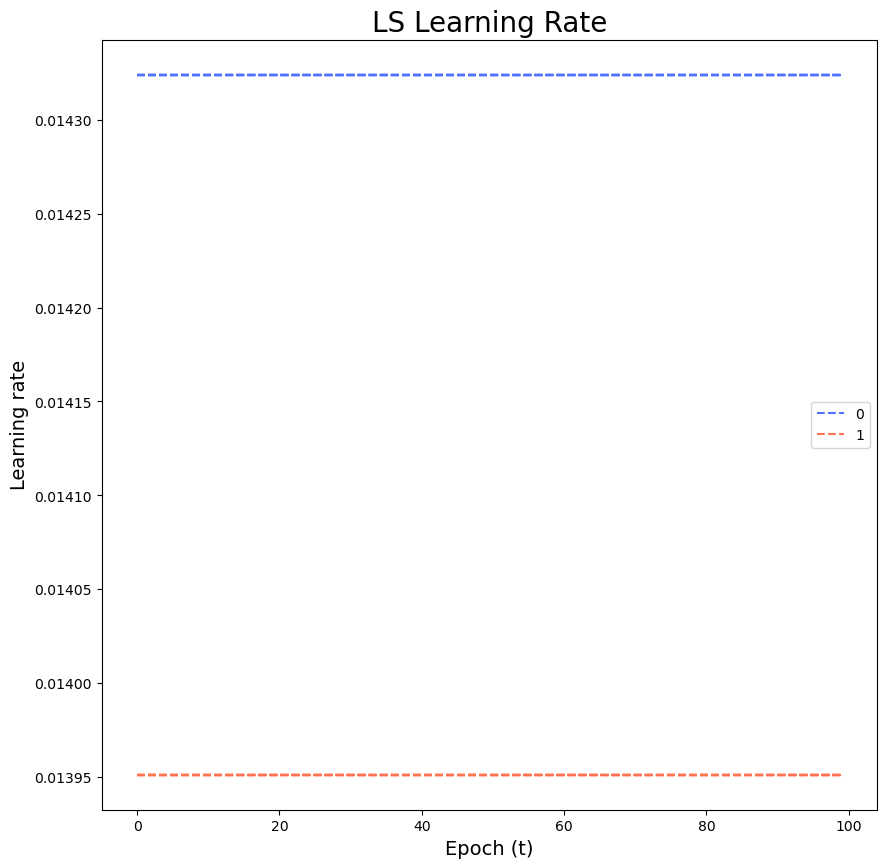

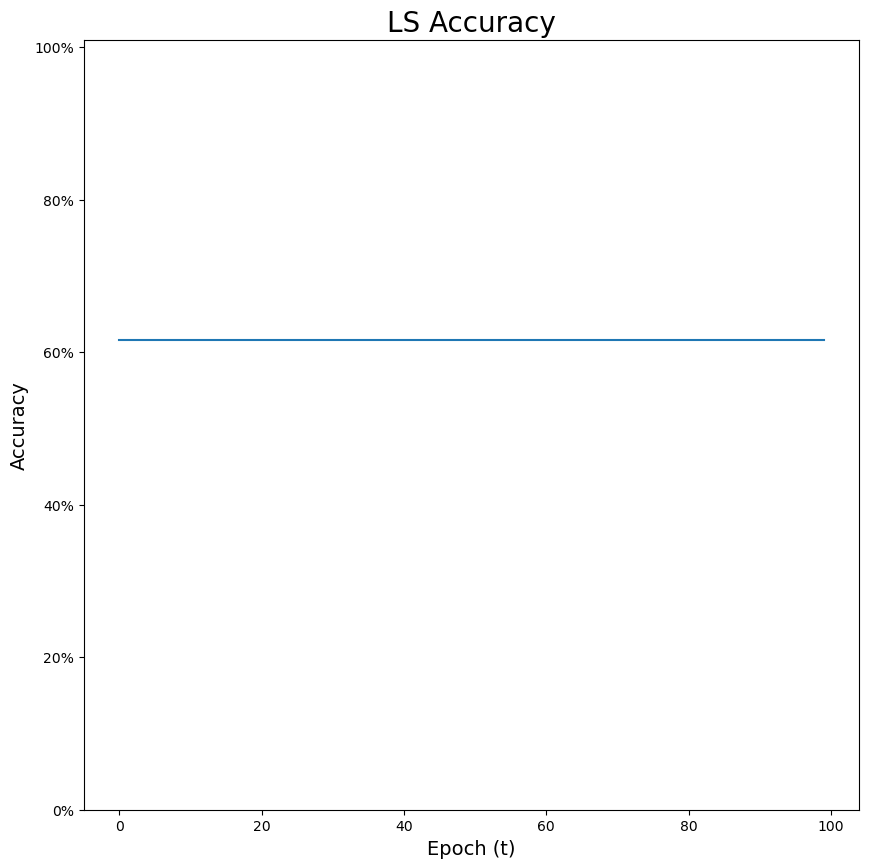

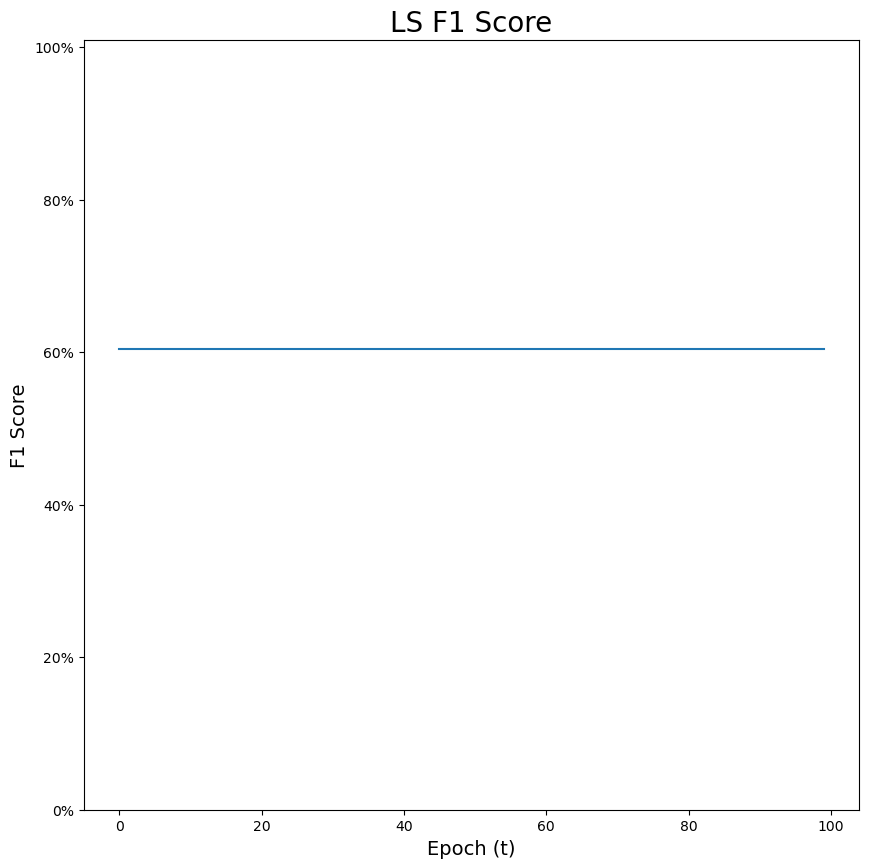

In [42]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)


##### 3-step lr = 0.01

In [43]:
learning_rate = 0.01
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


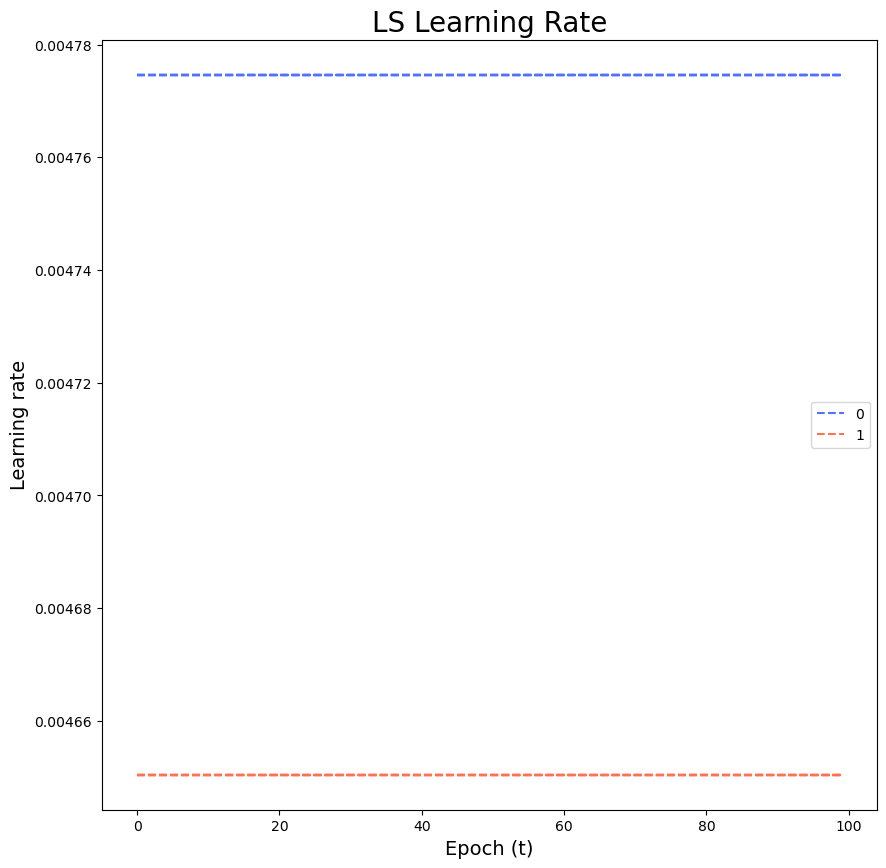

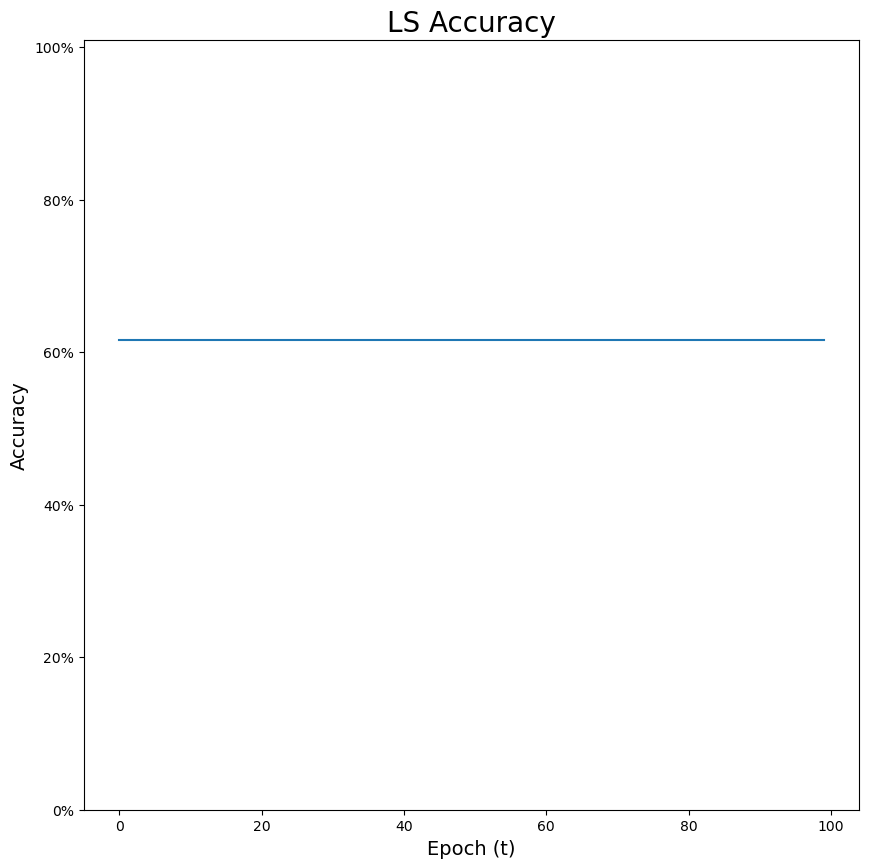

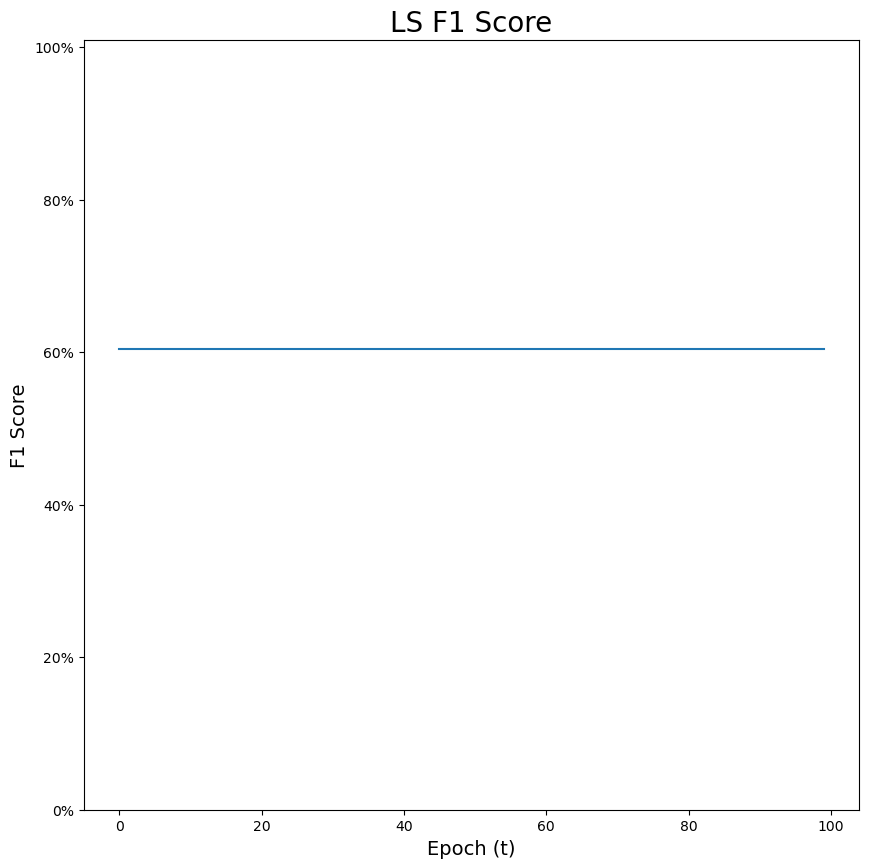

In [44]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)


##### LSR

##### 1-step lr = 0.1

In [45]:
learning_rate = 0.1
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


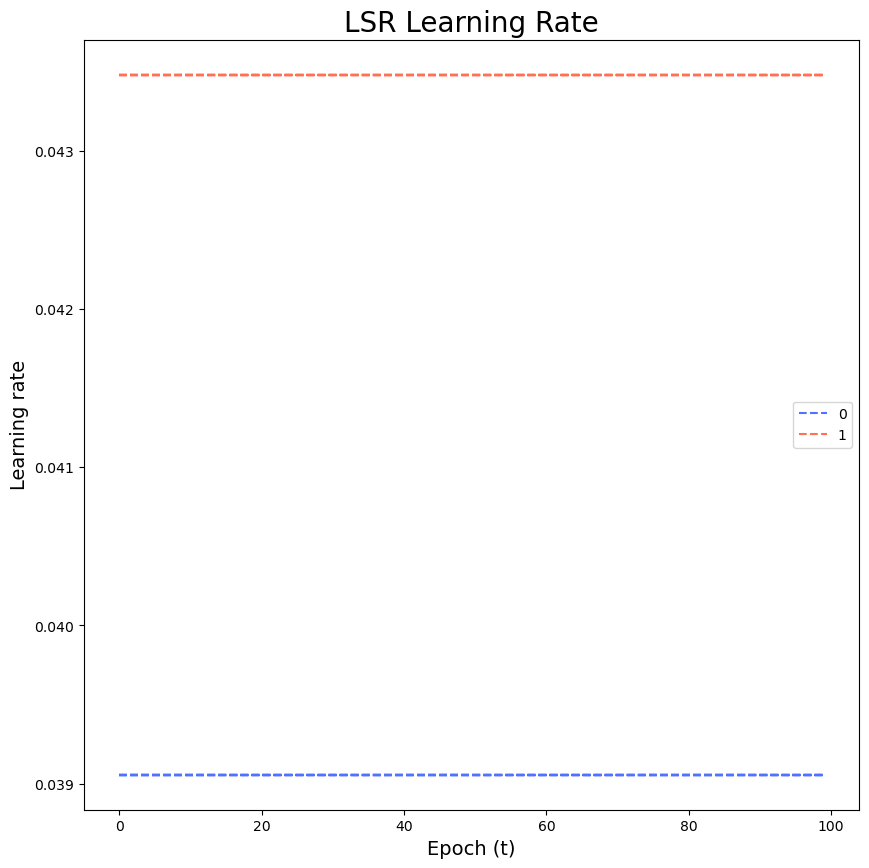

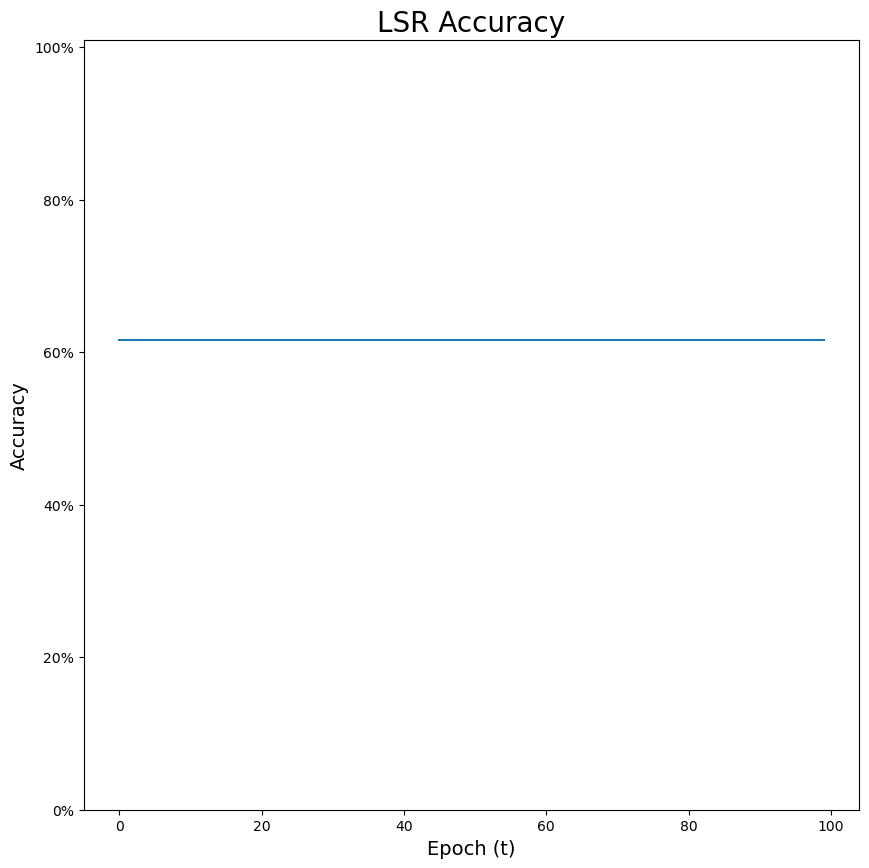

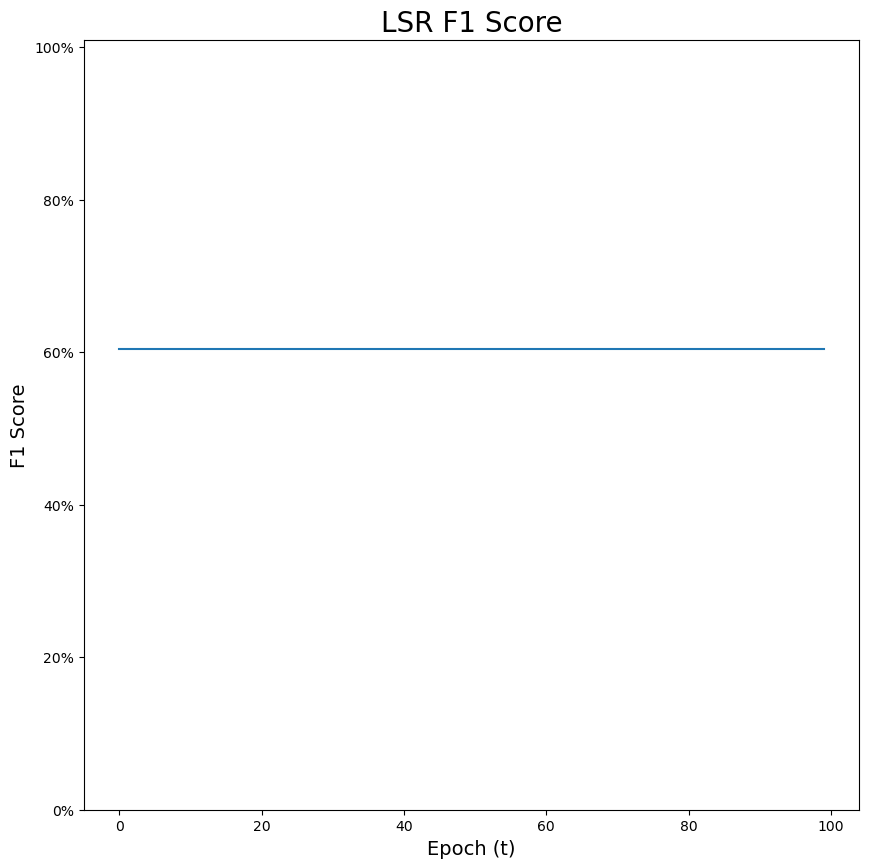

In [46]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)


##### 2-step lr = 0.03

In [47]:
learning_rate = 0.03
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


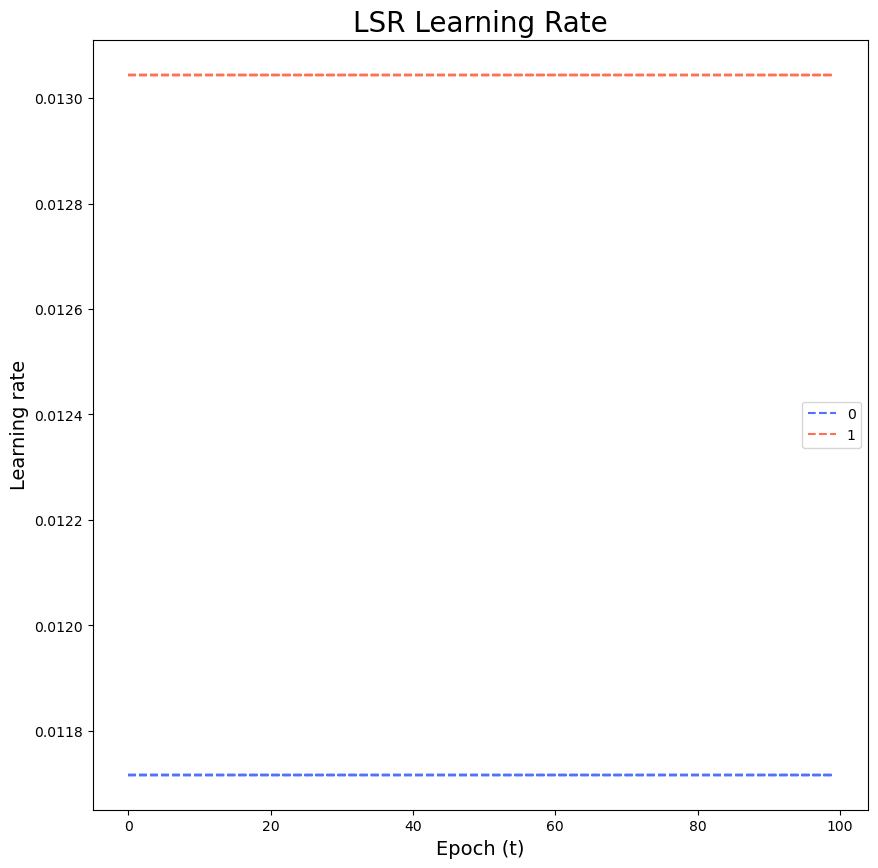

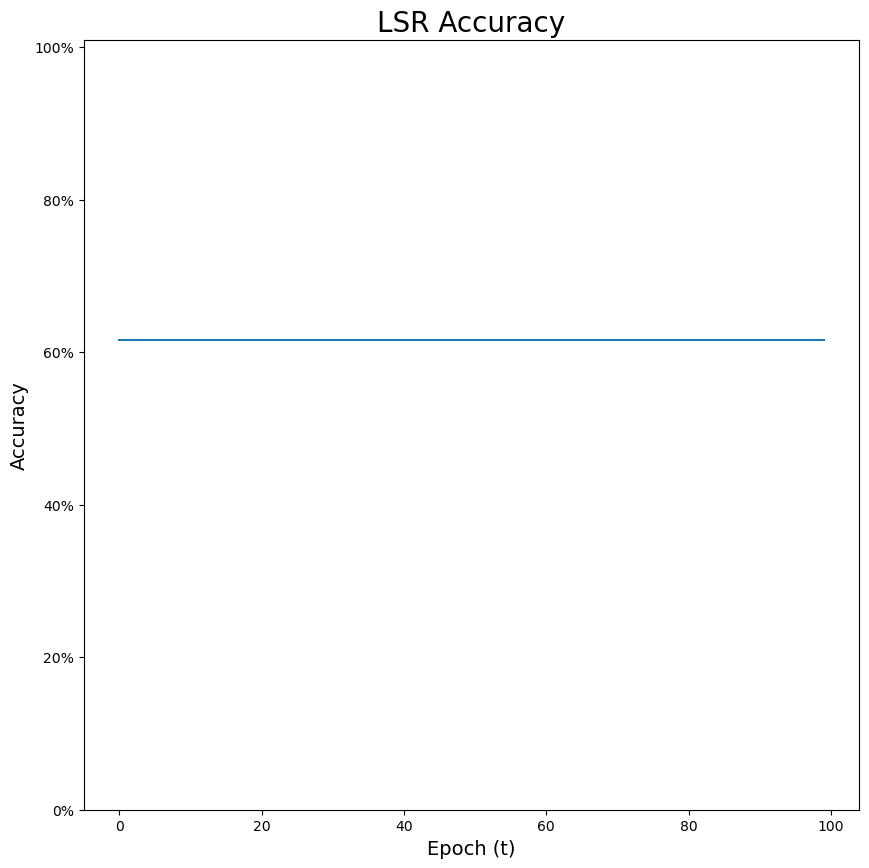

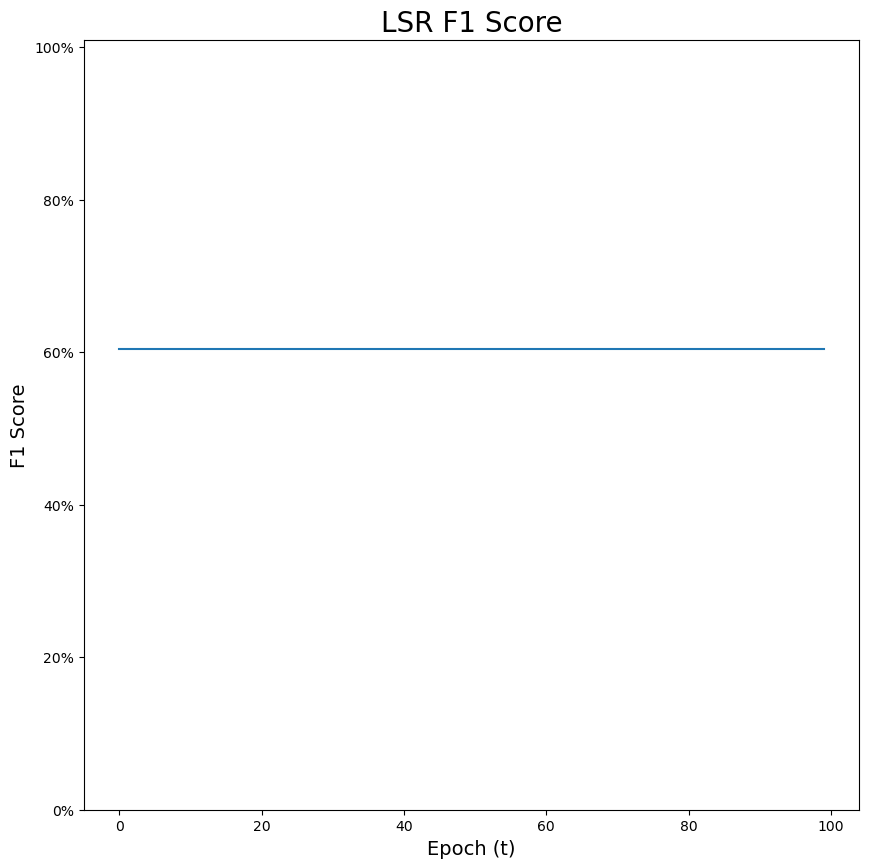

In [48]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)


##### 3-step lr = 0.01

In [49]:
learning_rate = 0.01
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 11, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 21, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 31, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 41, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 51, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 61, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 71, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 81, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %
Epoch: 91, Loss: 0.4806, Accuracy: 61.59 %, F_1_score: 60.50 %


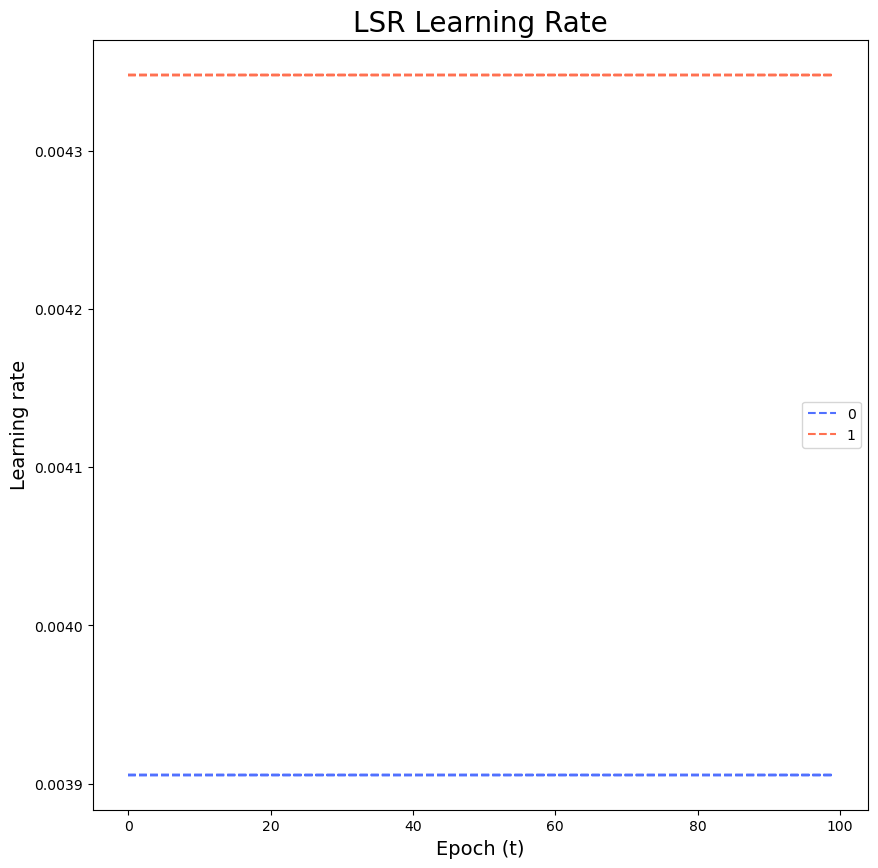

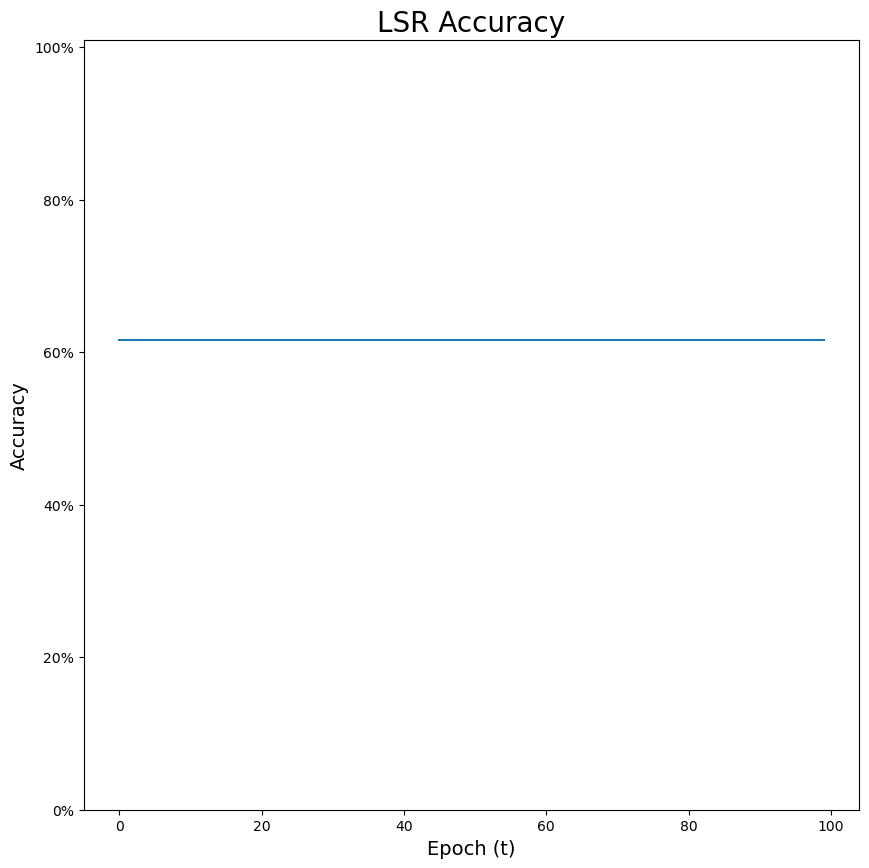

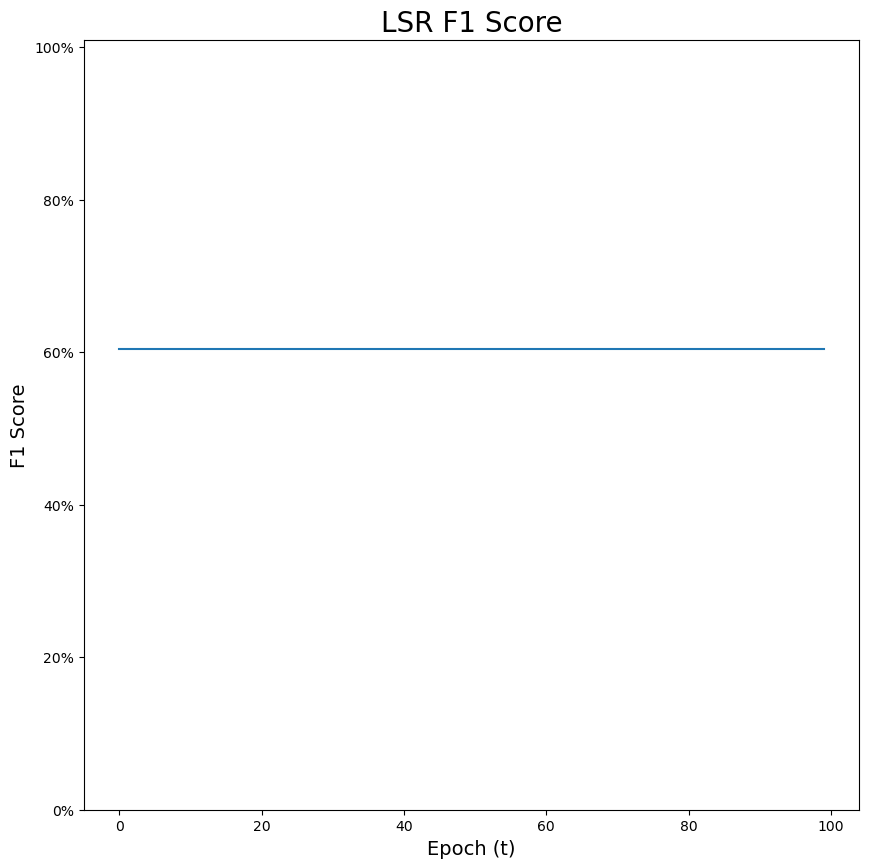

In [50]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)


##### F1 Score

In [51]:
experiment = "experiment_2"


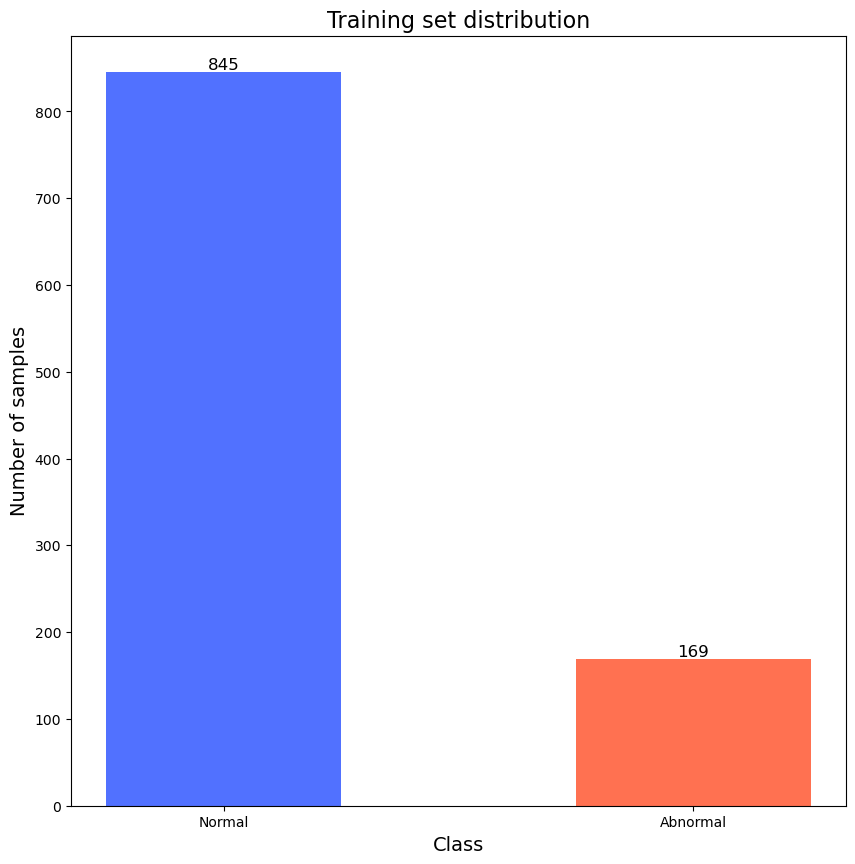

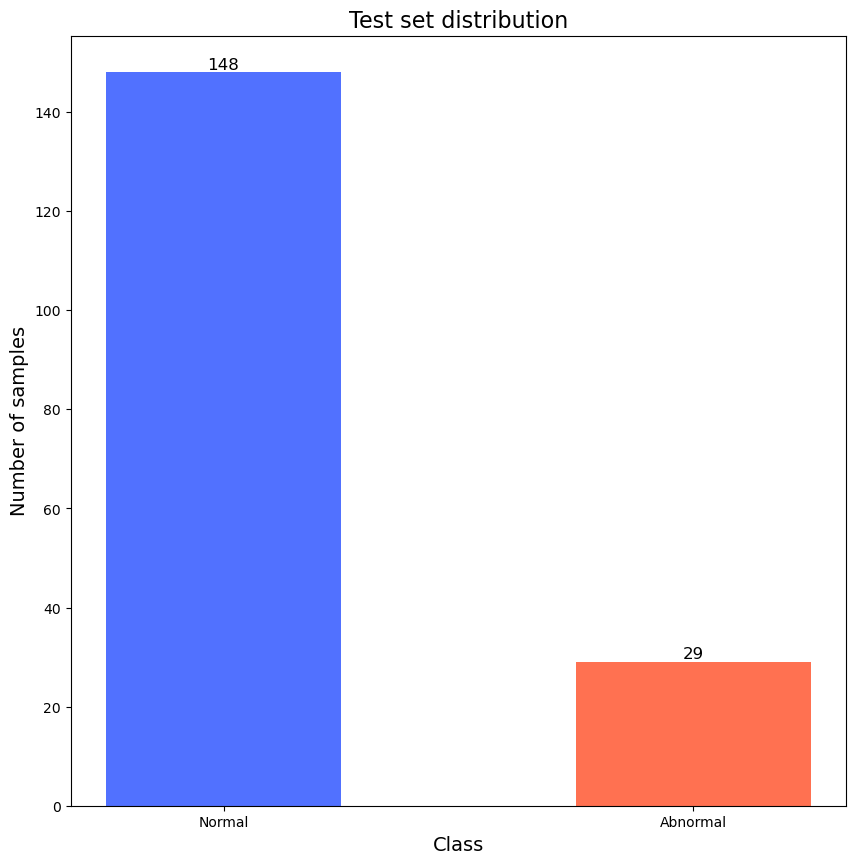

In [52]:

# Select 20% of #sample-1 as #sample-2
max_data = max(count) - num_prototypes
data_per_class = [max_data, int(max_data / 5)]
test_percentage = 0.15
test_size = list(map(lambda data: int(data * test_percentage), data_per_class))
train_size = [data - test for data, test in zip(data_per_class, test_size)]
feature_f1 = copy.deepcopy(feature)
label_f1 = copy.deepcopy(label)

## Select test set
test_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size[j])
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_fscore = [(feature_f1[i], label_f1[i]) for i in test_index]
random.shuffle(test_set_fscore)
unique, counts = np.unique(label_f1[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_f1 = np.delete(feature_f1, test_index, axis=0)
label_f1 = np.delete(label_f1, test_index, axis=0)

## Select train set
train_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size[j])
    train_index += index_i_sample
train_index.sort(reverse=True)
train_set_fscore = [(feature_f1[i], label_f1[i]) for i in train_index]
random.shuffle(train_set_fscore)
unique, counts = np.unique(label_f1[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    if k == 0:
        label_name = "Normal"
    else:
        label_name = "Abnormal"
    ax.bar(label_name, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Training set distribution", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/train_dist.png", dpi=300)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    if k == 0:
        label_name = "Normal"
    else:
        label_name = "Abnormal"
    ax.bar(label_name, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=12)
plt.title("Test set distribution", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/test_dist.png", dpi=300)


#### Train the Models

In [53]:
num_epochs = 100


##### GLVQ

##### 1-step lr =0.1

In [54]:
learning_rate = 0.1
glvq_fscore = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)

Epoch: 1, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 11, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 21, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 31, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 41, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 51, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 61, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 71, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 81, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 91, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %


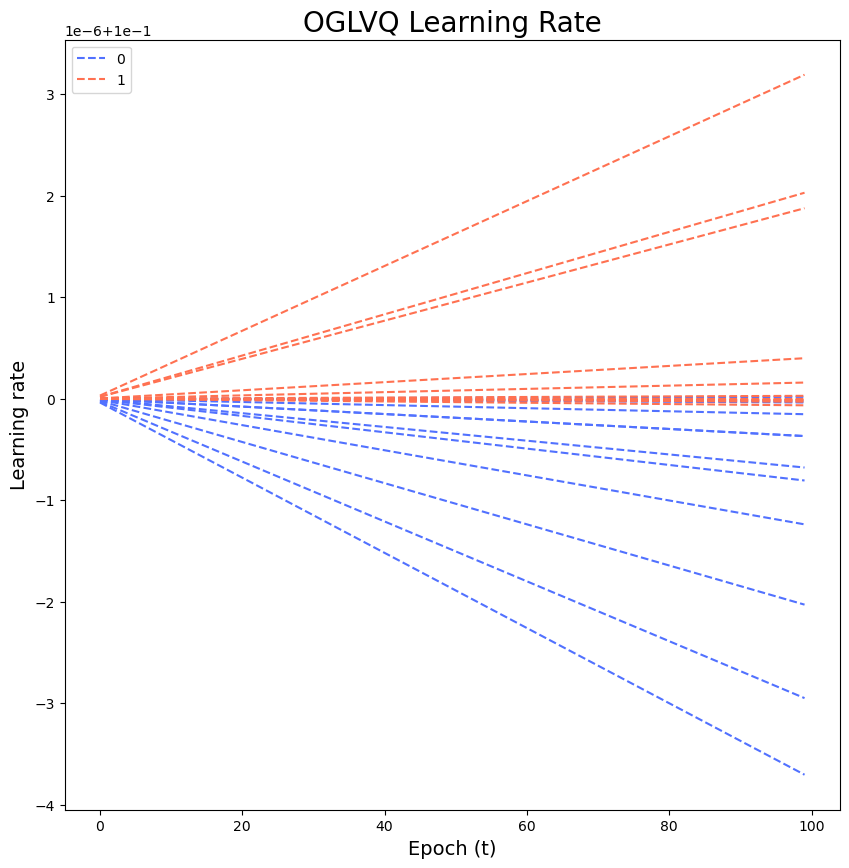

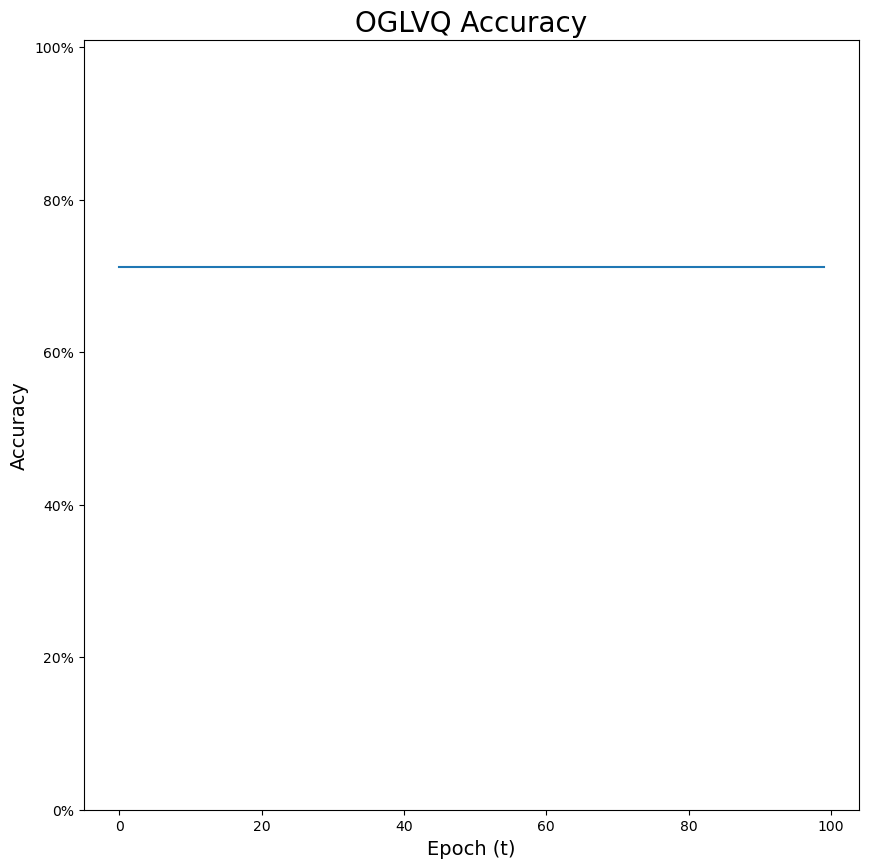

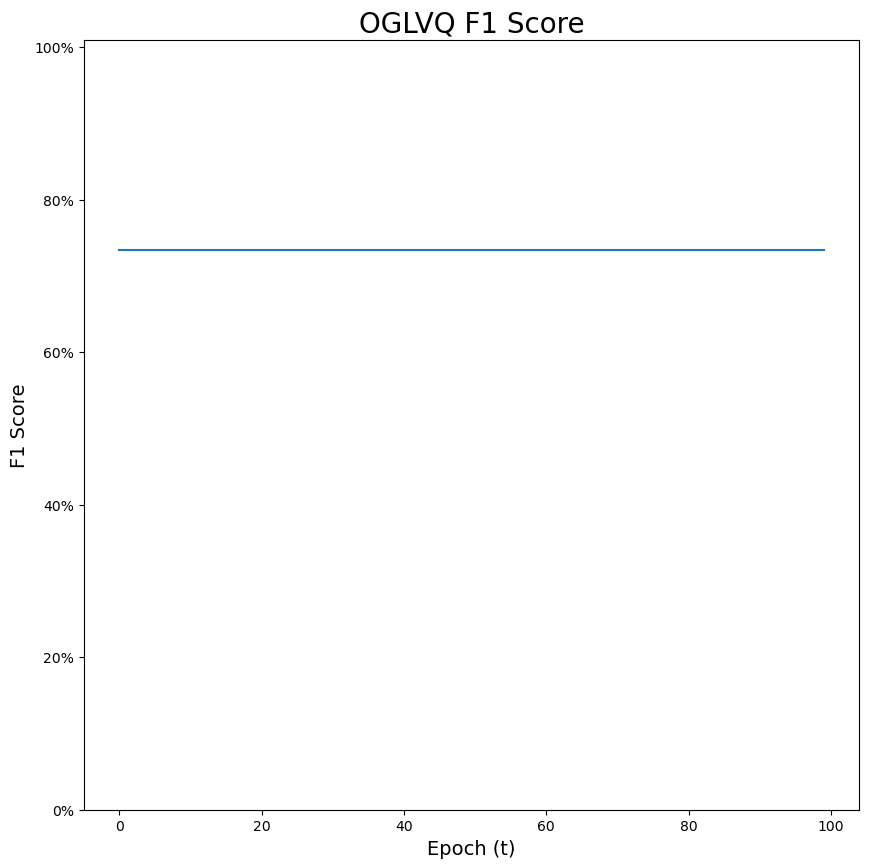

In [55]:
save_figs(glvq_fscore, experiment, "OGLVQ", learning_rate)


##### 2-step lr = 0.03

In [56]:
learning_rate = 0.03
glvq_fscore = glvq.GLVQ(
    prototypes,
    learning_rate,
)
hist = glvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)

Epoch: 1, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 11, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 21, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 31, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 41, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 51, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 61, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 71, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 81, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 91, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %


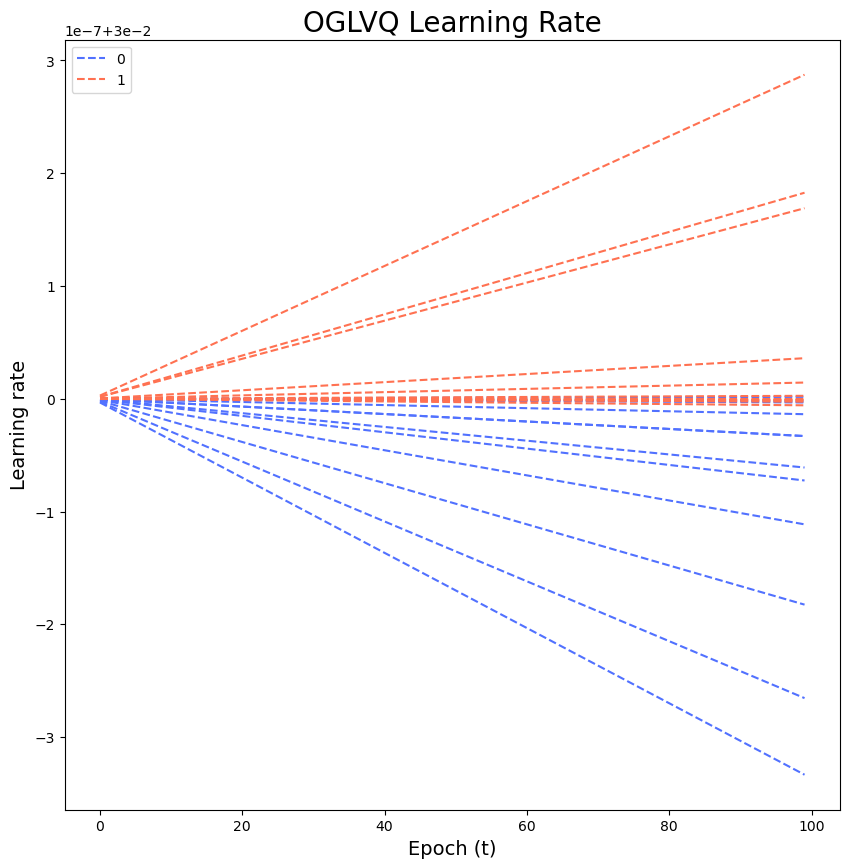

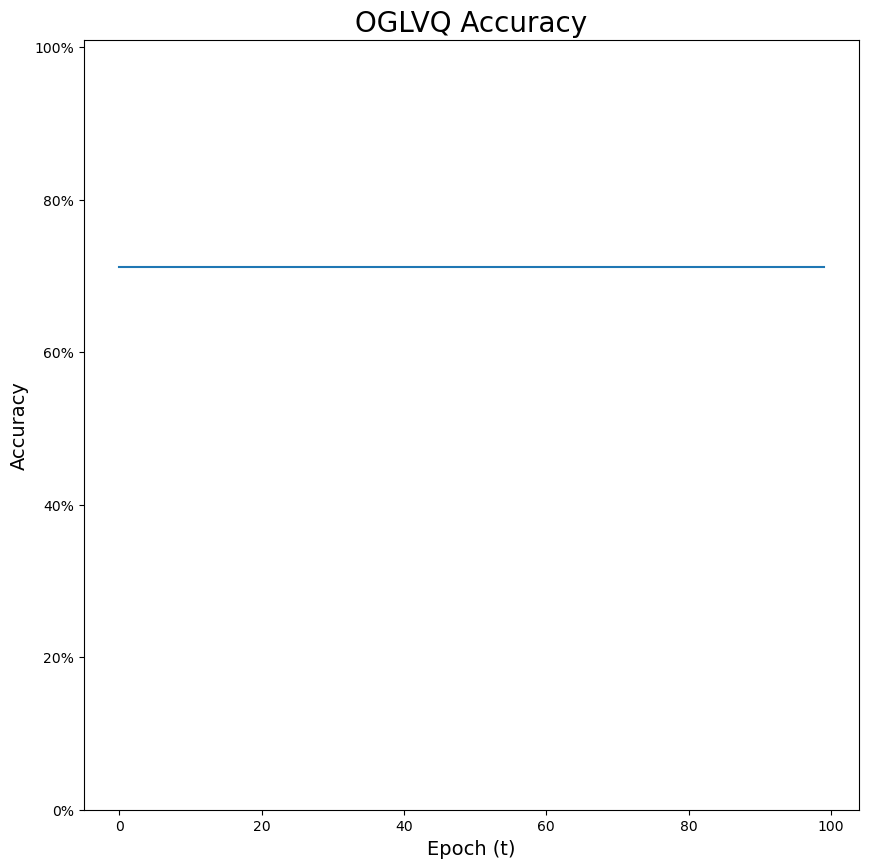

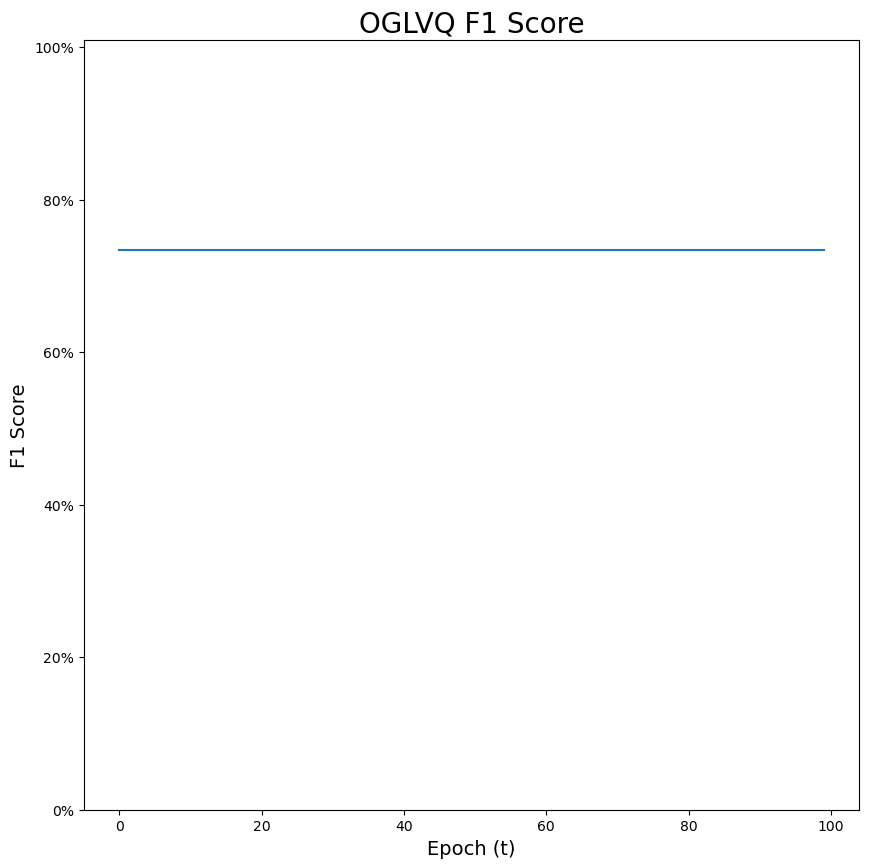

In [57]:
save_figs(glvq_fscore, experiment, "OGLVQ", learning_rate)


##### 3-step lr = 0.01

In [58]:
learning_rate = 0.01
glvq_fscore = glvq.GLVQ(prototypes, learning_rate)
hist = glvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)

Epoch: 1, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 11, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 21, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 31, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 41, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 51, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 61, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 71, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 81, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %
Epoch: 91, Loss: 470.5982, Accuracy: 71.19 %, F_1.0_score: 73.43 %


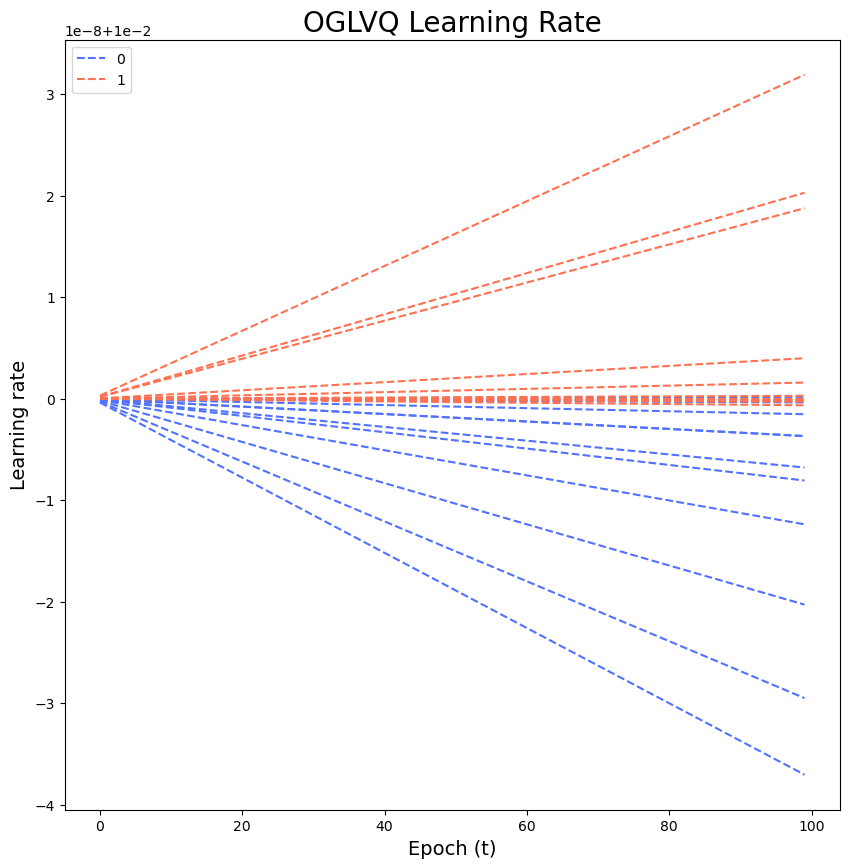

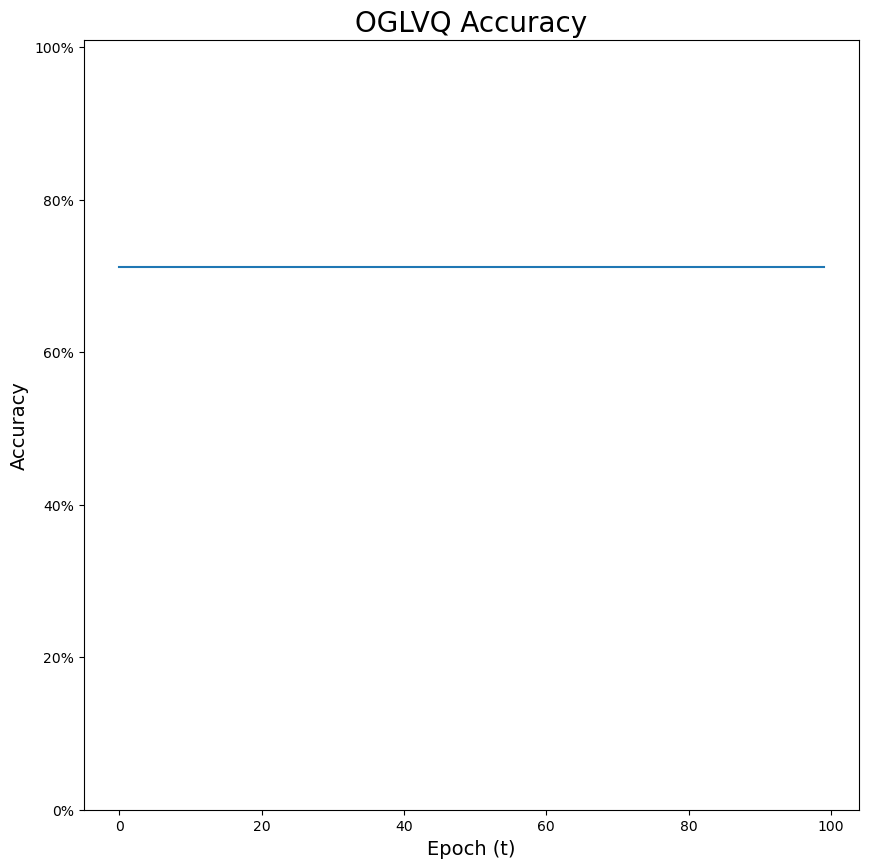

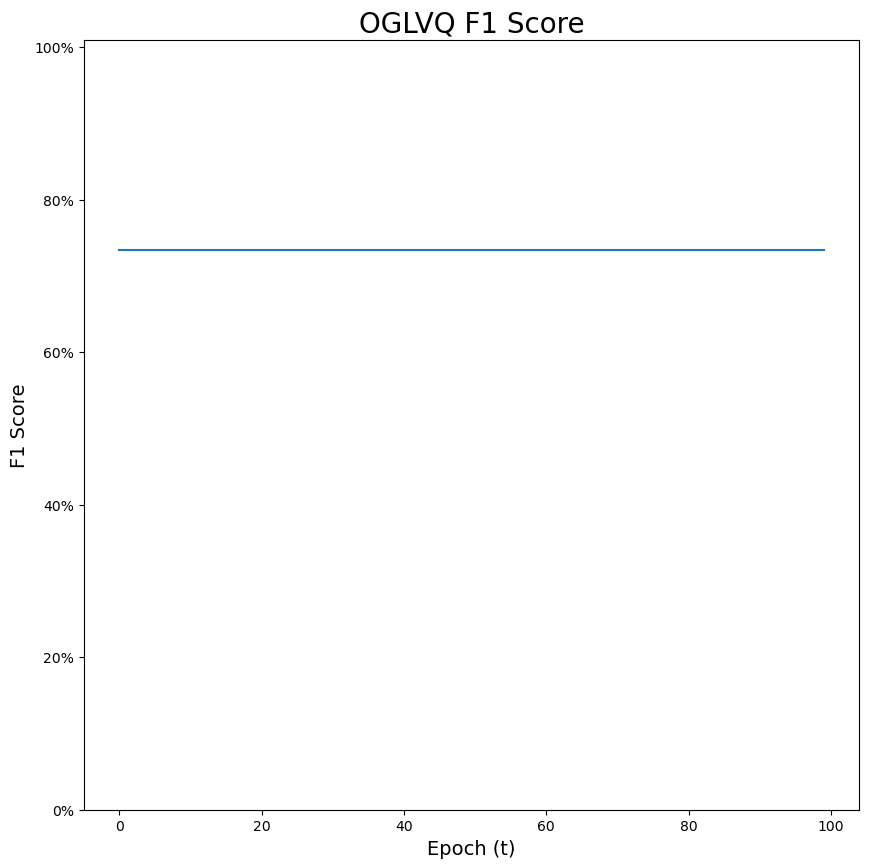

In [59]:
save_figs(glvq_fscore, experiment, "OGLVQ", learning_rate)


##### CP

##### 1-step lr = 0.1

In [60]:
learning_rate = 0.1
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


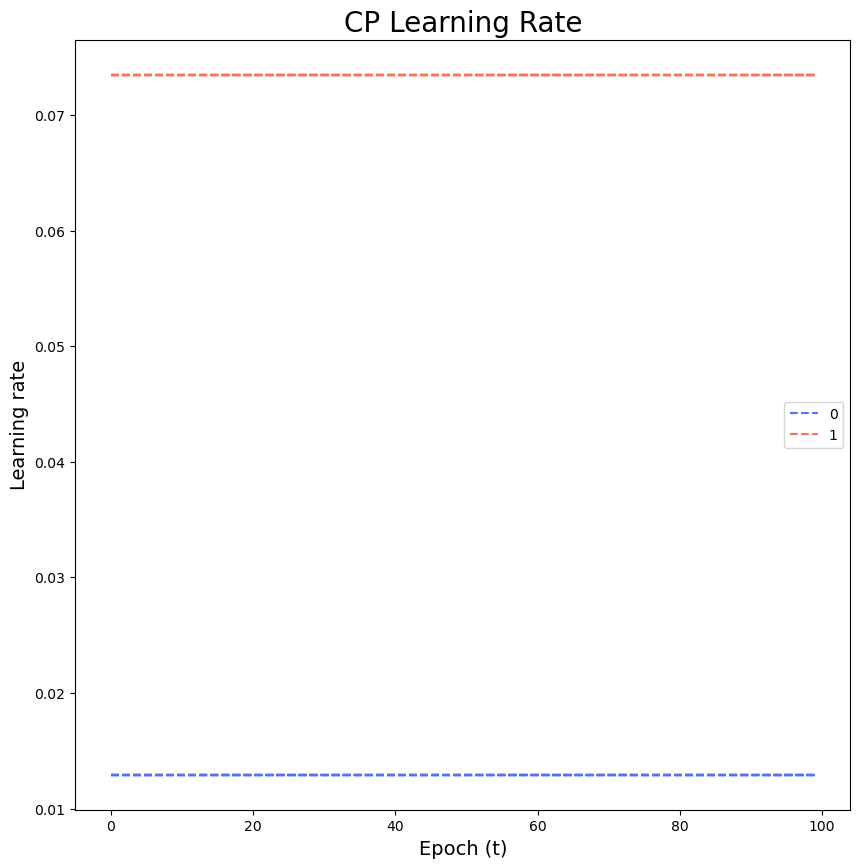

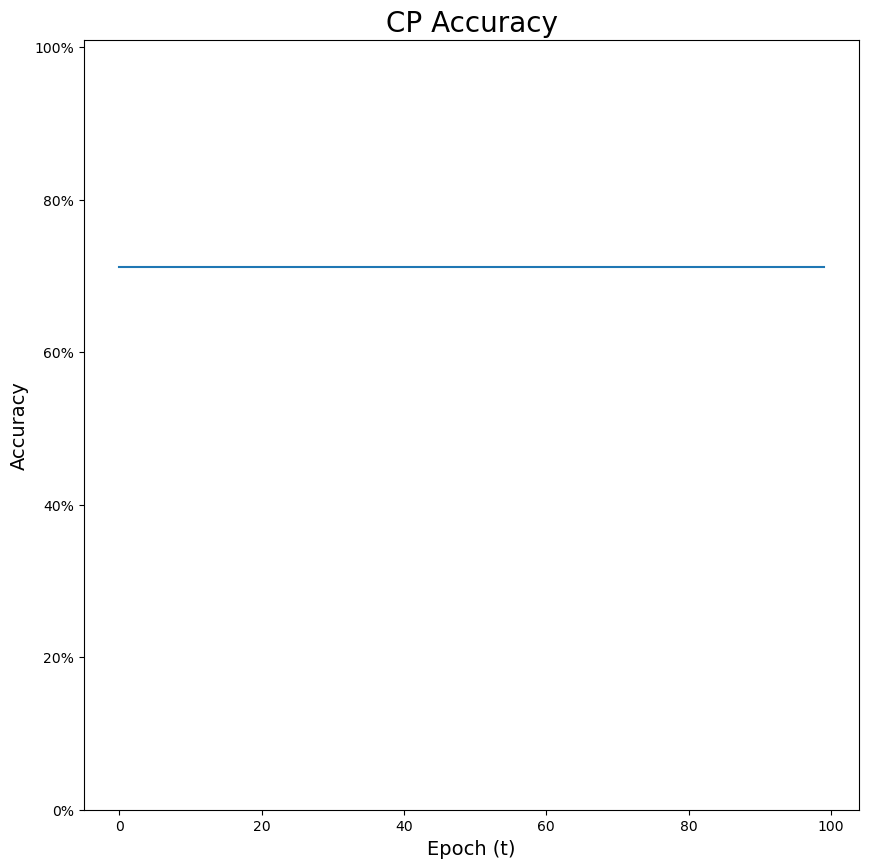

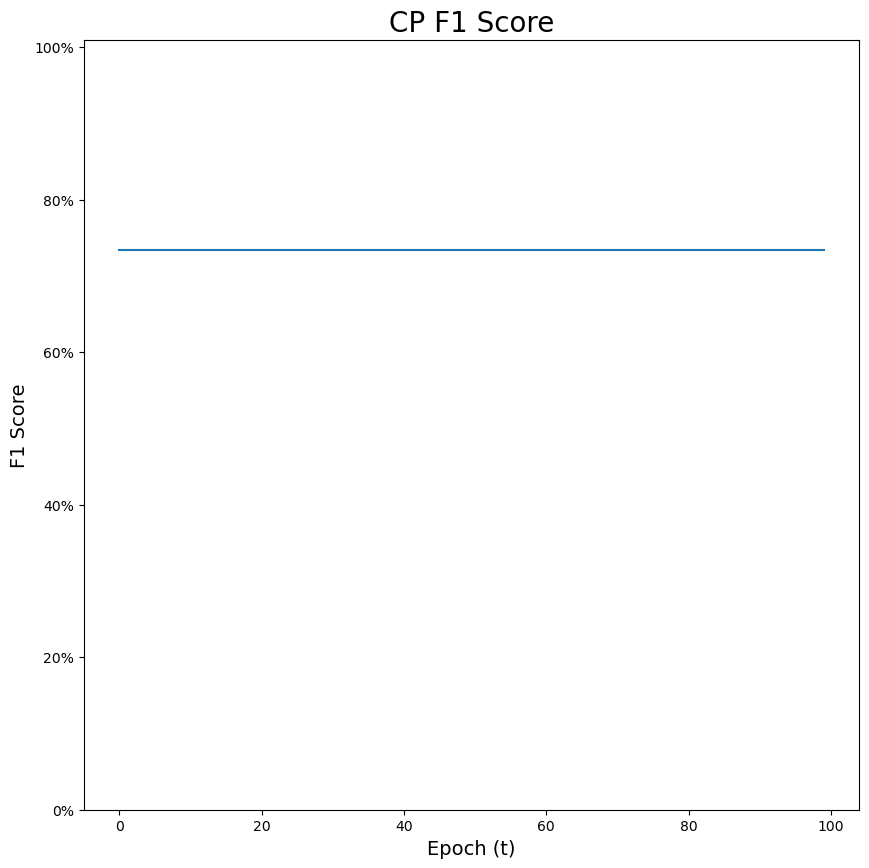

In [61]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)


##### 2-step lr = 0.03

In [62]:
learning_rate = 0.03
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


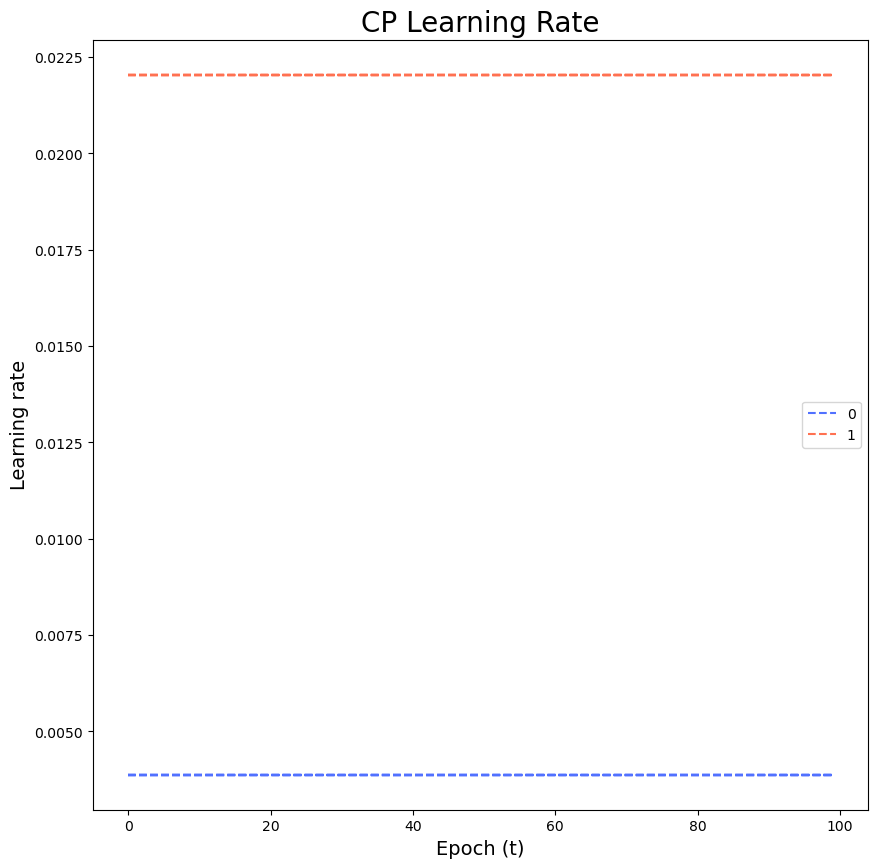

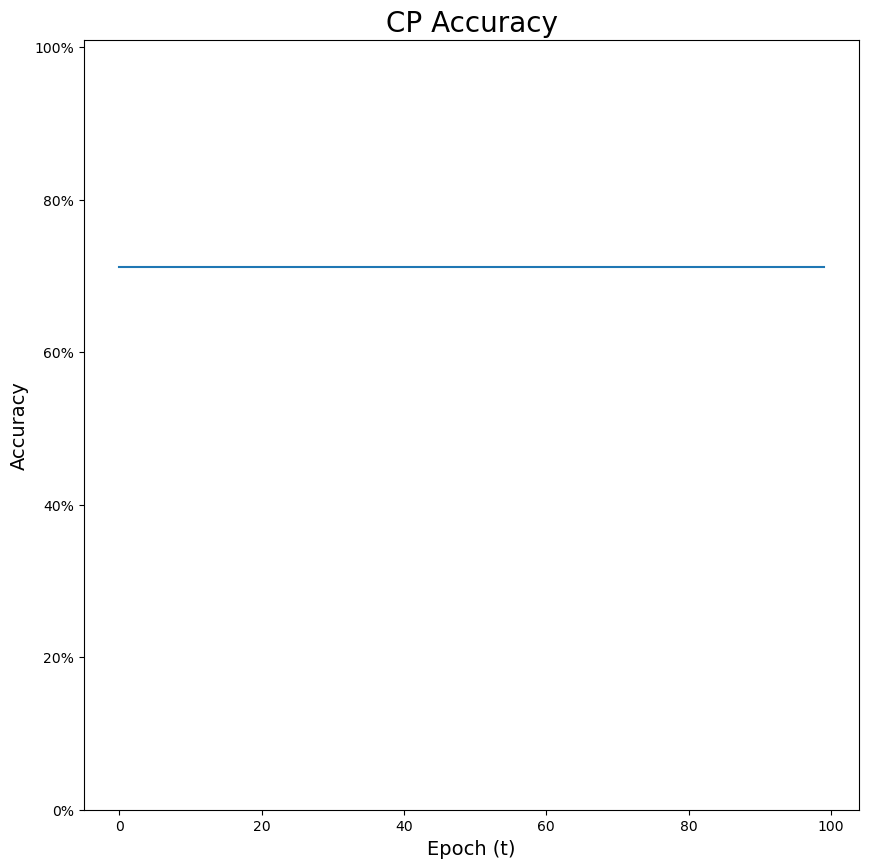

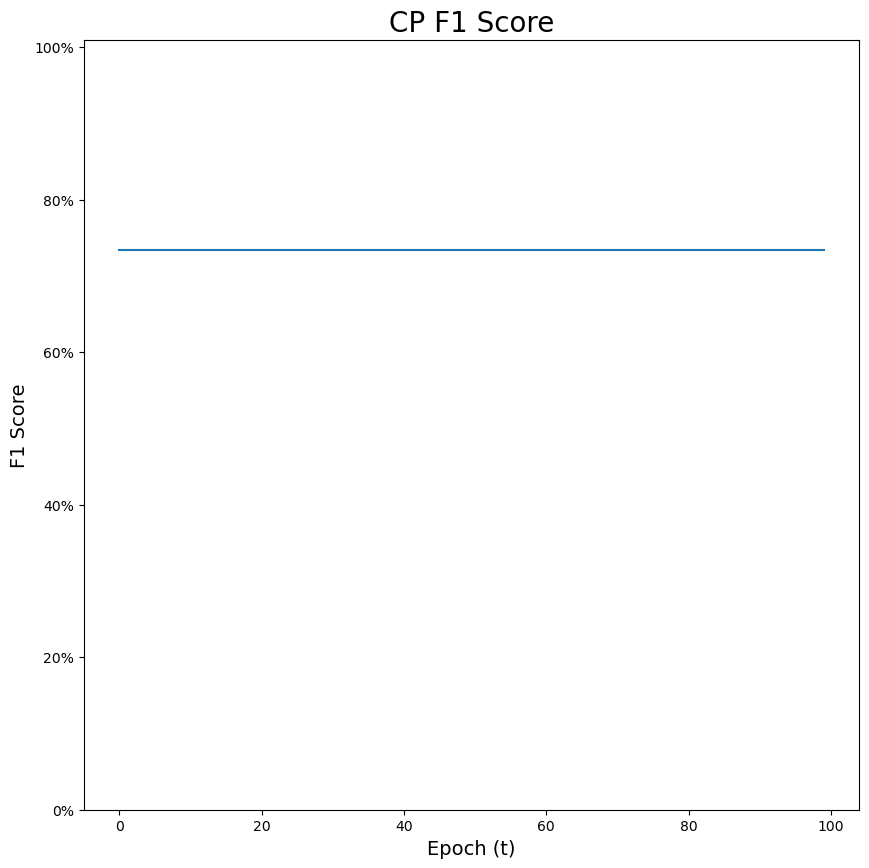

In [63]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)


##### 3-step lr = 0.01

In [64]:
learning_rate = 0.01
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


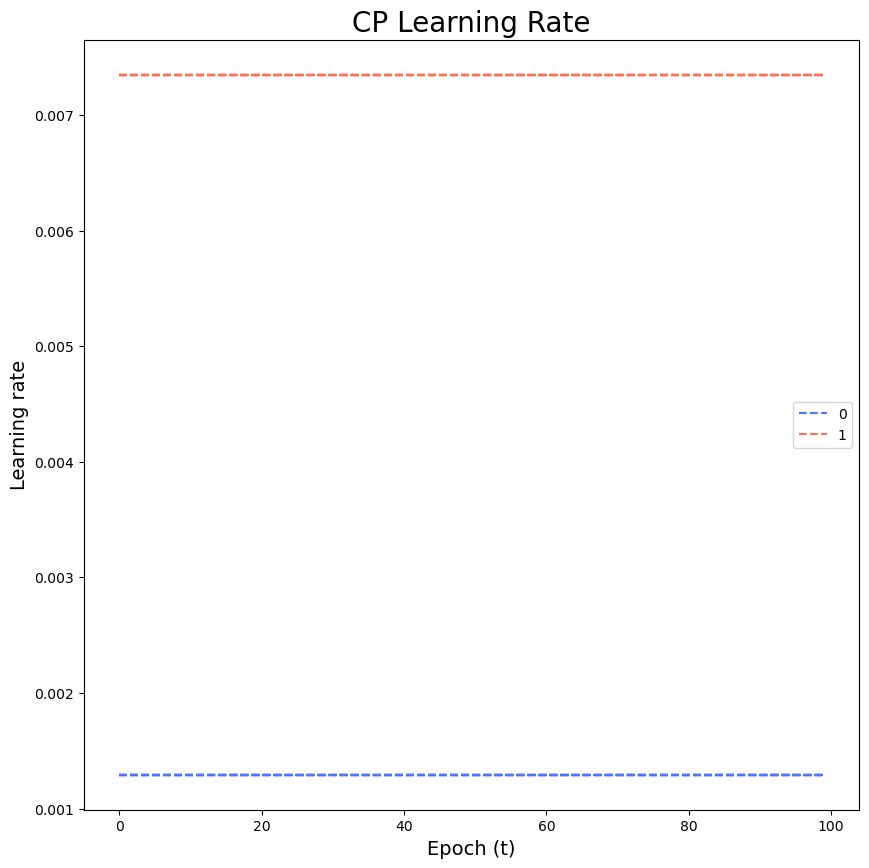

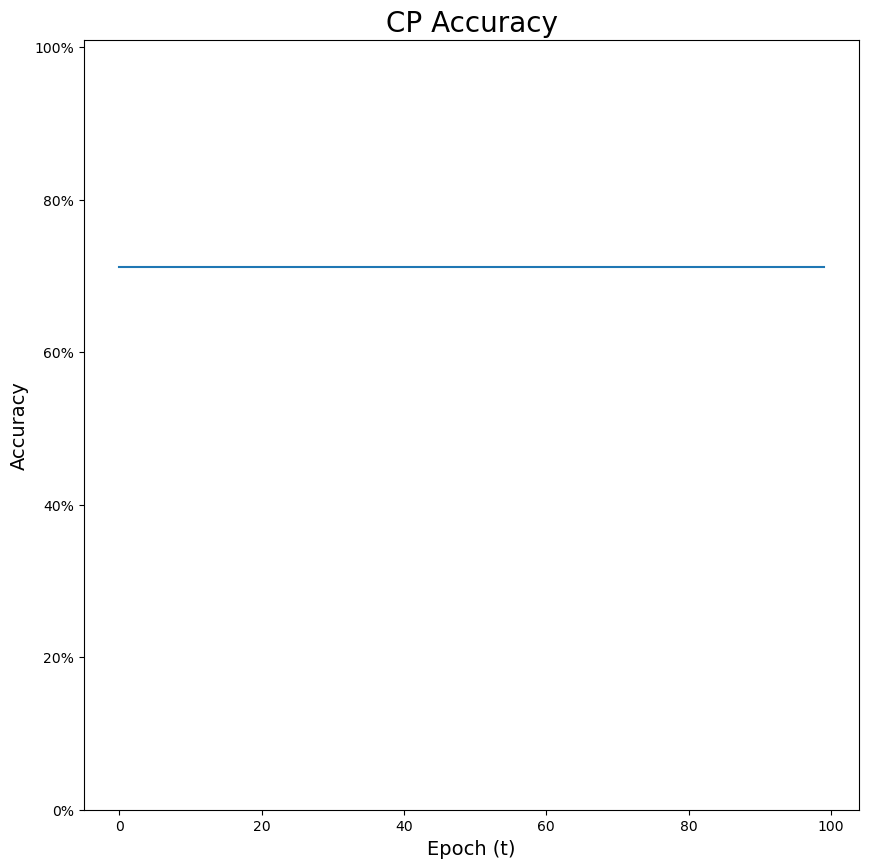

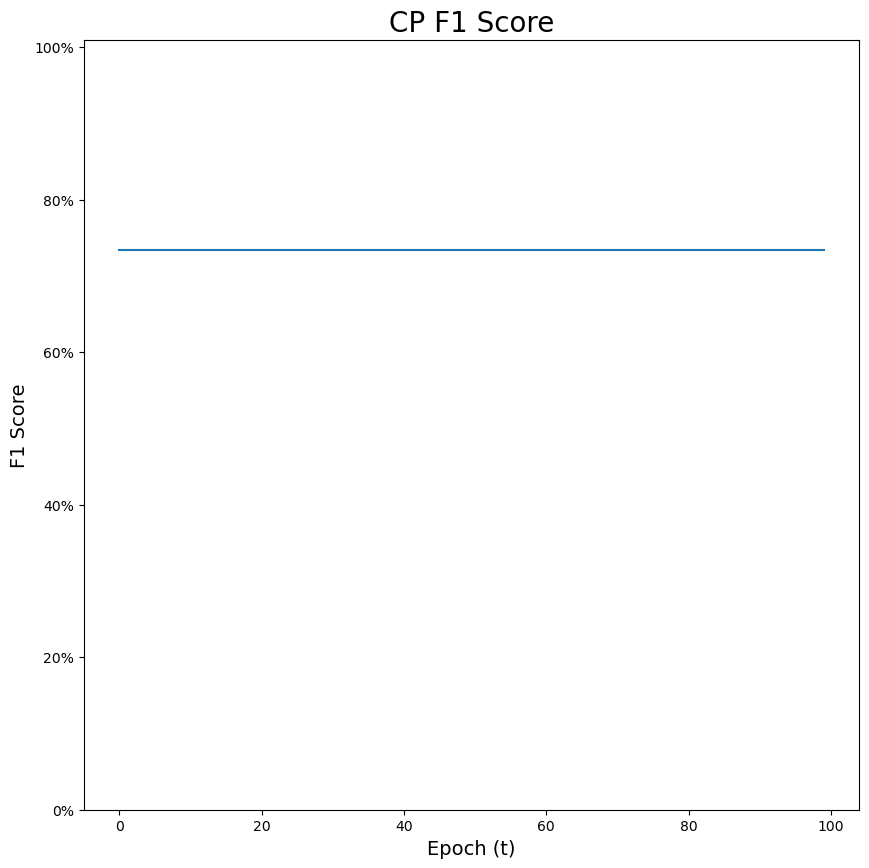

In [65]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)


##### DFH

##### 1-step lr = 0.1

In [66]:
learning_rate = 0.1
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


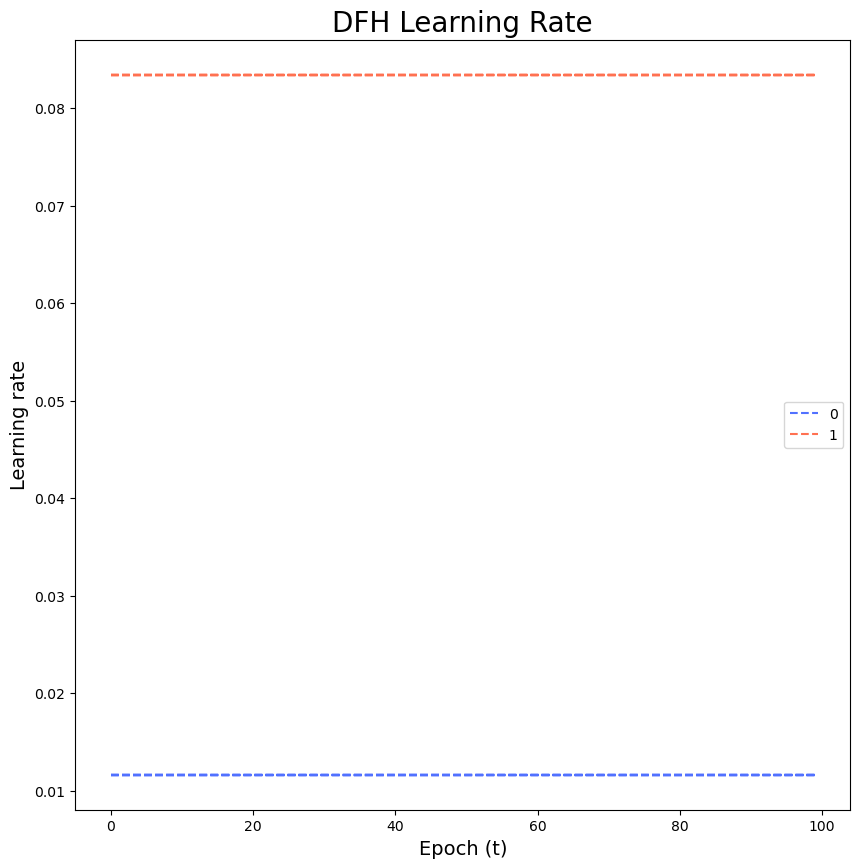

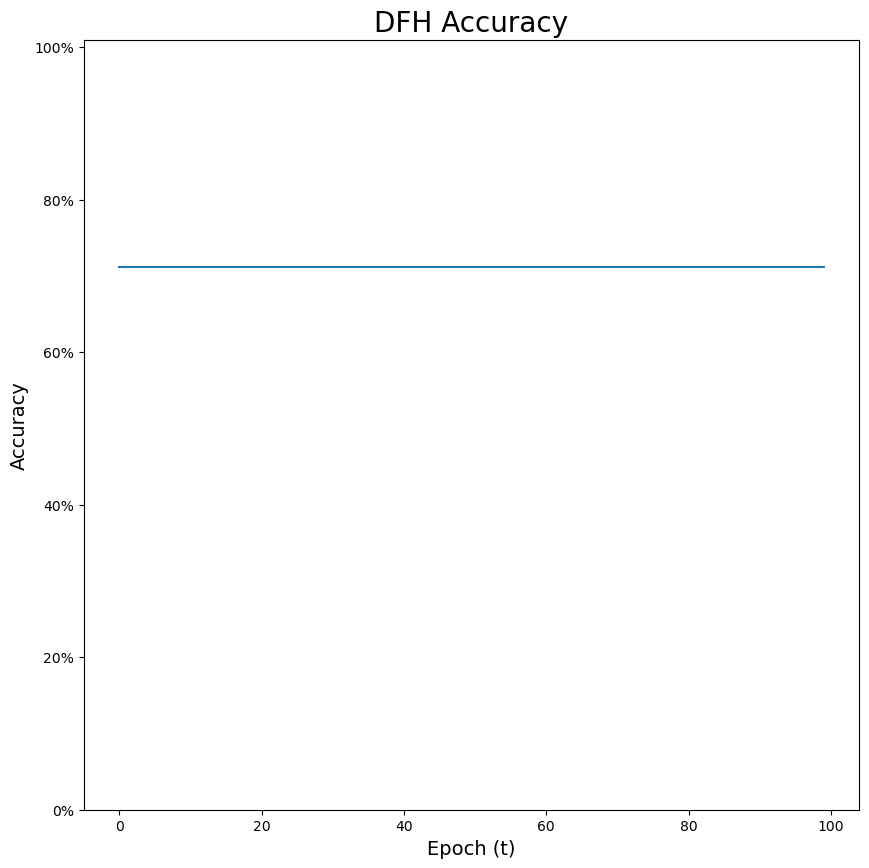

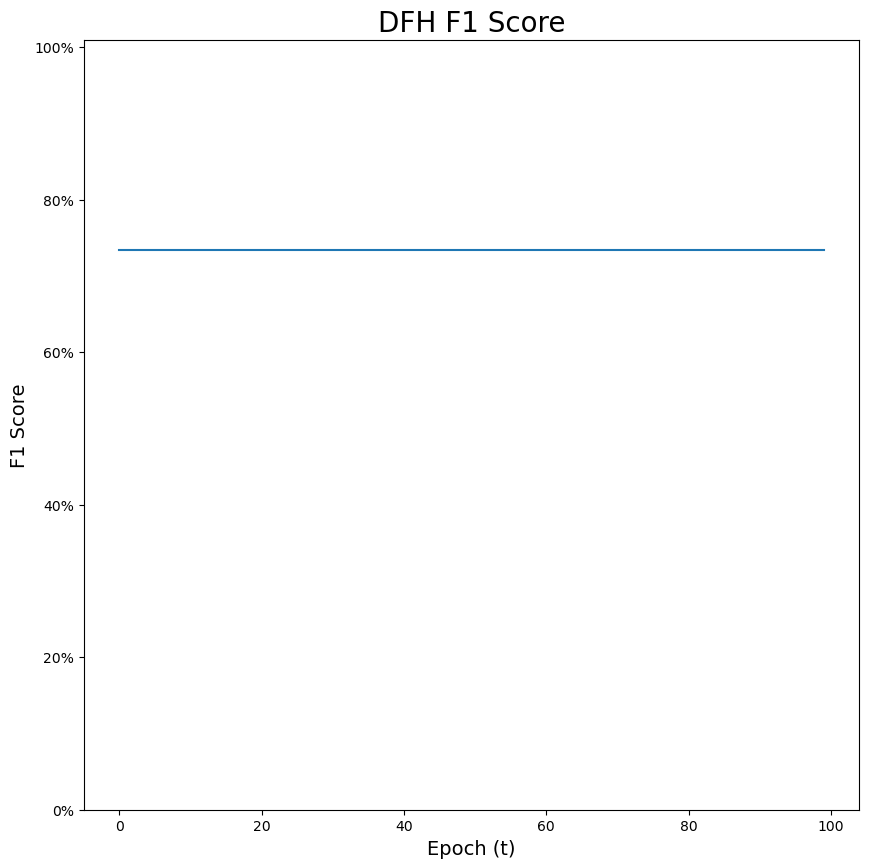

In [67]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)


##### 2-step lr = 0.03

In [68]:
learning_rate = 0.03
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


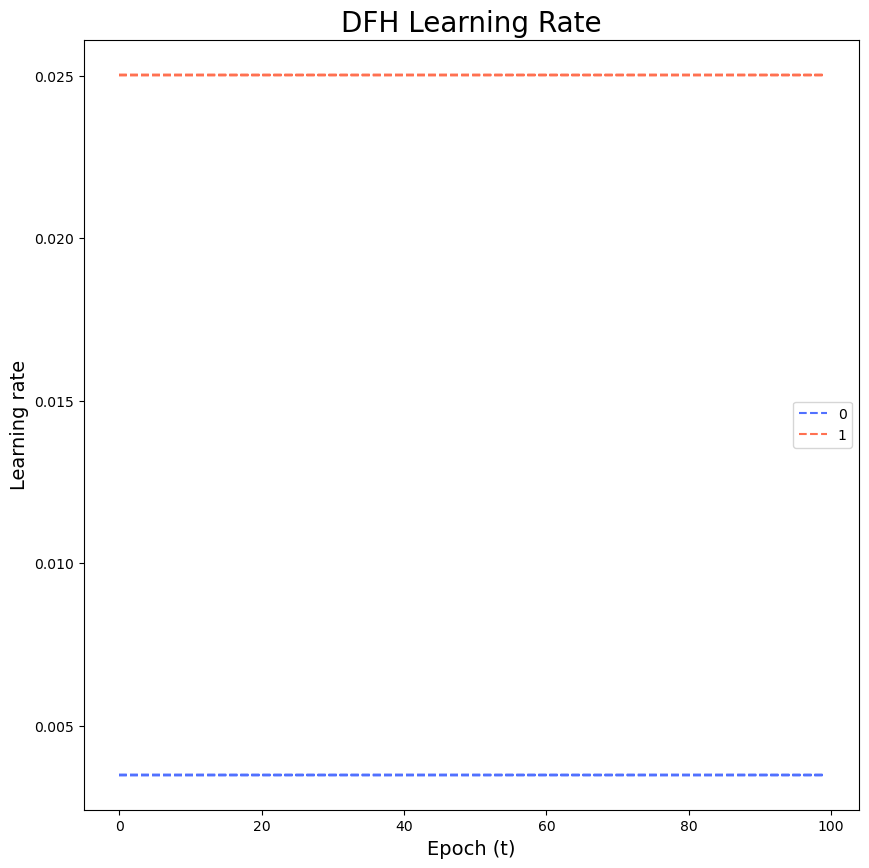

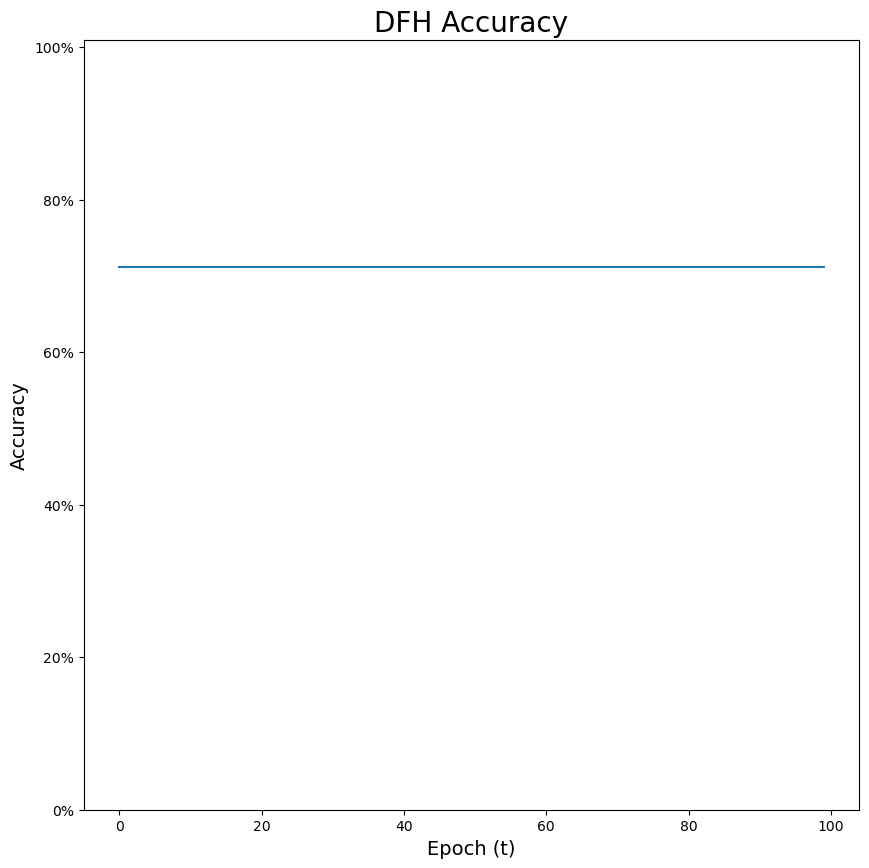

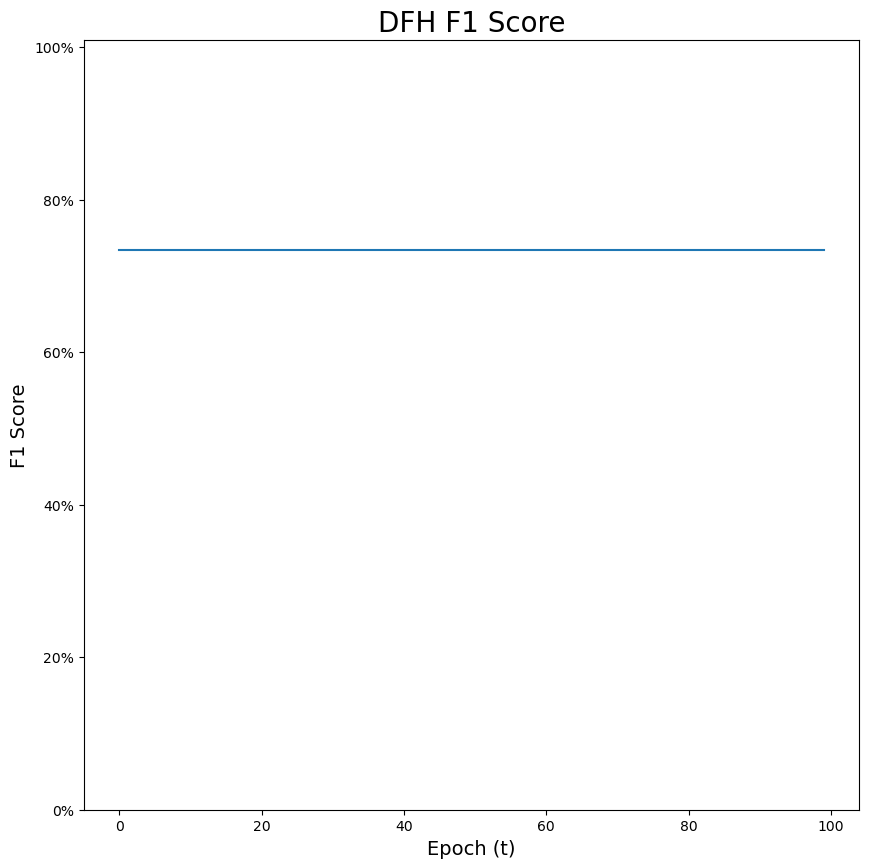

In [69]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)


##### 3-step lr = 0.01

In [70]:
learning_rate = 0.01
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


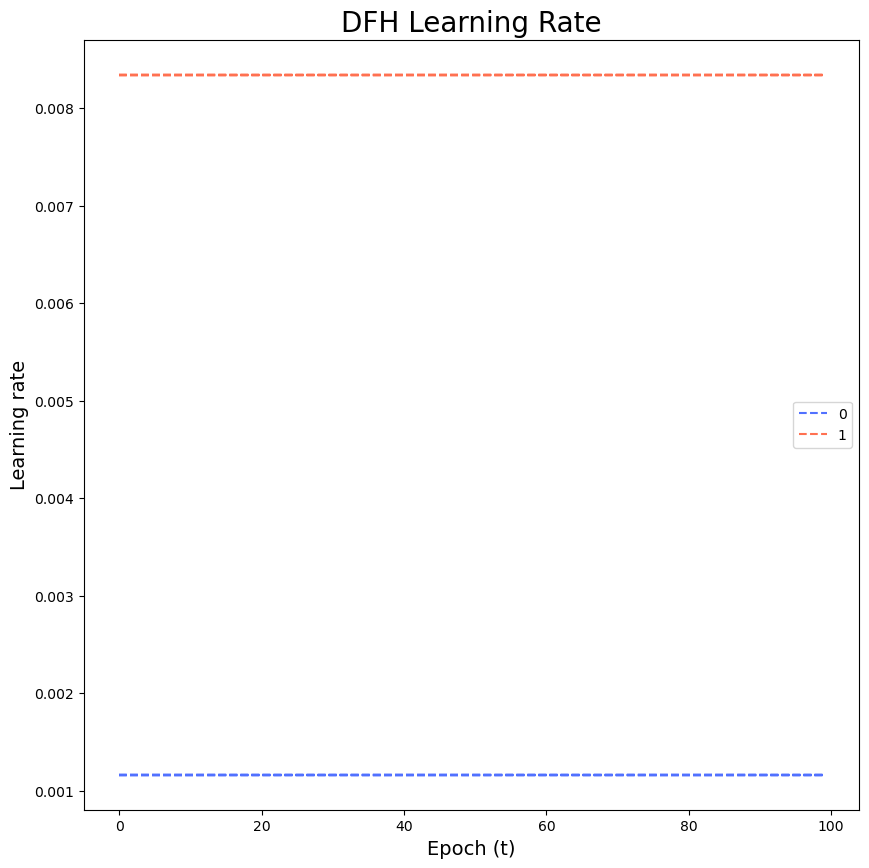

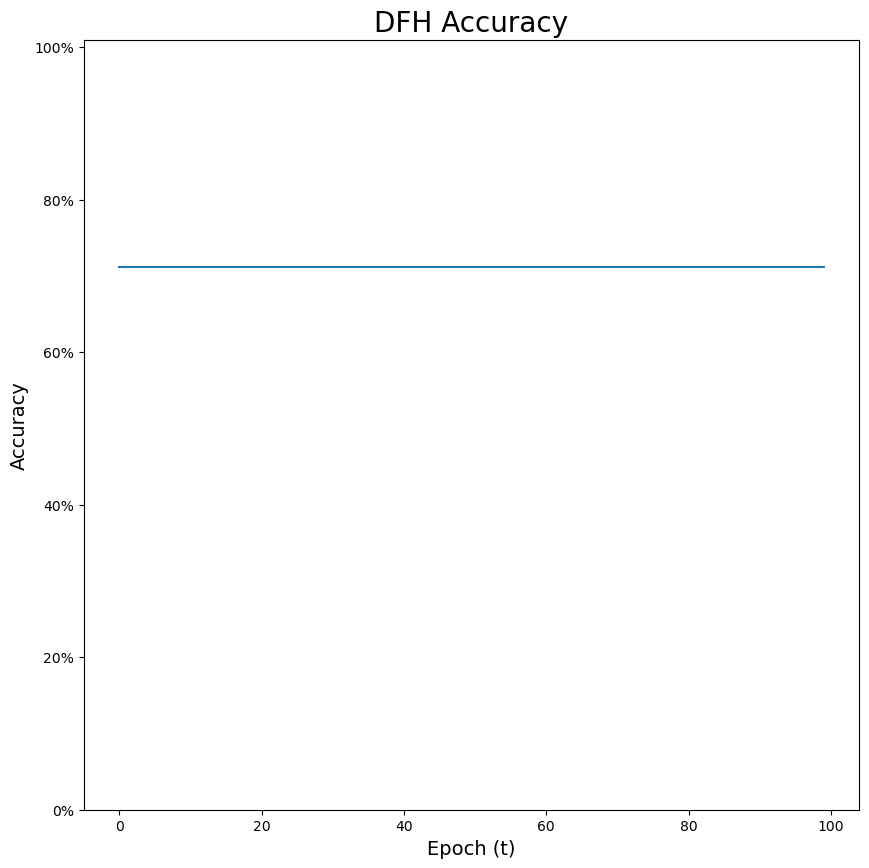

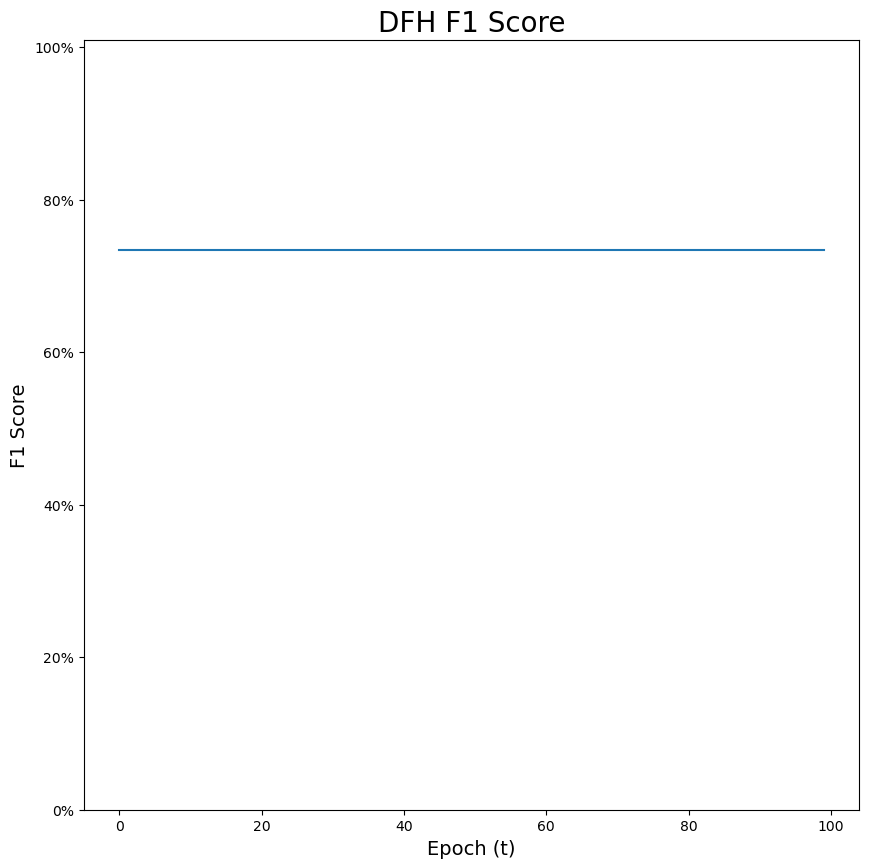

In [71]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)


##### MS

##### 1-step lr = 0.1

In [72]:
learning_rate = 0.1
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


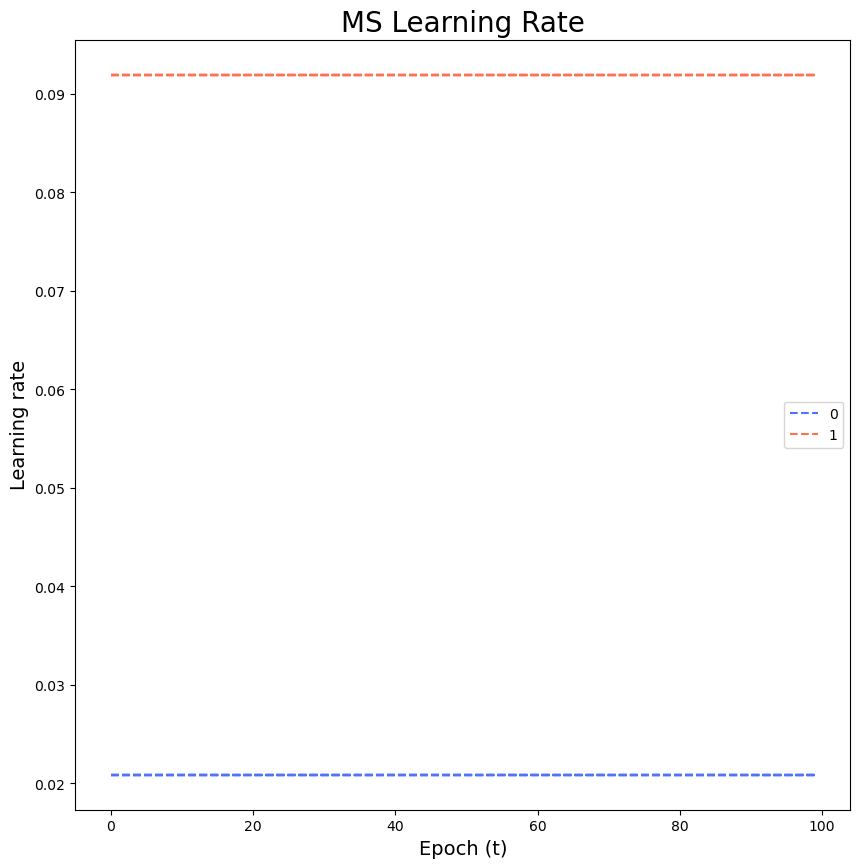

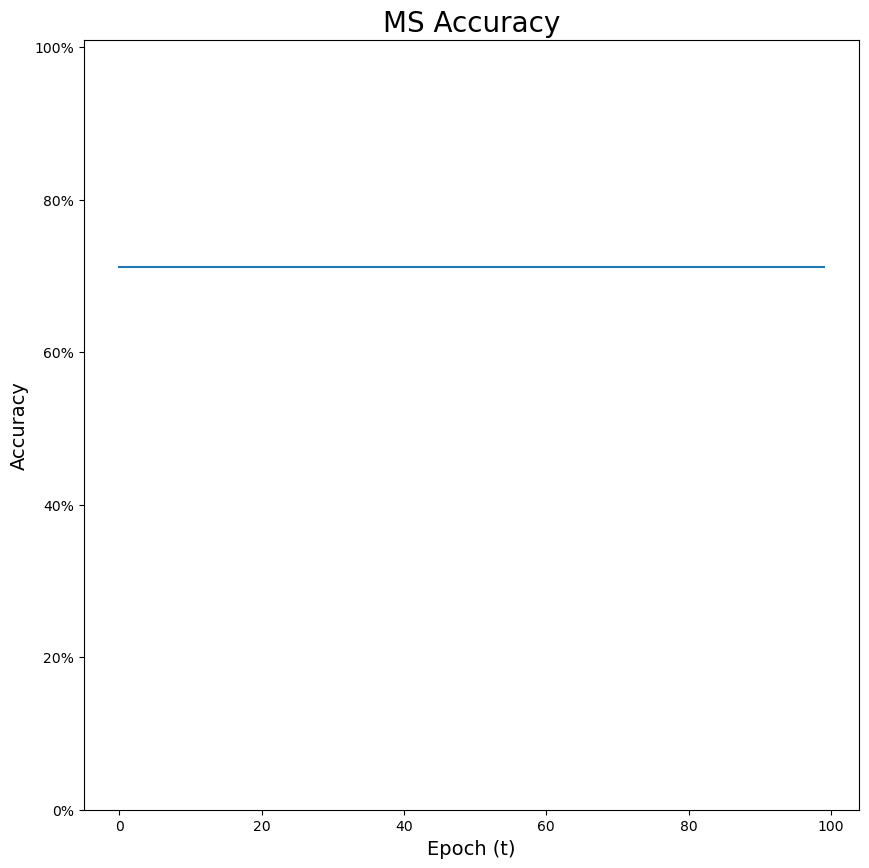

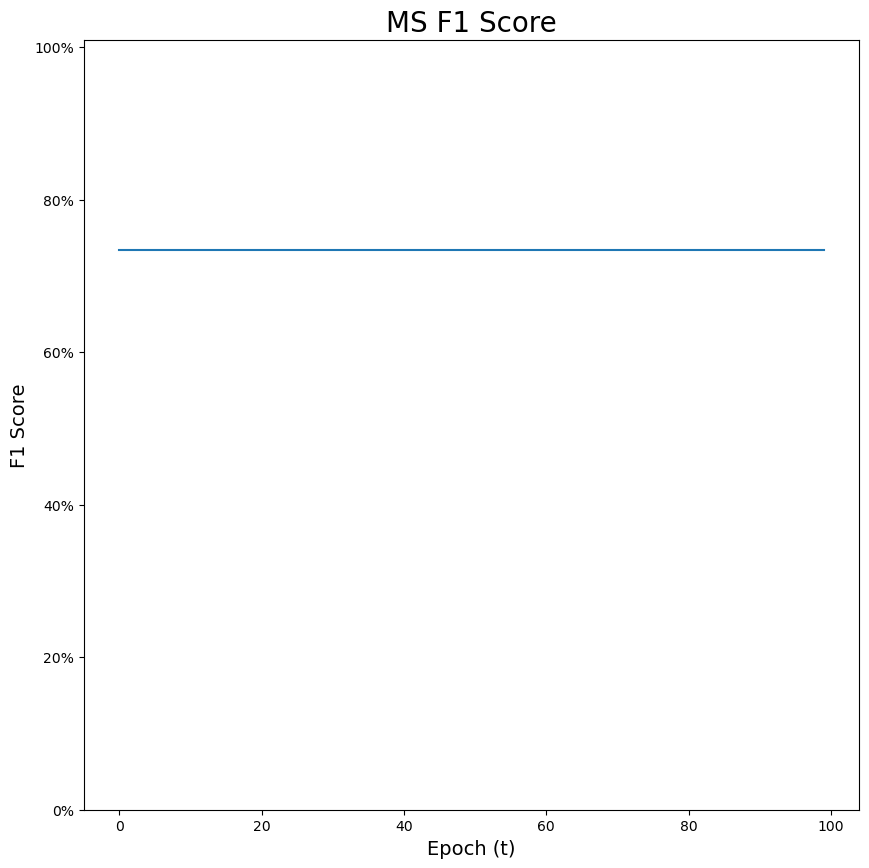

In [73]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)


##### 2-step lr = 0.03

In [74]:
learning_rate = 0.03
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


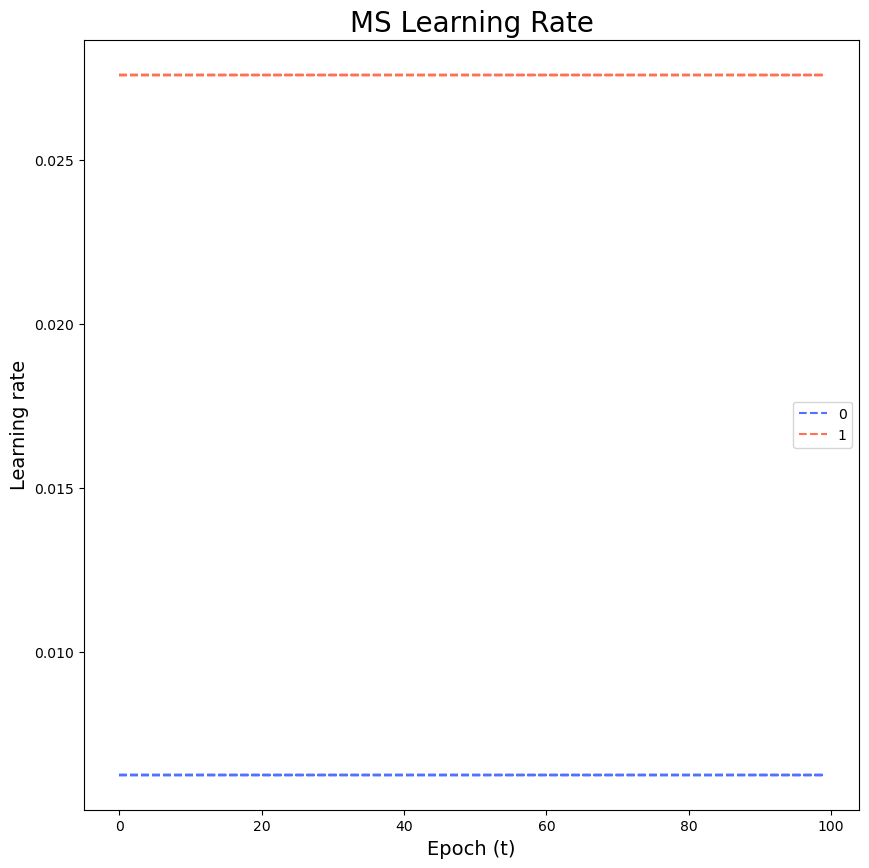

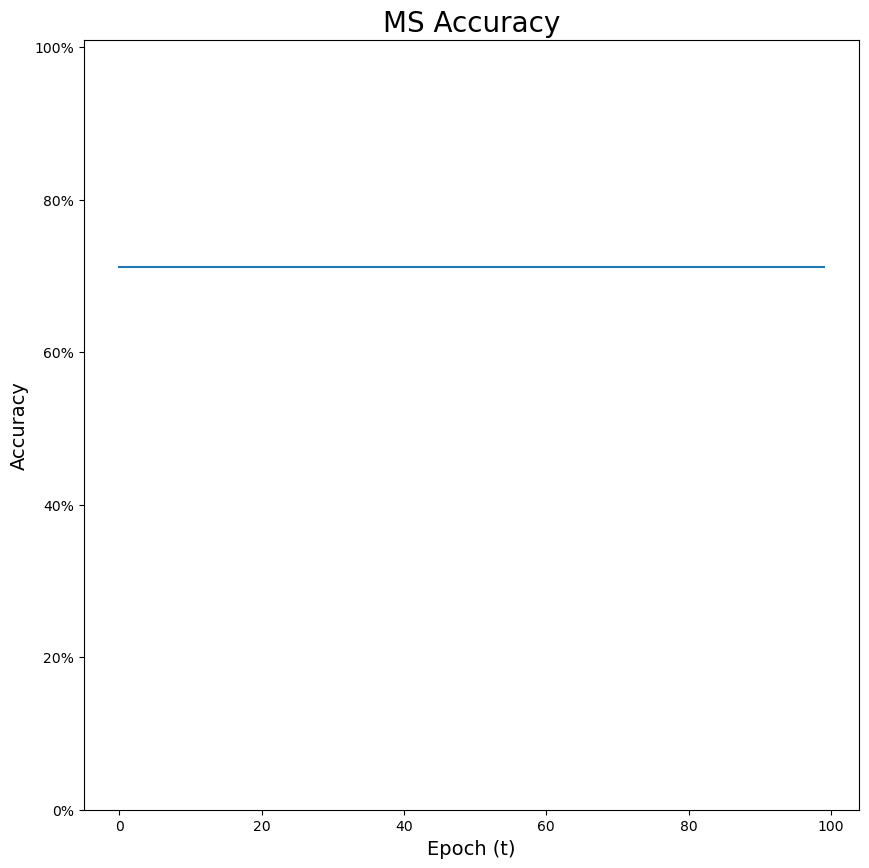

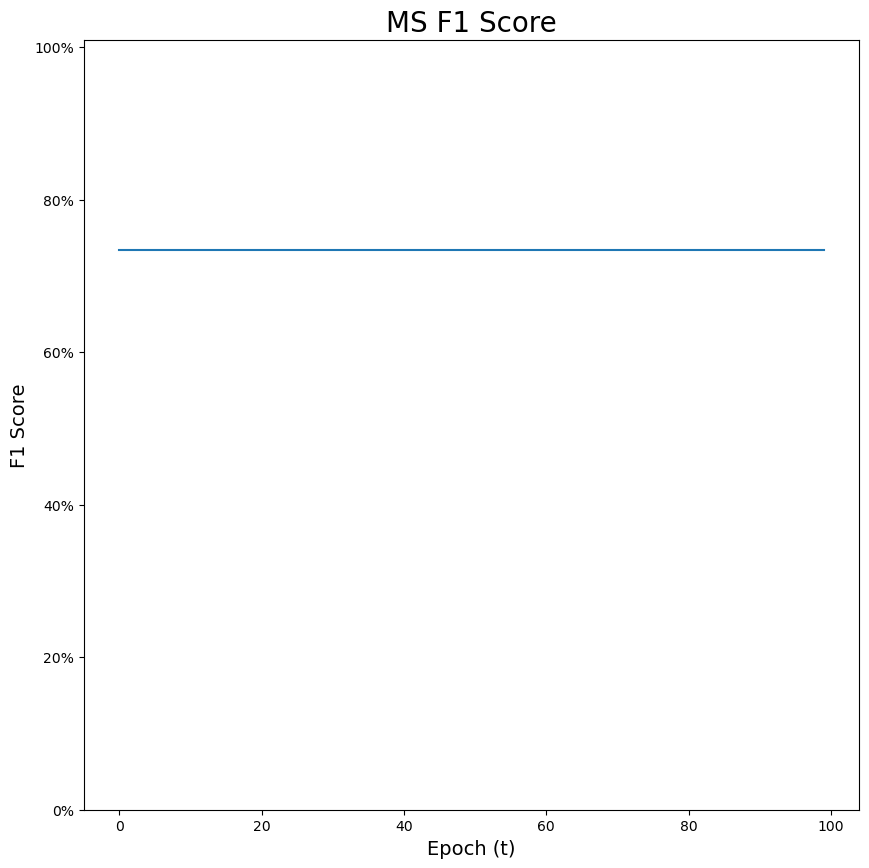

In [75]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)


##### 3-step lr = 0.01

In [76]:
learning_rate = 0.01
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


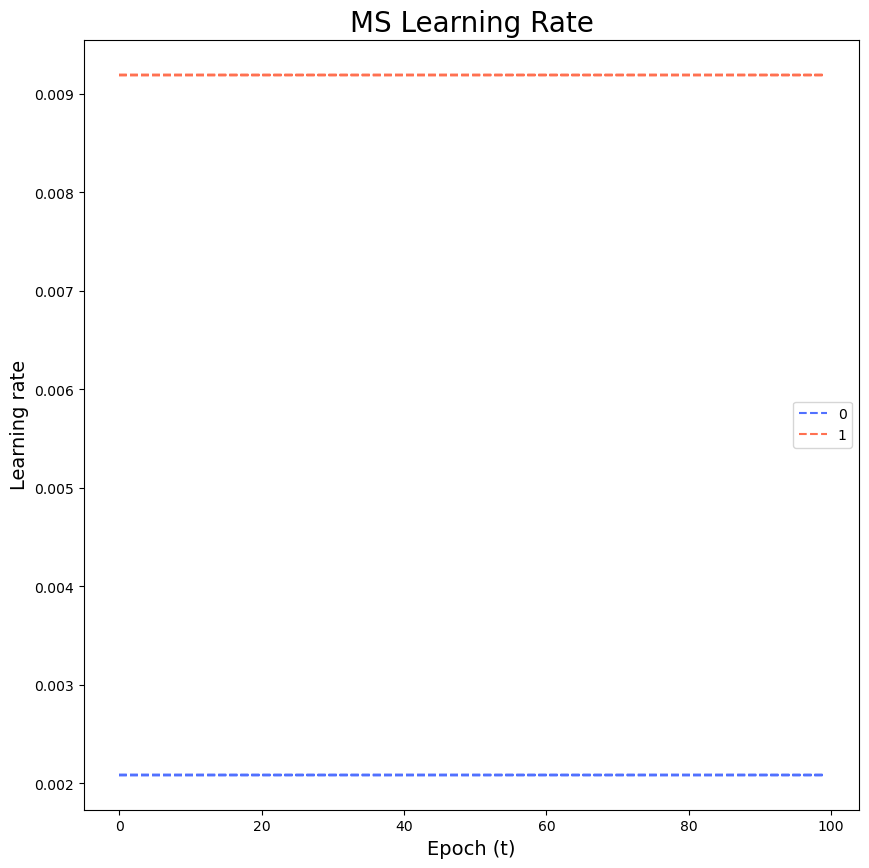

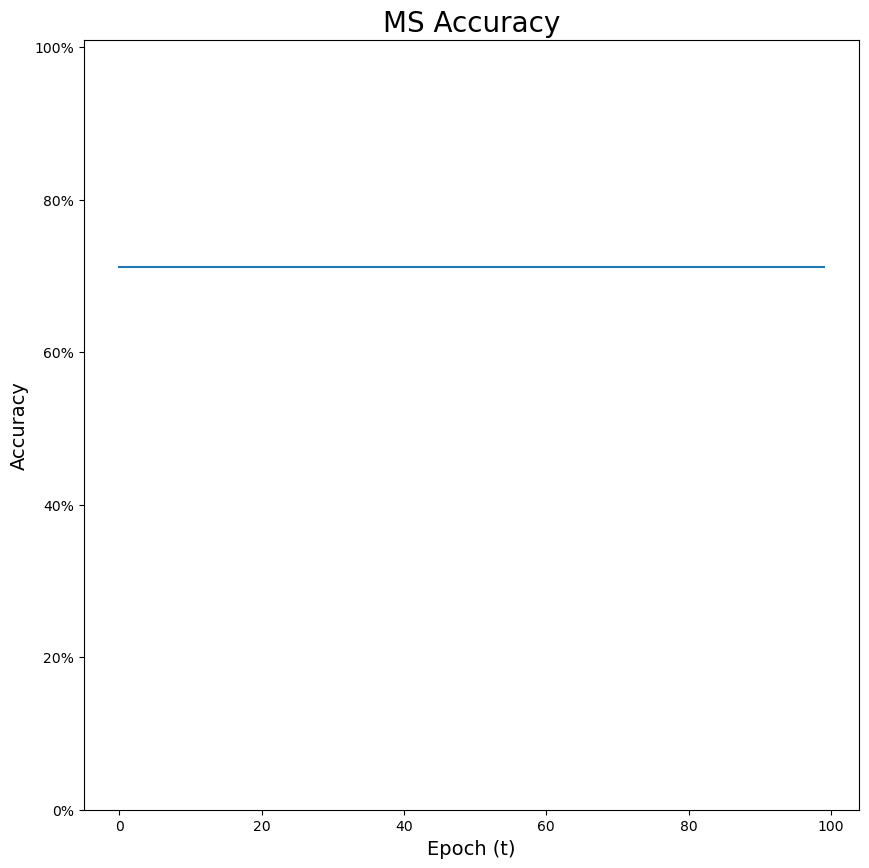

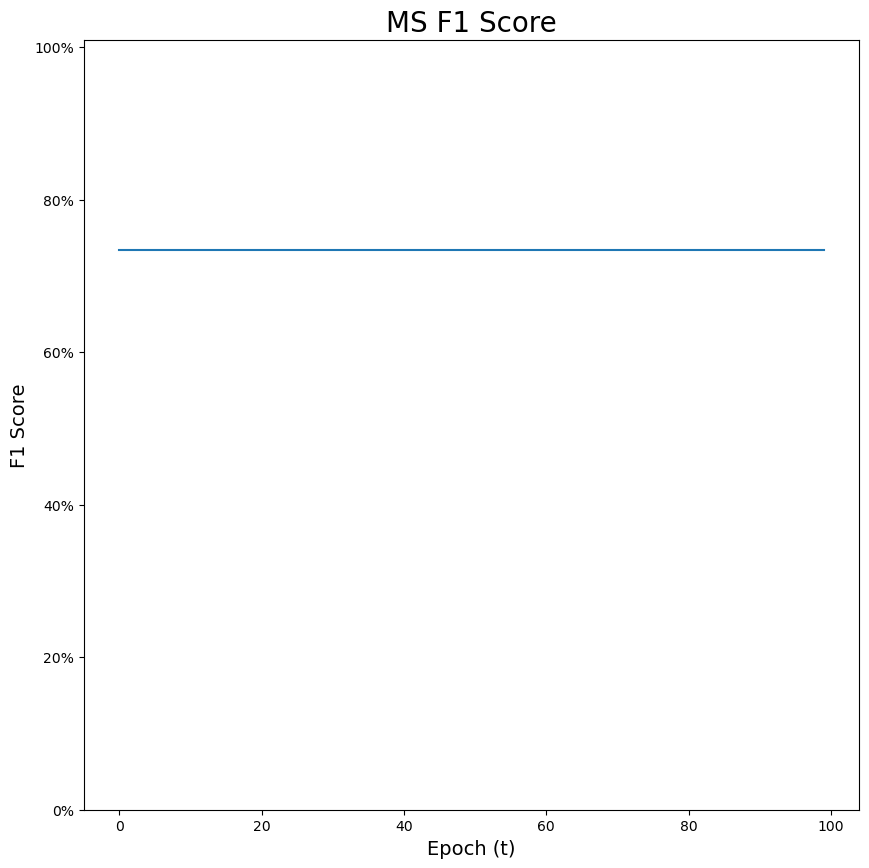

In [77]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)


##### LS

##### 1-step lr = 0.1

In [78]:
learning_rate = 0.1
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


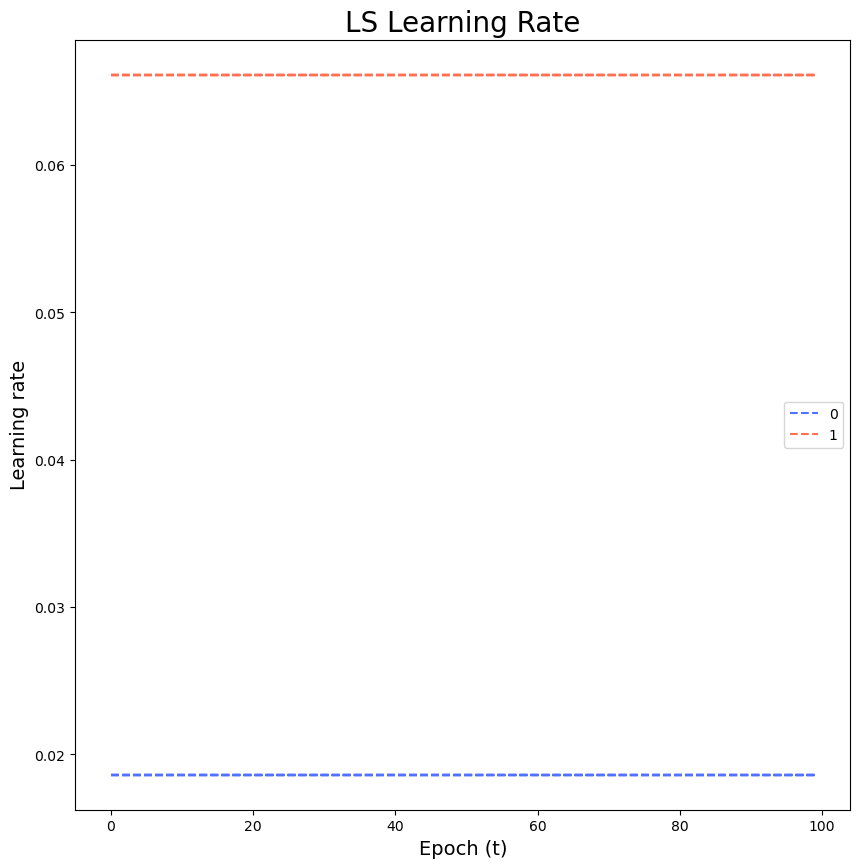

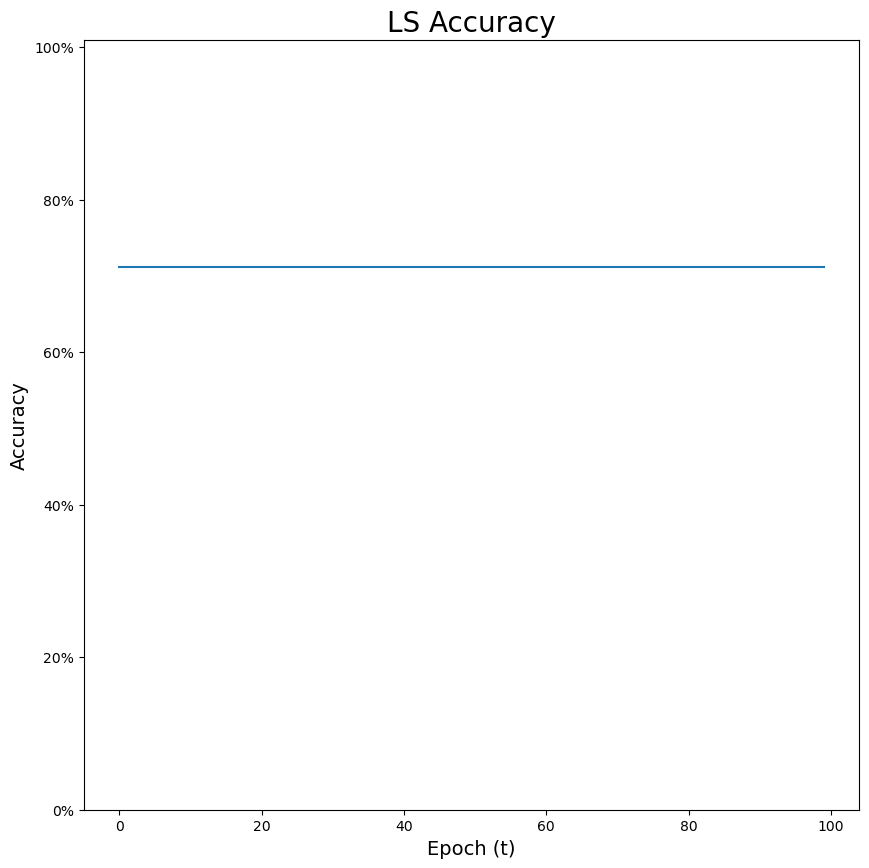

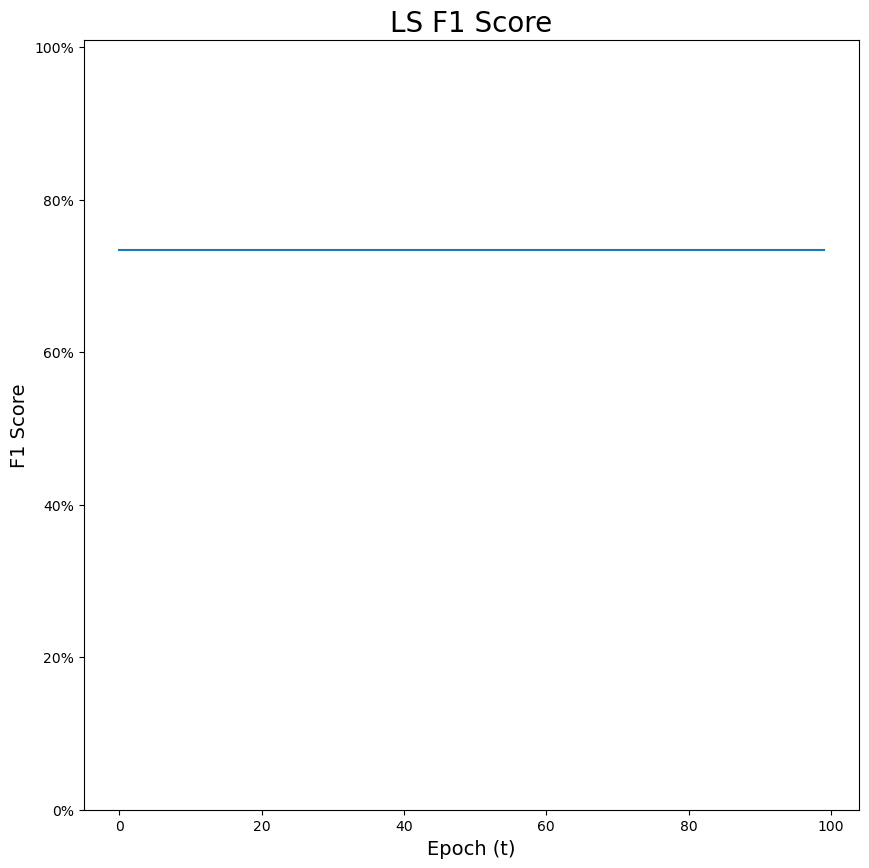

In [79]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)


##### 2-step lr = 0.03

In [80]:
learning_rate = 0.03
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


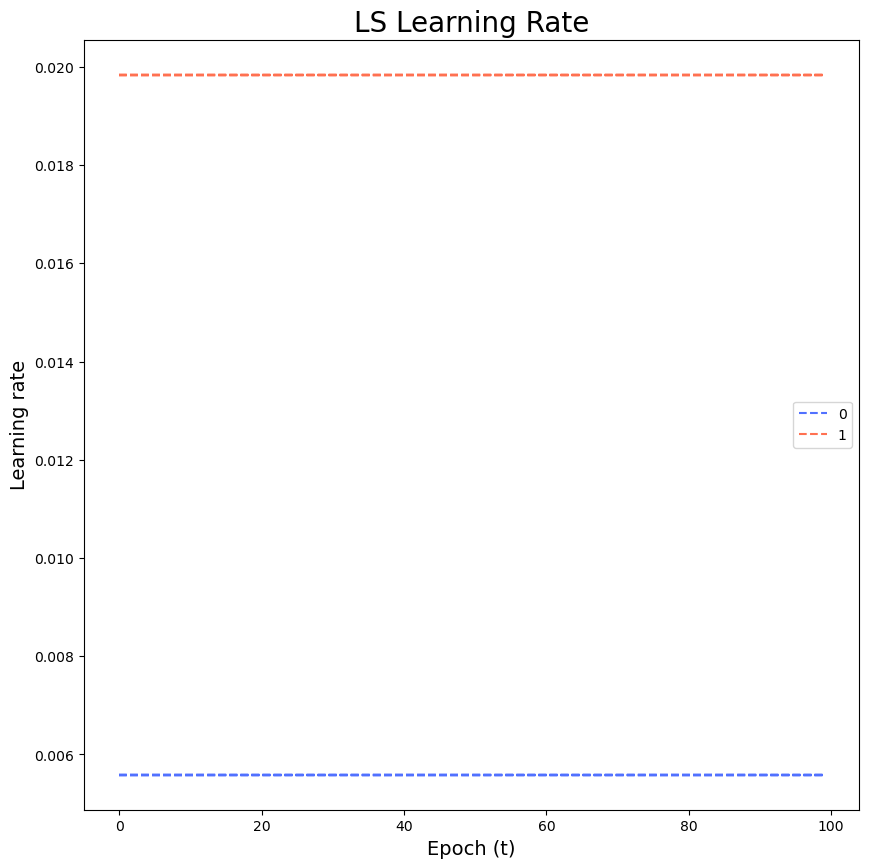

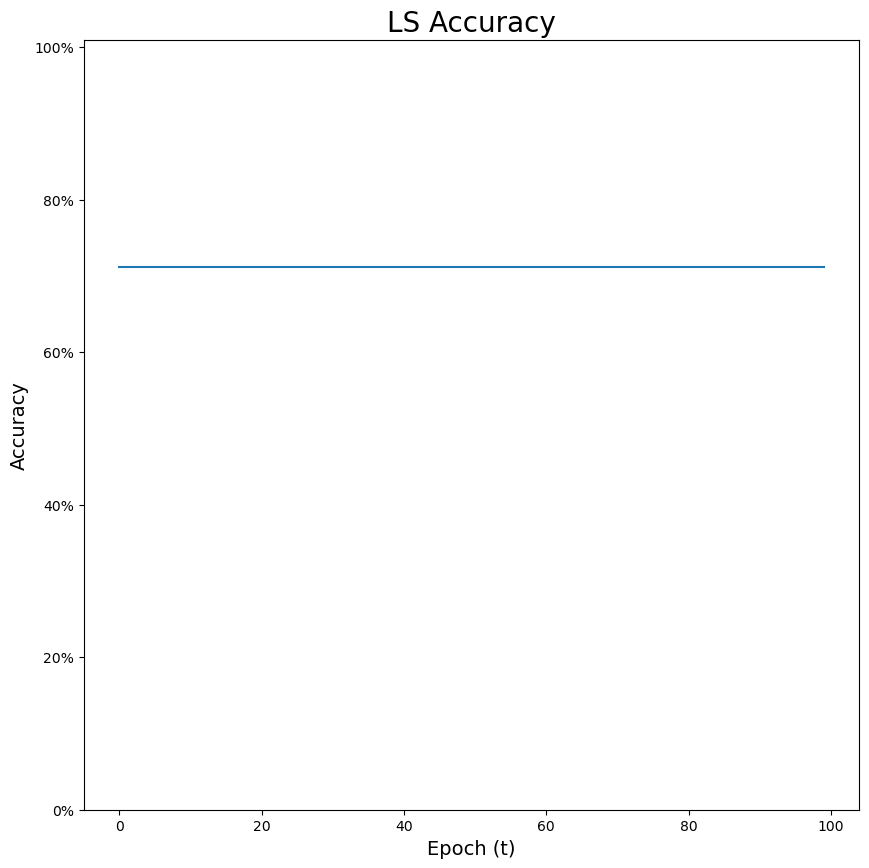

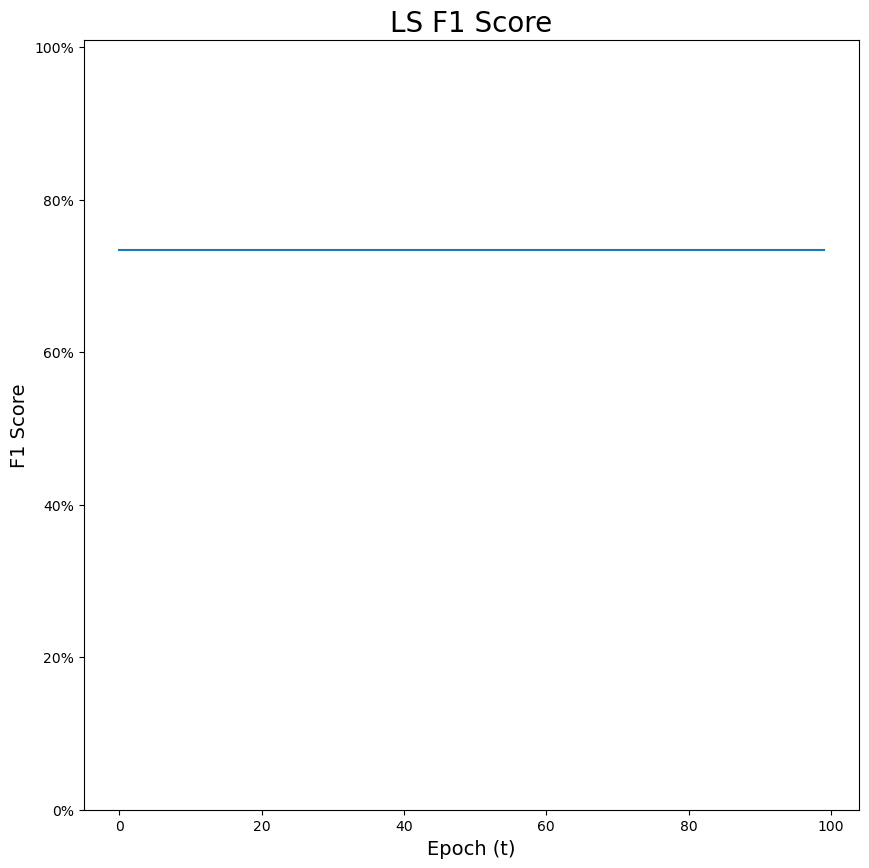

In [81]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)


##### 3-step lr = 0.01

In [82]:
learning_rate = 0.01
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


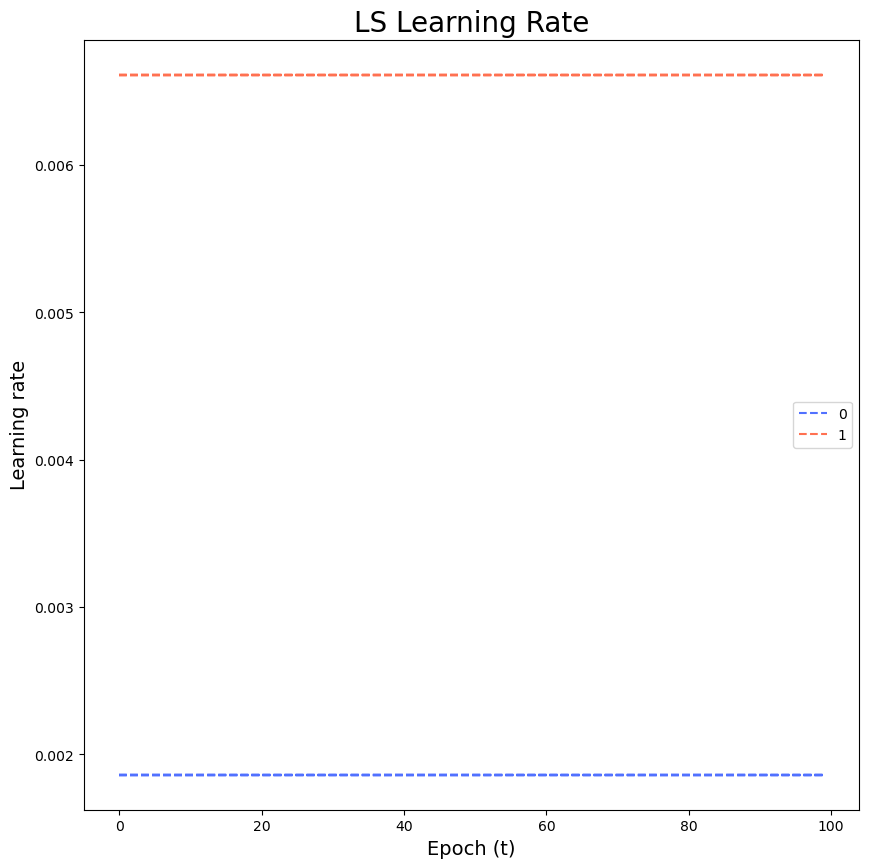

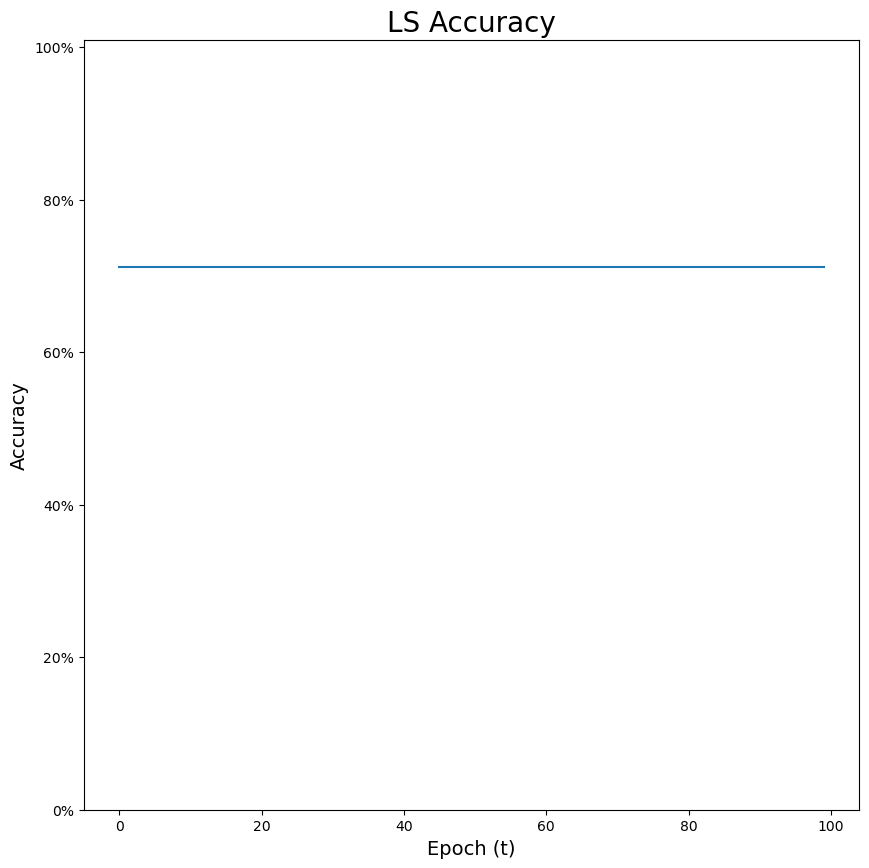

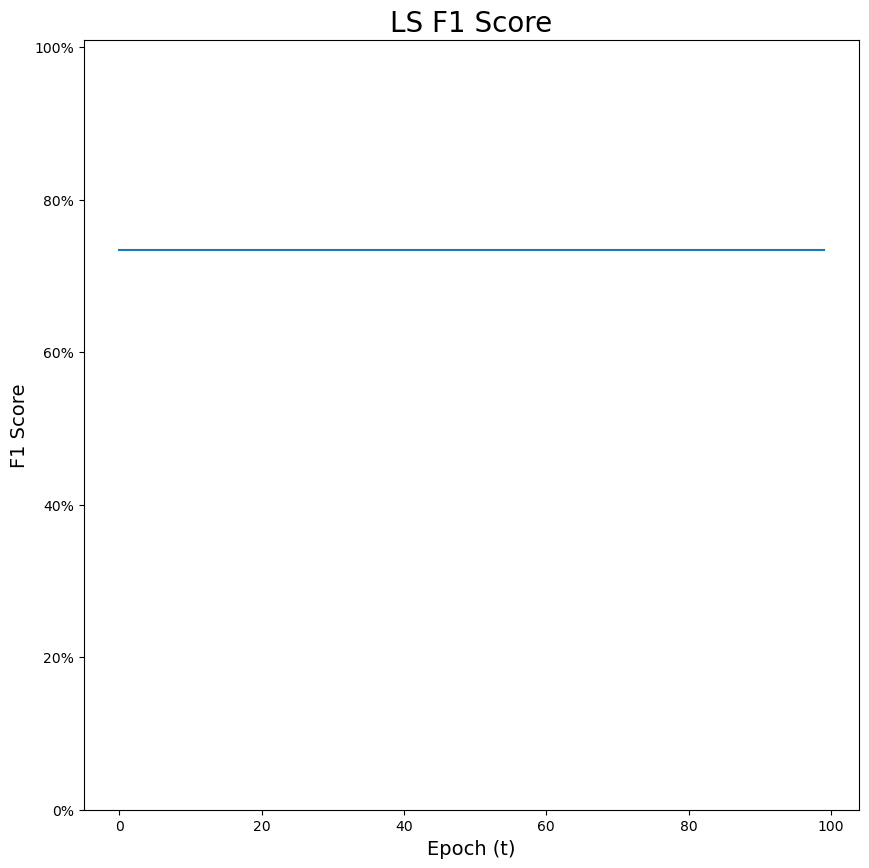

In [83]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)


##### LSR

##### 1-step lr = 0.1

In [84]:
learning_rate = 0.1
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


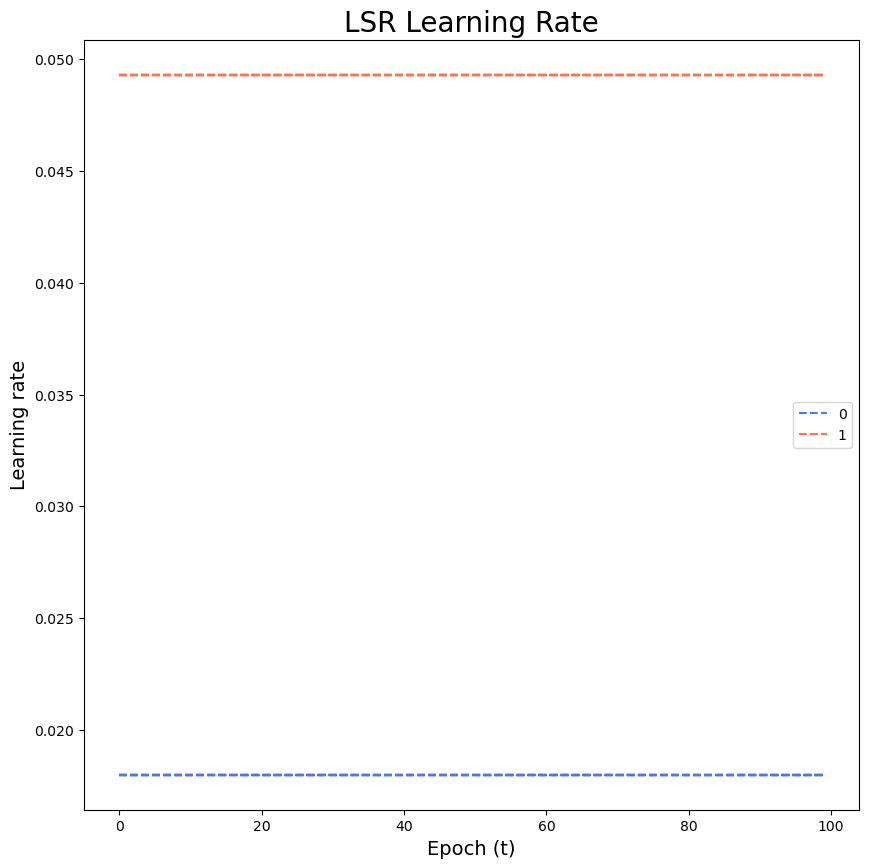

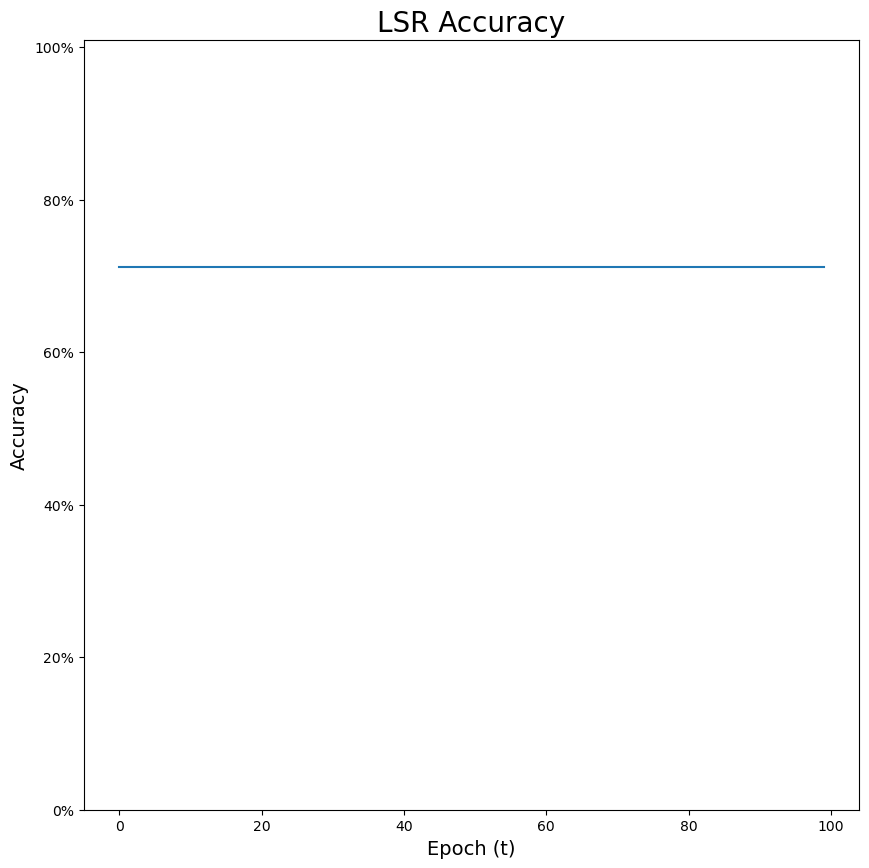

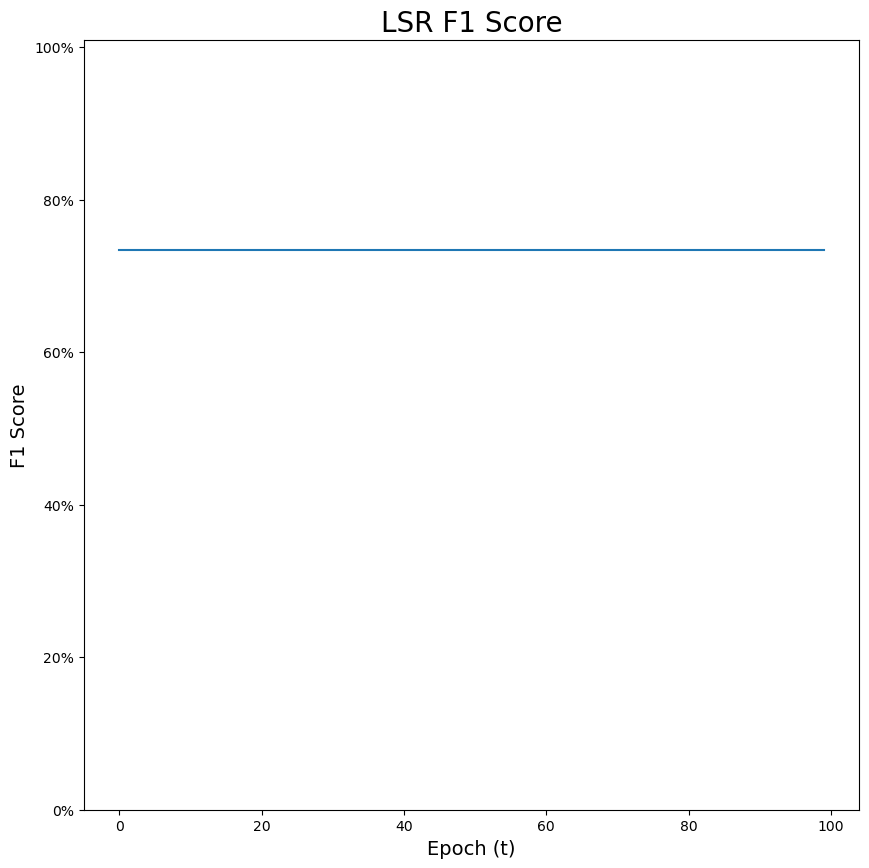

In [85]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)


##### 2-step lr = 0.03

In [86]:
learning_rate = 0.03
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


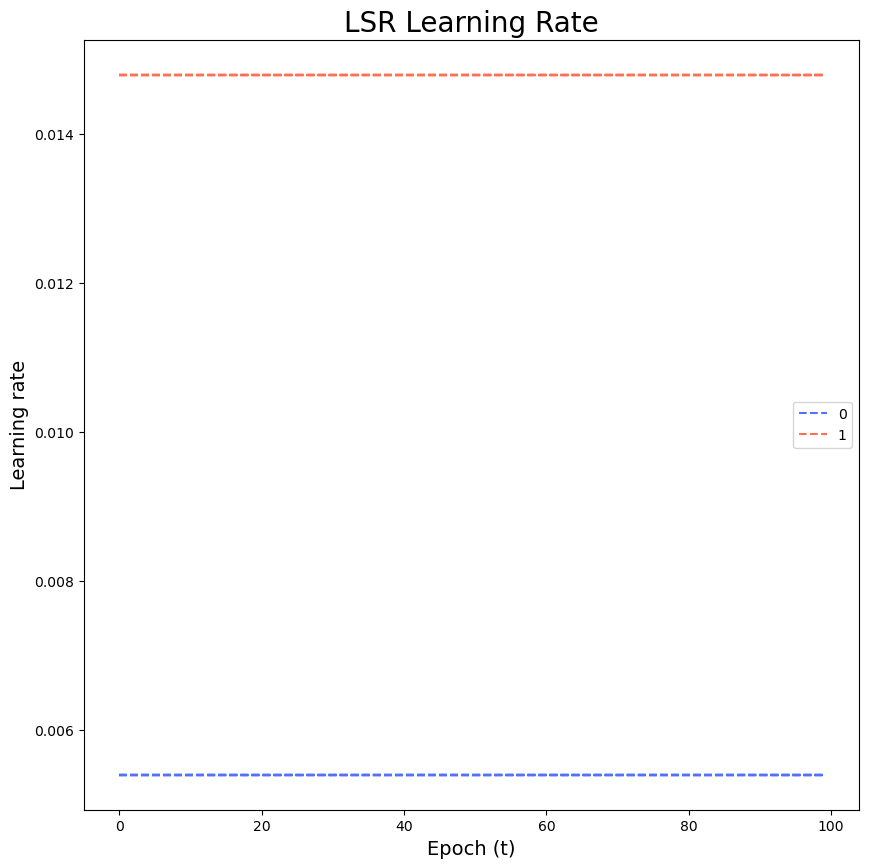

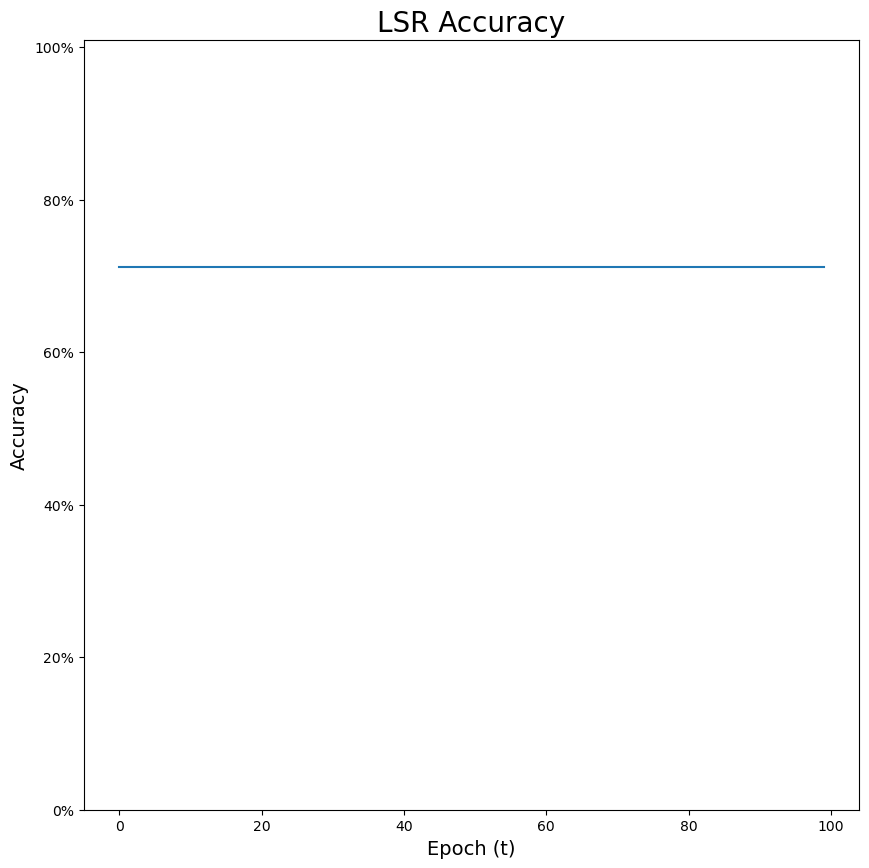

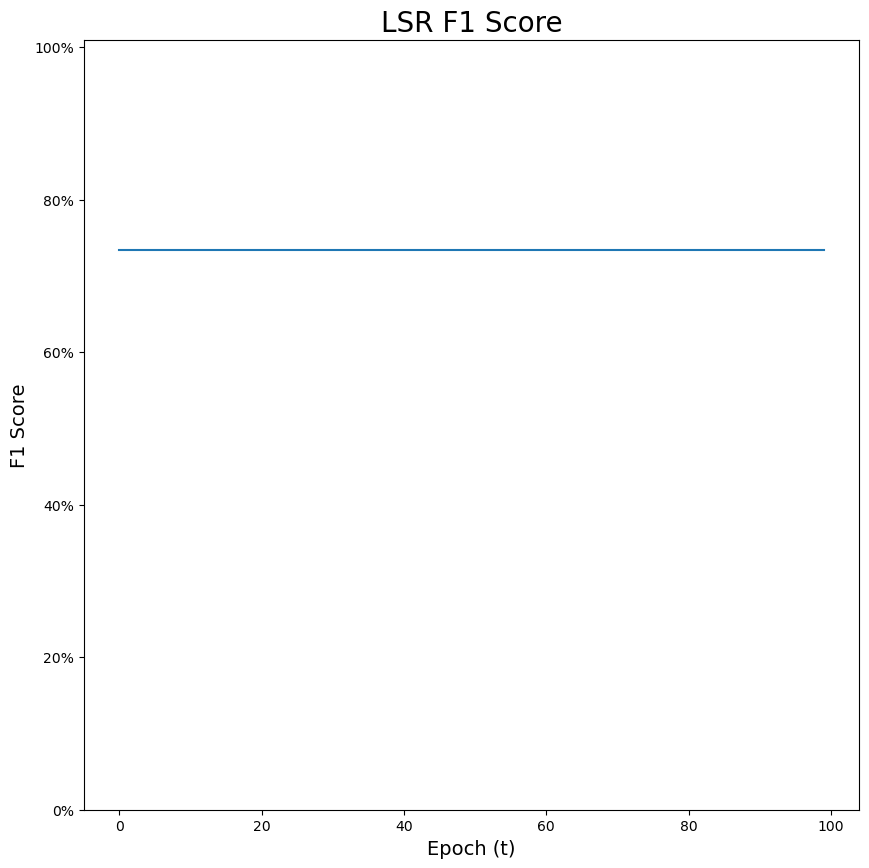

In [87]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)


##### 3-step lr = 0.01

In [88]:
learning_rate = 0.01
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)

Epoch: 1, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 11, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 21, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 31, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 41, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 51, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 61, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 71, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 81, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %
Epoch: 91, Loss: 0.4641, Accuracy: 71.19 %, F_1_score: 73.43 %


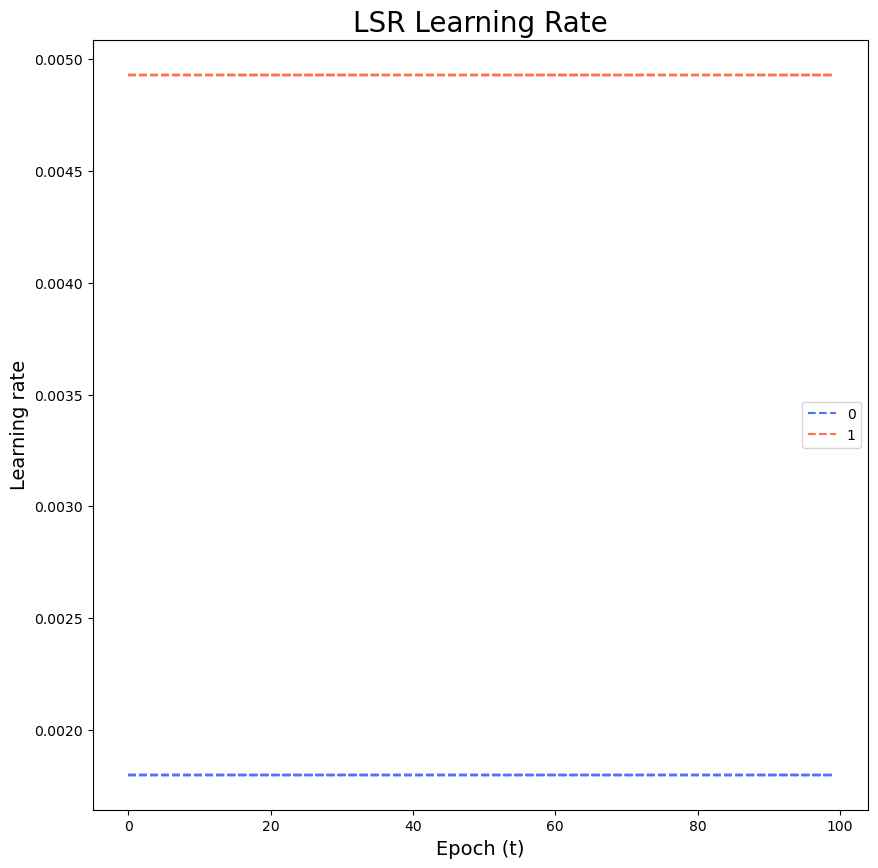

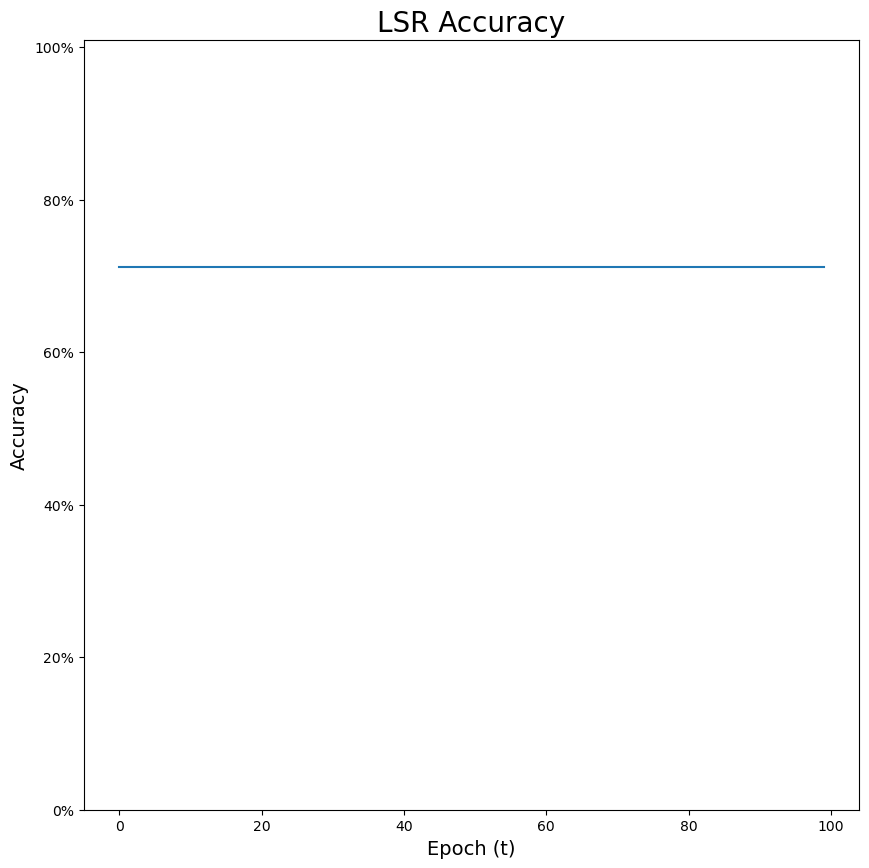

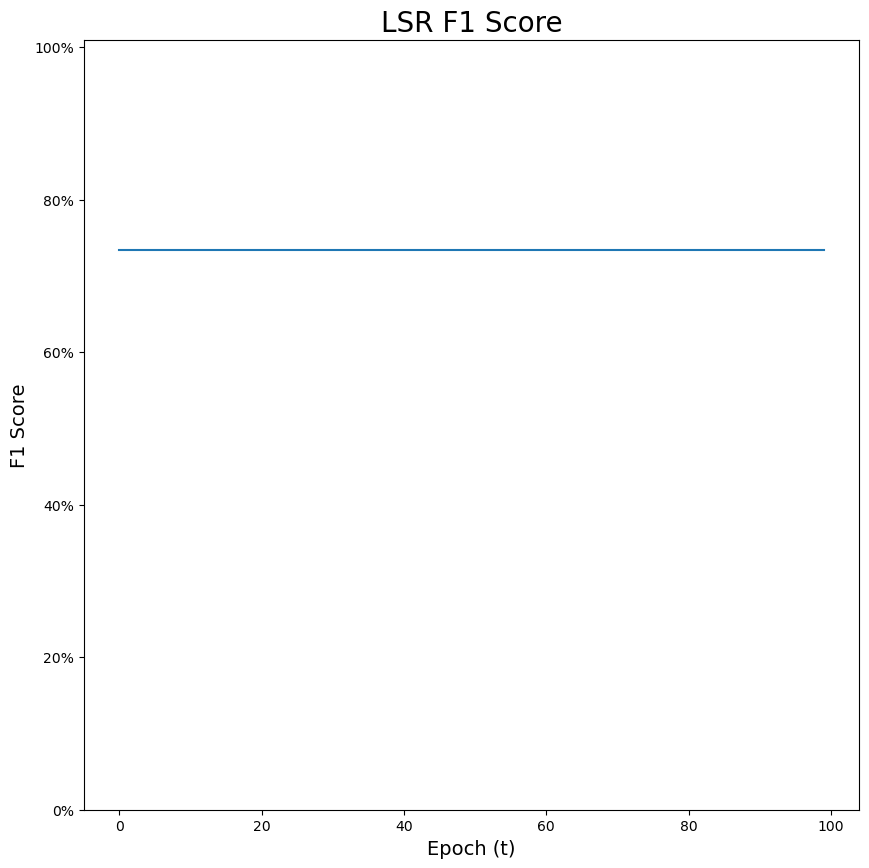

In [89]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)
